## Multiclass CNN for Ultasound NDT image classification

Cases considered for this particular implementation includes:
1. Flat Bottom Hole
2. Side Drilled Hole
3. Annular Side Drilled Hole
4. Rectangluar Void

#### Step 1 : Importing all necessary libraries.

In [1]:
import numpy as np
from imageio import imread
import pandas as pd
import pickle
import math 
import cv2
import imutils
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.layers import Input, Conv2D ,Lambda, merge, Dense, Flatten,MaxPooling2D,BatchNormalization,Activation,Concatenate
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
from keras.losses import mean_squared_error
import random
from IPython.display import SVG
from keras.utils import model_to_dot

Using TensorFlow backend.


#### Step2 : Splitting dataset into train and test data.

1. Annular Side Drilled Hole: \[1,0,0,0\] with dictionary value 1
2. Flat Bottom Hole Hole: \[0,1,0,0\] with dictionary value 2
3. Rectangular Void: \[0,0,1,0\] with dictionary value 3
4. Side Drilled Hole: \[0,0,0,1\] with dictionary value 4

In [2]:
fbh_folder_path='/home/kvirupak/collective_data_2/fbh'
rv_folder_path='/home/kvirupak/collective_data_2/rv_wgl'
sdh_folder_path='/home/kvirupak/collective_data_2/sdh'
nf_folder_path='/home/kvirupak/collective_data_2/nf'
rv2_folder_path='/home/kvirupak/collective_data_2/rv_lgw'

fbh_files=[f for f in os.listdir(fbh_folder_path) if os.path.isfile(os.path.join(fbh_folder_path,f)) and '.txt' not in f ]
rv_files=[f for f in os.listdir(rv_folder_path) if os.path.isfile(os.path.join(rv_folder_path,f)) and '.txt' not in f]
sdh_files=[f for f in os.listdir(sdh_folder_path) if os.path.isfile(os.path.join(sdh_folder_path,f))and '.txt' not in f]
nf_files=[f for f in os.listdir(nf_folder_path) if os.path.isfile(os.path.join(nf_folder_path,f))and '.txt' not in f]
rv2_files=[f for f in os.listdir(rv2_folder_path) if os.path.isfile(os.path.join(rv2_folder_path,f)) and '.txt' not in f]

print('Data Information')
print('Number of examples available for Flat Bottom Hole Class: {}'.format(len(fbh_files)))
print('Number of examples available for Rectangular Void Class: {}'.format(len(rv_files)))
print('Number of examples available for Side Drilled Hole Class: {}'.format(len(sdh_files)))
print('Number of examples available for No Flaw Class: {}'.format(len(nf_files)))
print('Number of examples available for Rectangular void 2 Class: {}'.format(len(rv2_files)))

resolution=(50,50)
Input_shape_cnn=(50,50,1)

Data Information
Number of examples available for Flat Bottom Hole Class: 101
Number of examples available for Rectangular Void Class: 100
Number of examples available for Side Drilled Hole Class: 102
Number of examples available for No Flaw Class: 1
Number of examples available for Rectangular void 2 Class: 100


In [3]:
X_train_files={}
X_valid_files={}
X_test_files={}

## Splitting train and test for FBH
random_indices=random.sample(range(len(fbh_files)),50)
random_train_index=random_indices[:40]
random_valid_index=random_indices[40:]
random_test_index=[i for i in range(len(fbh_files)) if i not in random_indices]

X_train_files[1]=[os.path.join(fbh_folder_path,fbh_files[i]) for i in random_train_index]
X_valid_files[1]=[os.path.join(fbh_folder_path,fbh_files[i]) for i in random_valid_index]
X_test_files[1]=[os.path.join(fbh_folder_path,fbh_files[i]) for i in random_test_index]




## Splitting train and test for rv
random_indices=random.sample(range(len(rv_files)),50)
random_train_index=random_indices[:40]
random_valid_index=random_indices[40:]
random_test_index=[i for i in range(len(rv_files)) if i not in random_indices]

X_train_files[2]=[os.path.join(rv_folder_path,rv_files[i]) for i in random_train_index]
X_valid_files[2]=[os.path.join(rv_folder_path,rv_files[i]) for i in random_valid_index]
X_test_files[2]=[os.path.join(rv_folder_path,rv_files[i]) for i in random_test_index]



## Splitting train and test for SDH
random_indices=random.sample(range(len(sdh_files)),50)
random_train_index=random_indices[:40]
random_valid_index=random_indices[40:]
random_test_index=[i for i in range(len(sdh_files)) if i not in random_indices]

X_train_files[3]=[os.path.join(sdh_folder_path,sdh_files[i]) for i in random_train_index]
X_valid_files[3]=[os.path.join(sdh_folder_path,sdh_files[i]) for i in random_valid_index]
X_test_files[3]=[os.path.join(sdh_folder_path,sdh_files[i]) for i in random_test_index]

## Splitting train and test for SDH
random_indices=random.sample(range(len(rv2_files)),50)
random_train_index=random_indices[:40]
random_valid_index=random_indices[40:]
random_test_index=[i for i in range(len(rv2_files)) if i not in random_indices]

X_train_files[4]=[os.path.join(rv2_folder_path,rv2_files[i]) for i in random_train_index]
X_valid_files[4]=[os.path.join(rv2_folder_path,rv2_files[i]) for i in random_valid_index]
X_test_files[4]=[os.path.join(rv2_folder_path,rv2_files[i]) for i in random_test_index]

In [4]:
def batch_generator(train_files,batch_size):
    for i in range(0,40,batch_size):
        Y_train=[[1.,0.,0.,0.]]*batch_size+[[0.,1.,0.,0.]]*batch_size+[[0.,0.,1.,0.]]*batch_size+[[0.,0.,0.,1.]]*batch_size   
        yield train_files[1][i:i+batch_size]+train_files[2][i:i+batch_size]+train_files[3][i:i+batch_size]+train_files[4][i:i+batch_size], Y_train
        

#### Step 3: Creating CNN architecture
1. 

In [5]:
CNN_net=Sequential()
CNN_net.add(BatchNormalization(input_shape=Input_shape_cnn))
CNN_net.add(Conv2D(8,(5,5),padding='same',kernel_initializer='random_normal',bias_initializer='random_uniform'))
CNN_net.add(BatchNormalization())
CNN_net.add(Activation('relu'))

CNN_net.add(MaxPooling2D())

CNN_net.add(Conv2D(16,(5,5),padding='same',kernel_initializer='random_normal',bias_initializer='random_uniform'))
CNN_net.add(BatchNormalization())
CNN_net.add(Activation('relu'))

CNN_net.add(MaxPooling2D())

CNN_net.add(Conv2D(32,(3,3),padding='same',kernel_initializer='random_normal',bias_initializer='random_uniform'))
CNN_net.add(BatchNormalization())
CNN_net.add(Activation('relu'))

CNN_net.add(MaxPooling2D())

#CNN_net.add(Conv2D(64,(3,3),padding='same',kernel_initializer='random_normal',bias_initializer='random_uniform'))
#CNN_net.add(BatchNormalization())
#CNN_net.add(Activation('relu'))

#CNN_net.add(MaxPooling2D())

CNN_net.add(Flatten())

CNN_net.add(Dense(1024,activation="relu",kernel_initializer='random_normal',bias_initializer='random_uniform'))

CNN_net.add(Dense(128,activation="relu",kernel_initializer='random_normal',bias_initializer='random_uniform'))

CNN_net.add(Dense(64,activation="relu",kernel_initializer='random_normal',bias_initializer='random_uniform'))

CNN_net.add(Dense(4,activation="softmax",kernel_initializer='random_normal',bias_initializer='random_uniform'))

input_layer=Input(Input_shape_cnn)

results=CNN_net(input_layer)
CNN_model=Model(inputs=input_layer,outputs=results)

optimizer=Adam(0.001) #learning rate set to 0.001, beta1& beta2 of MA left to default
CNN_model.compile(loss="categorical_crossentropy",optimizer=optimizer)
CNN_net.summary()
CNN_net.count_params()

SVG(model_to_dot(CNN_model).create(prog='dot', format='svg'))

W0920 04:36:33.109036 140060287457088 deprecation_wrapper.py:119] From /home/kvirupak/.conda/envs/IUS2019/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0920 04:36:33.124271 140060287457088 deprecation_wrapper.py:119] From /home/kvirupak/.conda/envs/IUS2019/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0920 04:36:33.137668 140060287457088 deprecation_wrapper.py:119] From /home/kvirupak/.conda/envs/IUS2019/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0920 04:36:33.138301 140060287457088 deprecation_wrapper.py:119] From /home/kvirupak/.conda/envs/IUS2019/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:197: The name tf.Config

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 50, 50, 1)         4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 8)         208       
_________________________________________________________________
batch_normalization_2 (Batch (None, 50, 50, 8)         32        
_________________________________________________________________
activation_1 (Activation)    (None, 50, 50, 8)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 16)        3216      
_________________________________________________________________
batch_normalization_3 (Batch (None, 25, 25, 16)       

NameError: name 'model' is not defined

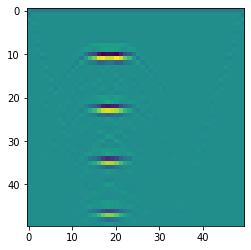

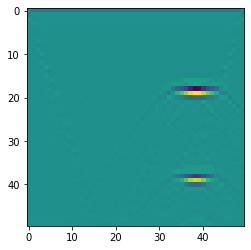

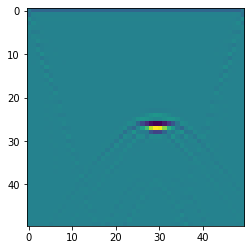

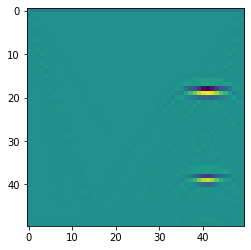

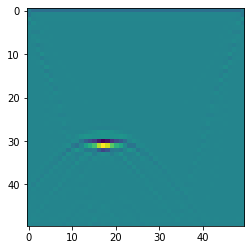

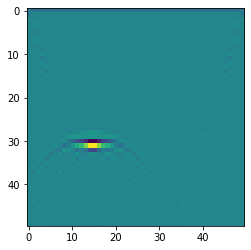

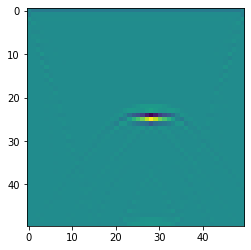

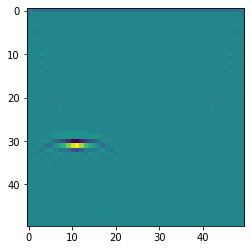

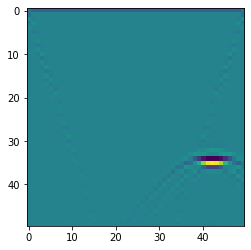

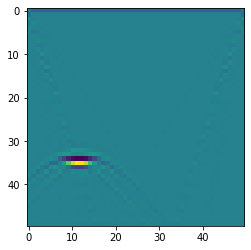

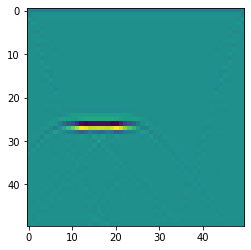

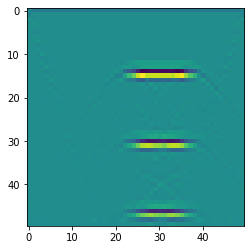

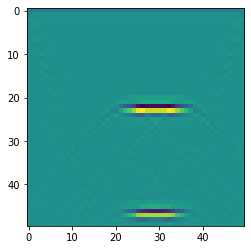

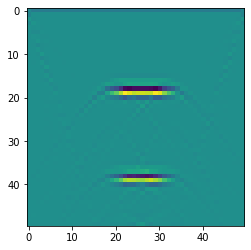

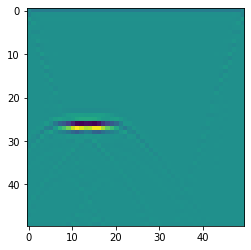

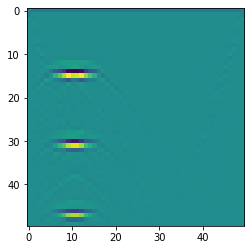

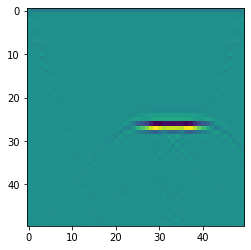

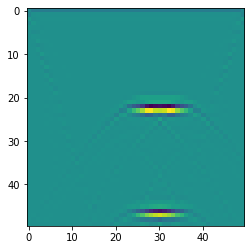

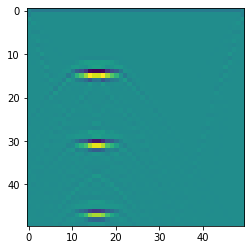

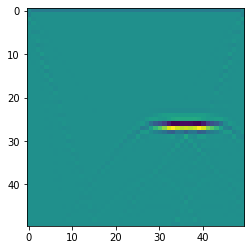

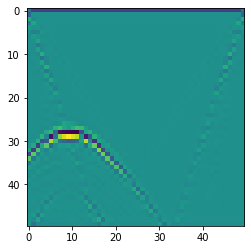

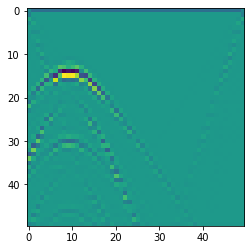

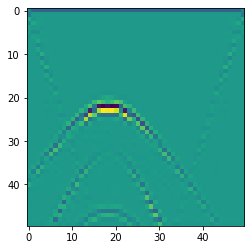

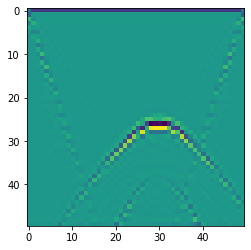

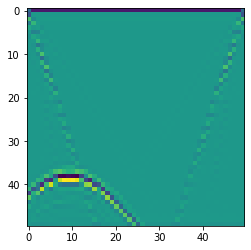

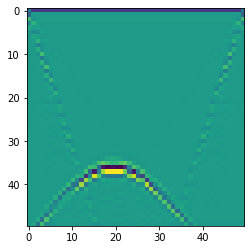

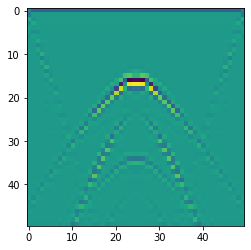

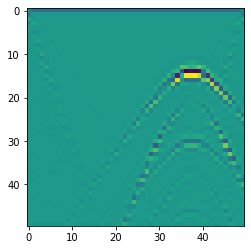

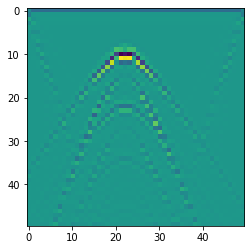

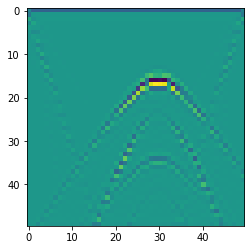

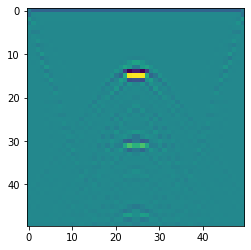

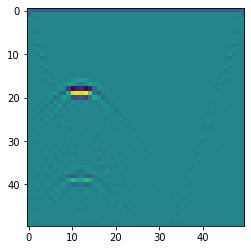

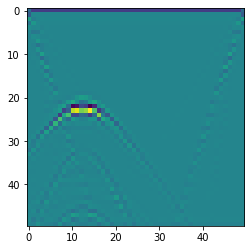

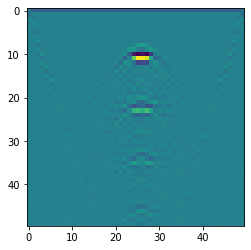

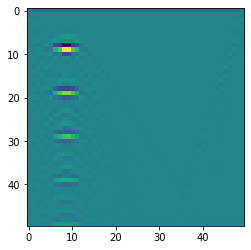

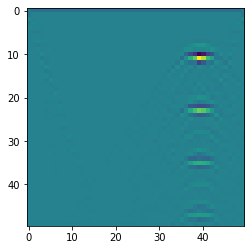

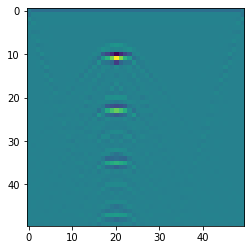

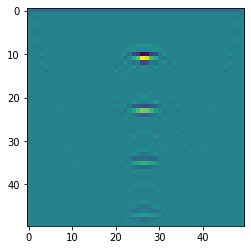

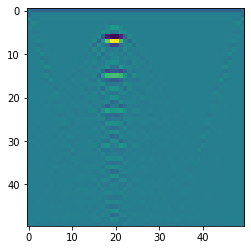

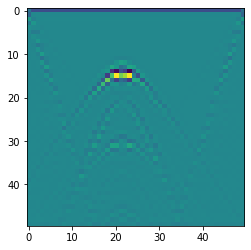

In [7]:
X_valid=[]
Y_valid=[]

Y_valid=Y_valid+[[1,0,0,0]]*70
for file in X_valid_files[1]:
  data=pd.read_csv(os.path.join(fbh_folder_path,file)).values[200:1200,:]
  data=cv2.resize(data, resolution)
  plt.imshow(data)
  plt.show()
  for i in range(7):
    data=imutils.rotate(data,i*30)
    data=data.reshape(Input_shape_cnn)
    X_valid.append(data)

Y_valid=Y_valid+[[0,1,0,0]]*70
for file in X_valid_files[2]:
  data=pd.read_csv(os.path.join(rv_folder_path,file)).values[200:1200,:]
  data=cv2.resize(data, resolution)
  plt.imshow(data)
  plt.show()
  for i in range(7):
    data=imutils.rotate(data,i*30)
    data=data.reshape(Input_shape_cnn)
    X_valid.append(data)

Y_valid=Y_valid+[[0,0,1,0]]*70
for file in X_valid_files[3]:
  data=pd.read_csv(os.path.join(sdh_folder_path,file)).values[200:1200,:]
  data=cv2.resize(data, resolution)
  plt.imshow(data)
  plt.show()
  for i in range(7):
    data=imutils.rotate(data,i*30)
    data=data.reshape(Input_shape_cnn)
    X_valid.append(data)
  

Y_valid=Y_valid+[[0,0,0,1]]*70
for file in X_valid_files[4]:
  data=pd.read_csv(os.path.join(rv2_folder_path,file)).values[200:1200,:]
  data=cv2.resize(data, resolution)
  plt.imshow(data)
  plt.show()
  for i in range(7):
    data=imutils.rotate(data,i*30)
    data=data.reshape(Input_shape_cnn)
    X_valid.append(data)



X_valid=np.array(X_valid)
Y_valid=np.array(Y_valid)

In [8]:
print(X_valid.shape)
print(Y_valid.shape)

(280, 50, 50, 1)
(280, 4)


In [16]:
from keras.models import model_from_json

def validation(model,X_valid,Y_valid):
  accu=0
  val_results =model.predict(X_valid)
  val_results=np.array(val_results)
  for result,label in zip(val_results,Y_valid):
    tmp_result=np.array([0,0,0,0])
    tmp_result[np.argmax(result)]=1
    #print('cnn ouput :{}'.format(result))
    #print('temp results : {}'.format(tmp_result))
    #print('Actual results:{}'.format(label))
    if np.all(np.equal(tmp_result,label)):
      accu+=1
  return (accu/len(X_valid))*100
  

In [10]:
eval_interval = 1
validation_accracy=[]
epochs=200

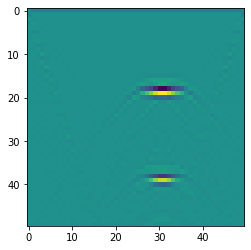

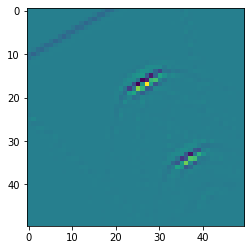

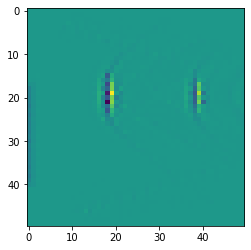

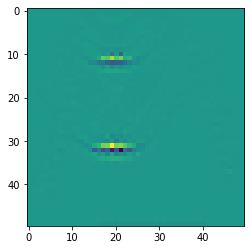

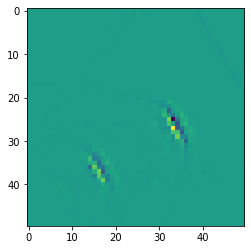

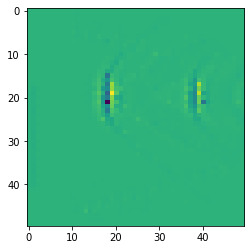

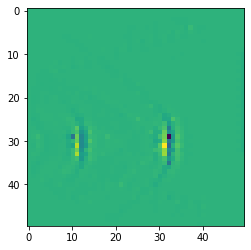

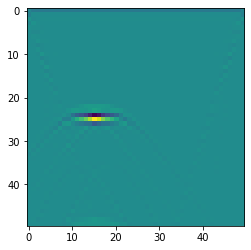

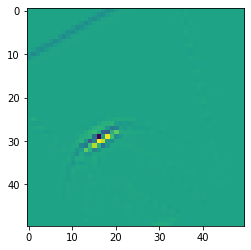

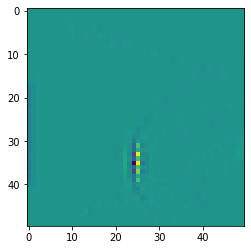

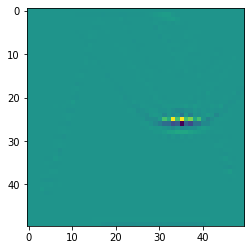

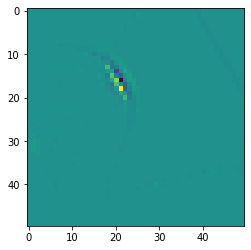

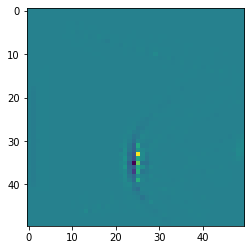

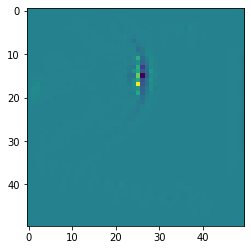

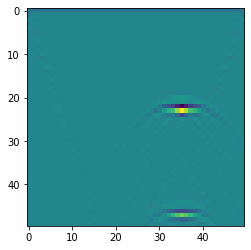

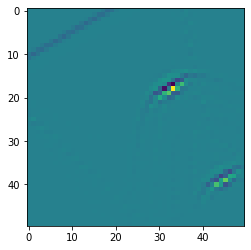

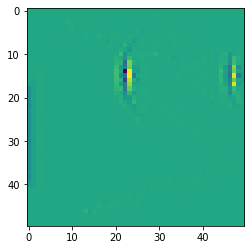

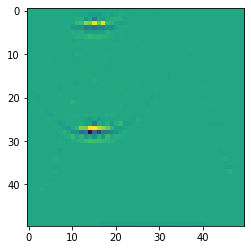

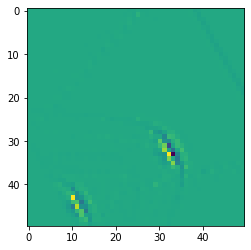

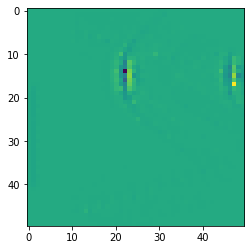

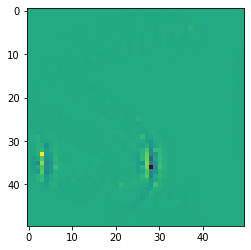

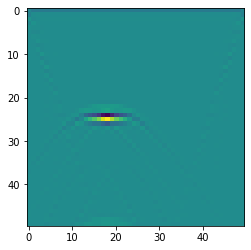

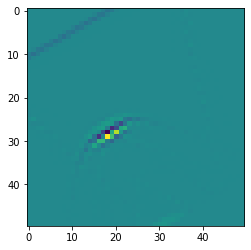

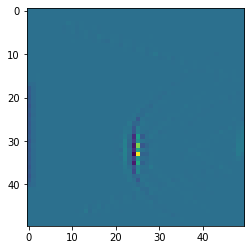

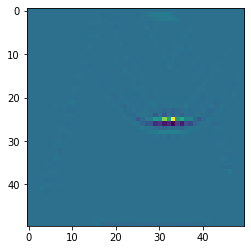

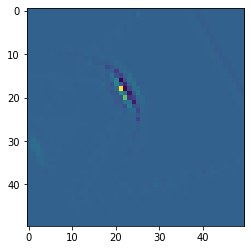

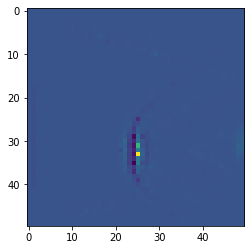

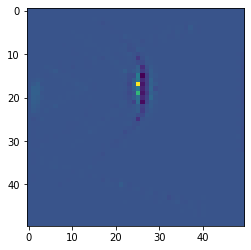

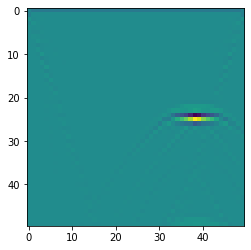

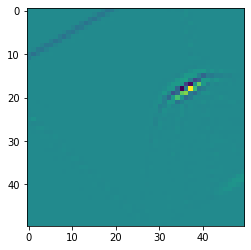

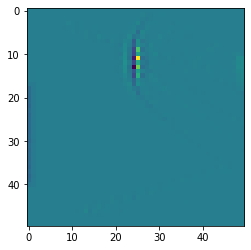

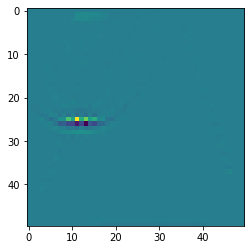

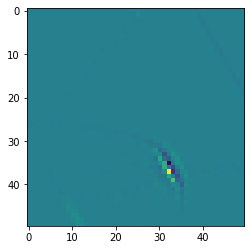

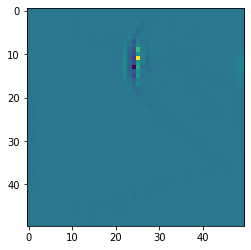

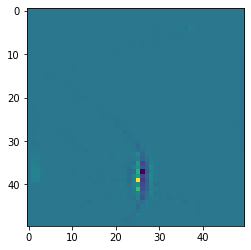

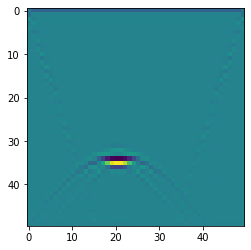

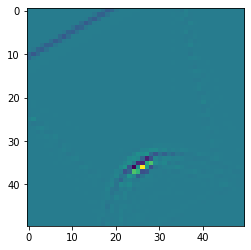

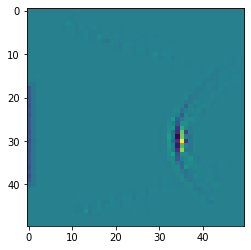

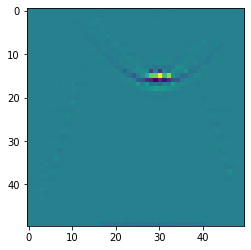

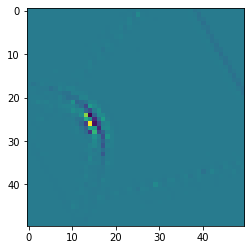

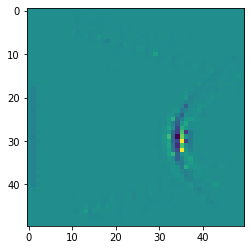

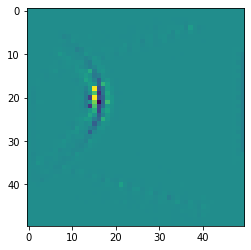

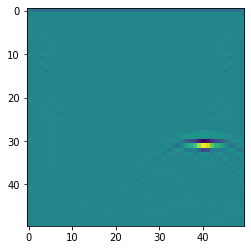

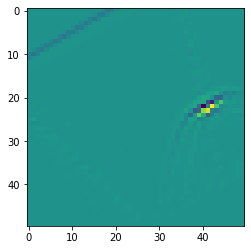

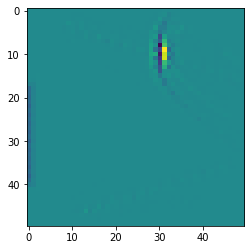

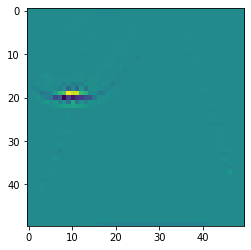

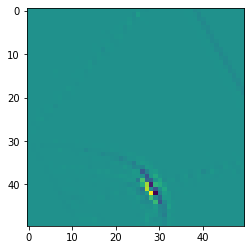

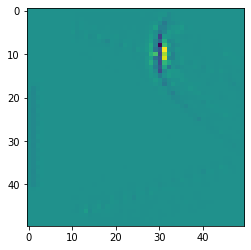

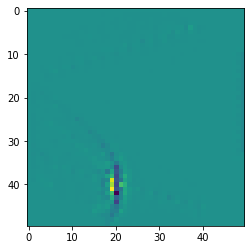

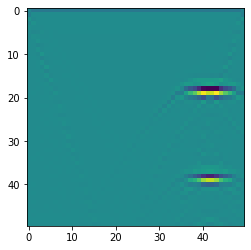

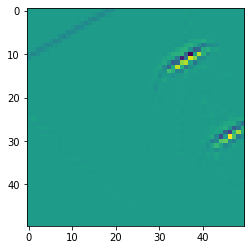

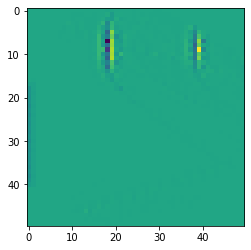

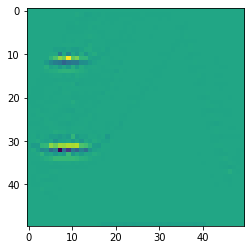

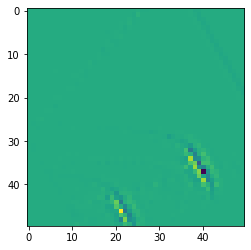

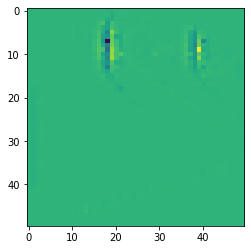

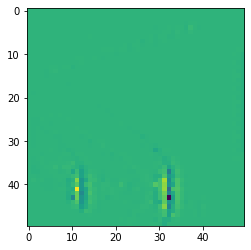

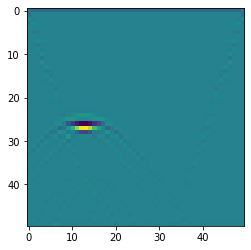

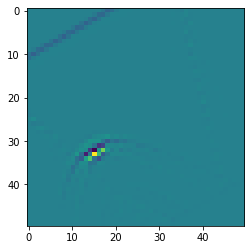

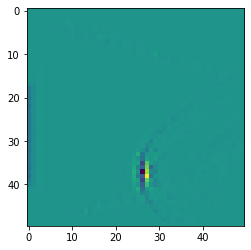

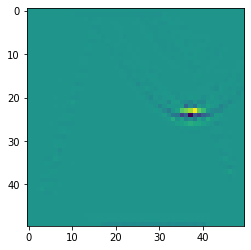

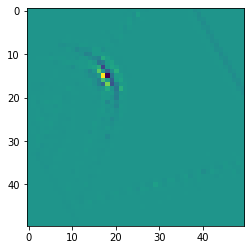

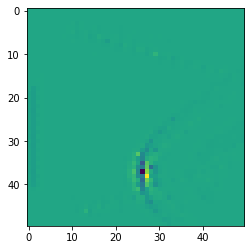

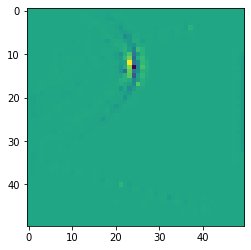

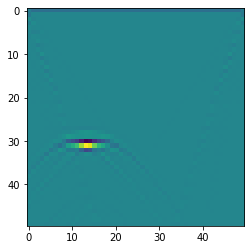

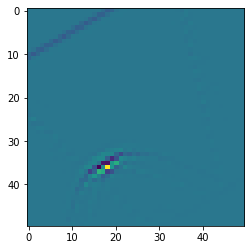

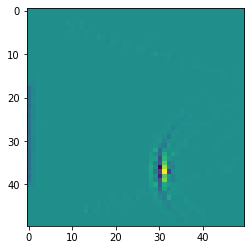

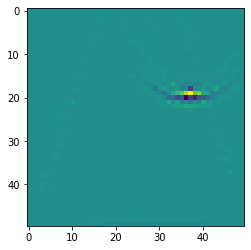

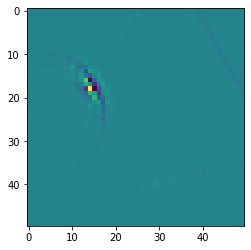

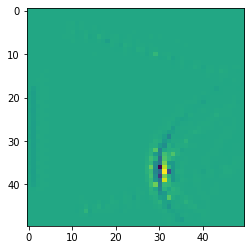

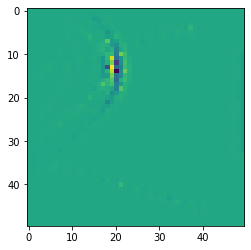

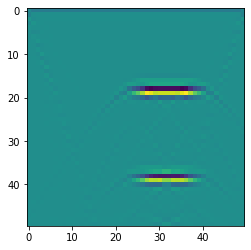

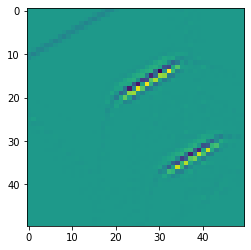

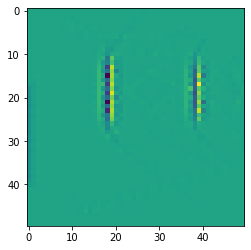

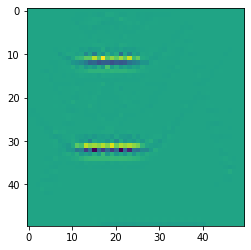

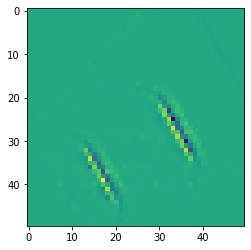

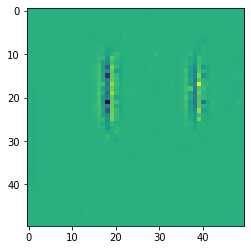

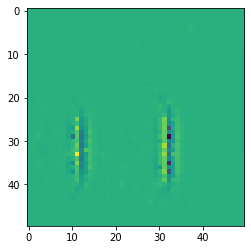

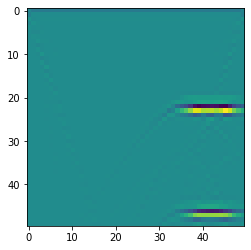

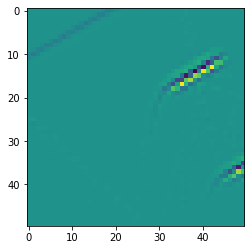

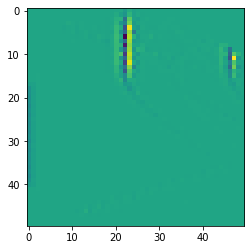

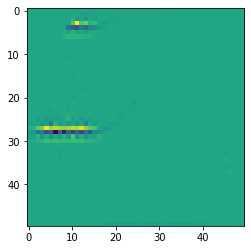

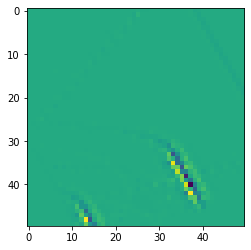

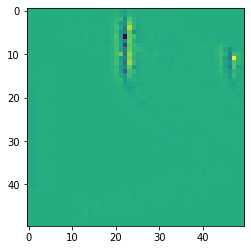

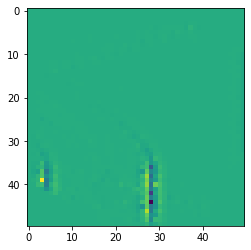

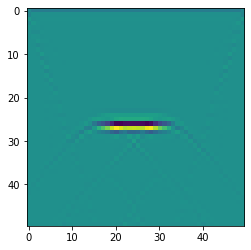

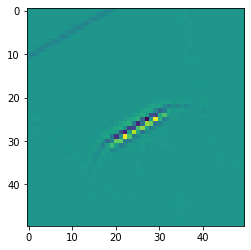

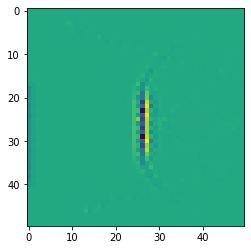

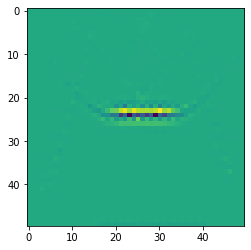

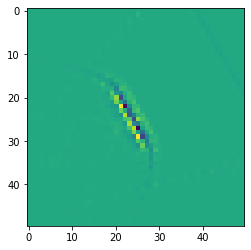

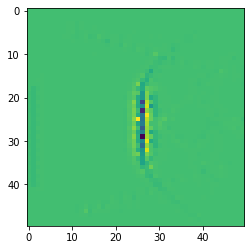

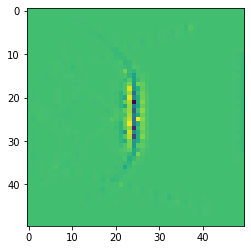

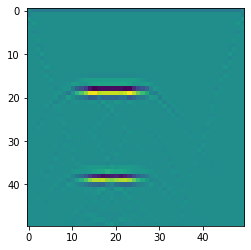

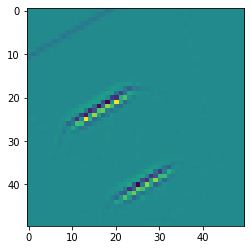

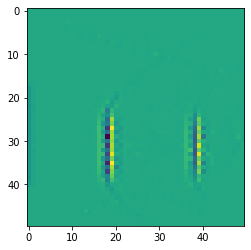

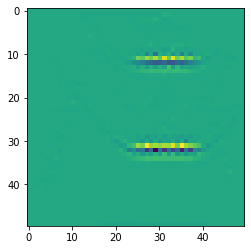

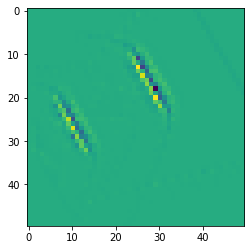

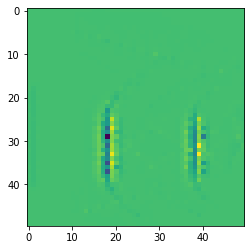

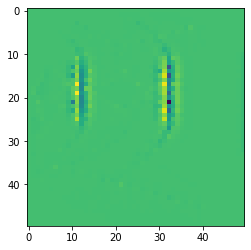

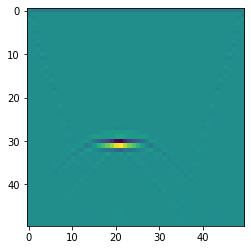

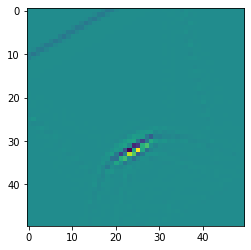

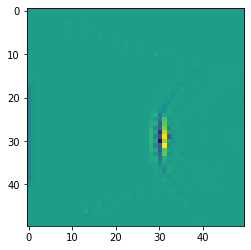

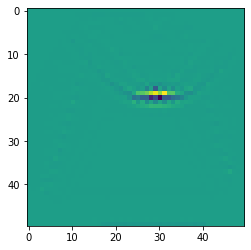

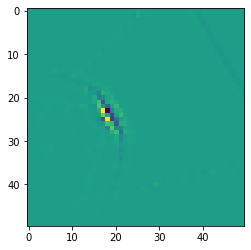

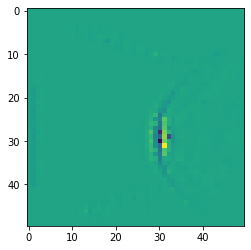

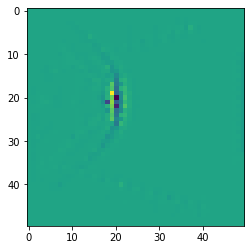

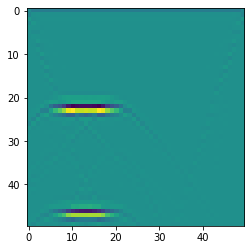

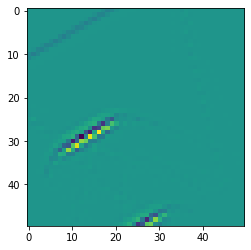

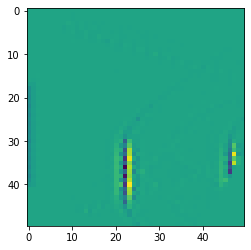

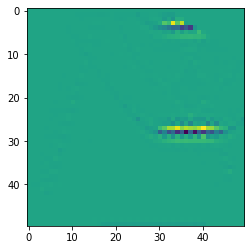

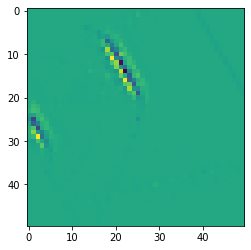

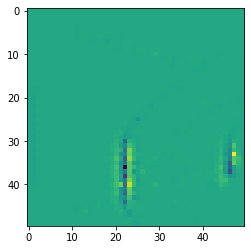

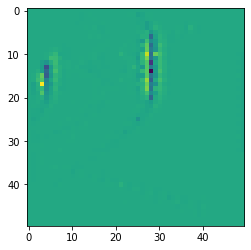

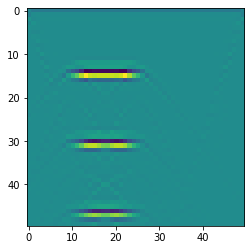

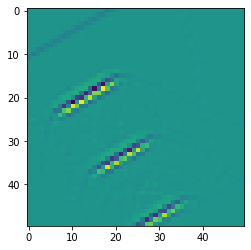

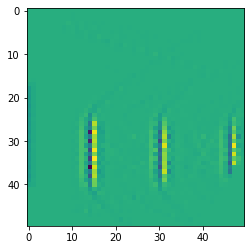

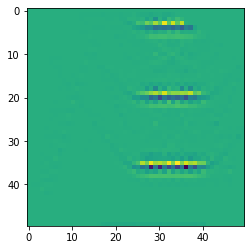

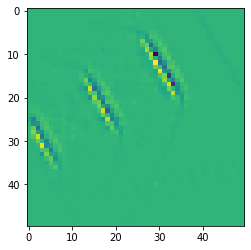

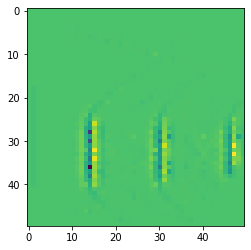

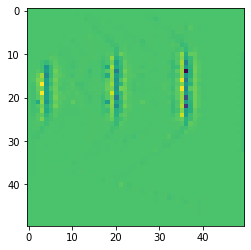

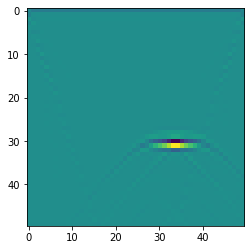

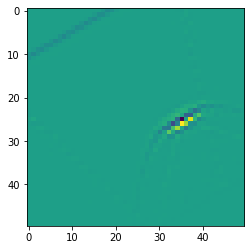

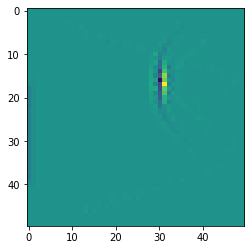

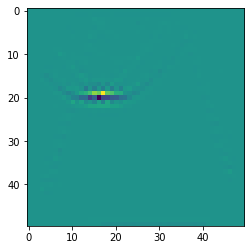

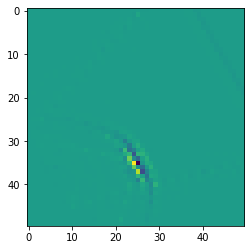

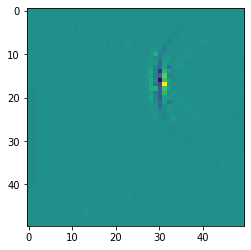

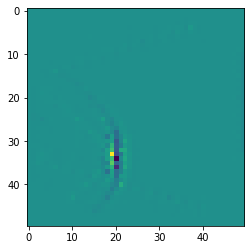

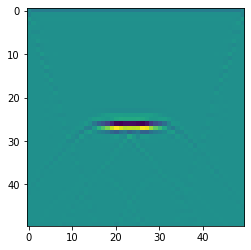

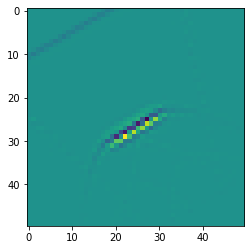

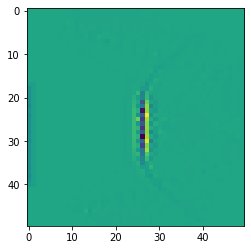

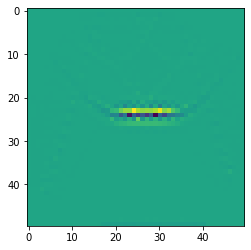

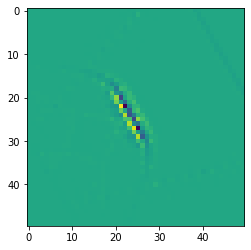

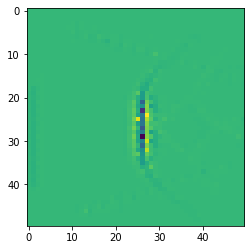

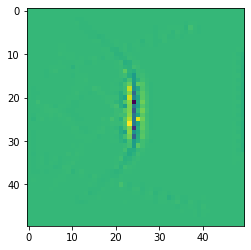

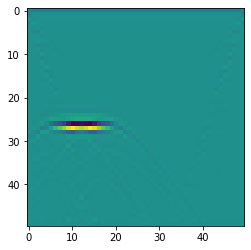

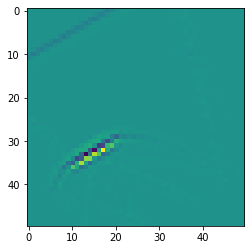

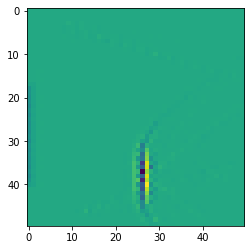

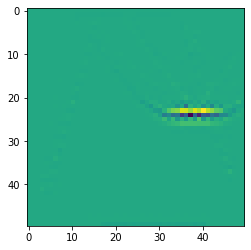

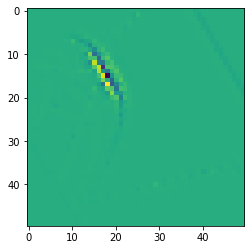

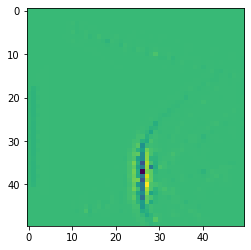

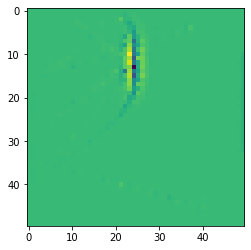

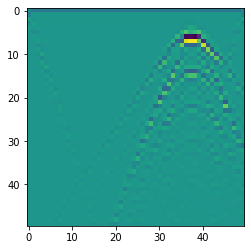

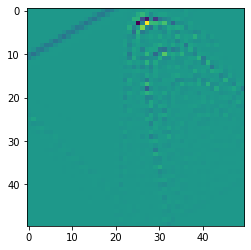

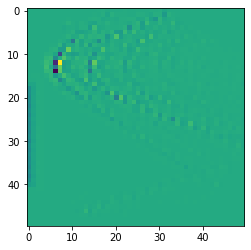

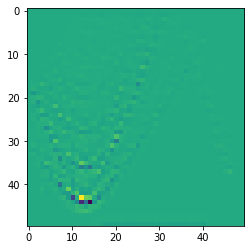

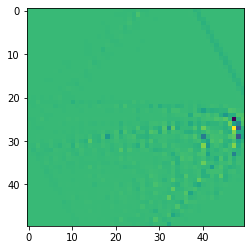

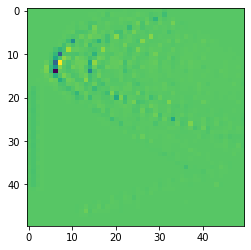

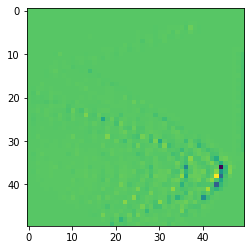

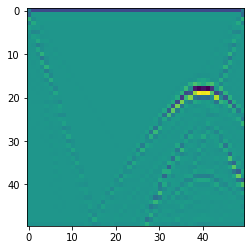

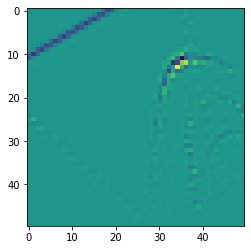

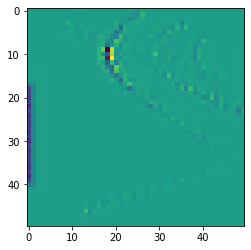

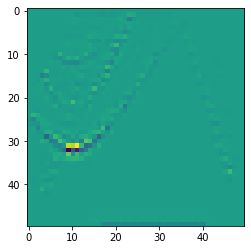

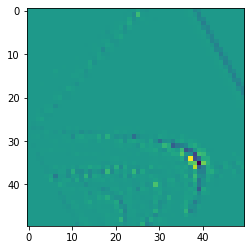

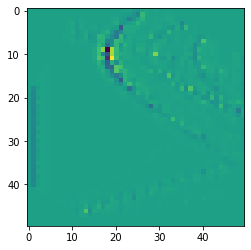

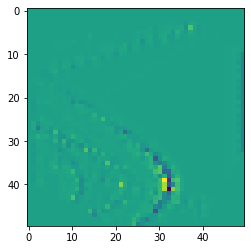

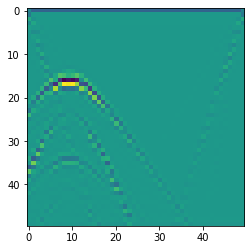

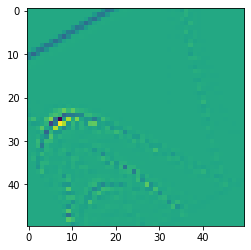

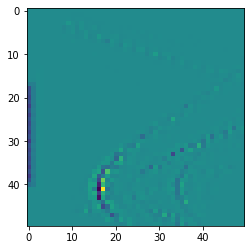

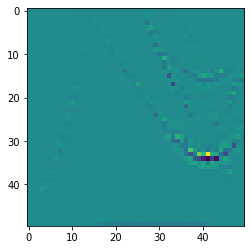

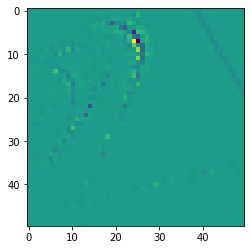

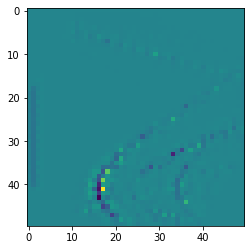

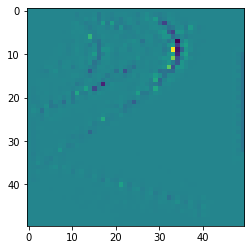

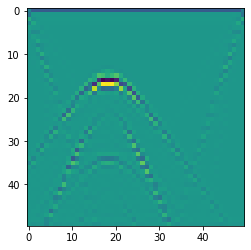

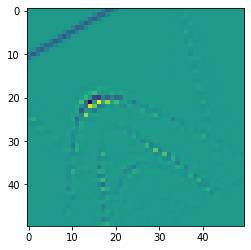

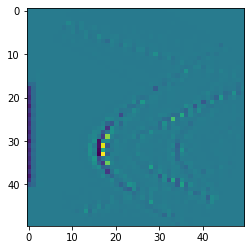

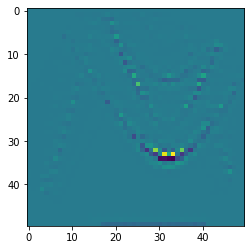

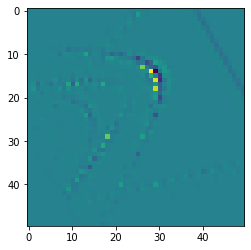

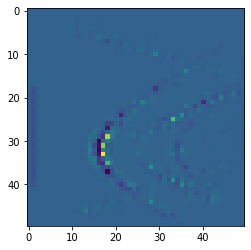

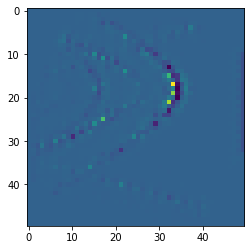

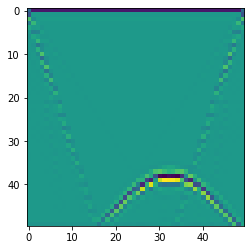

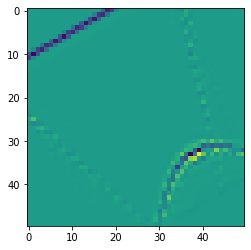

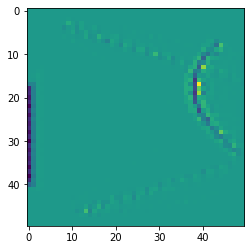

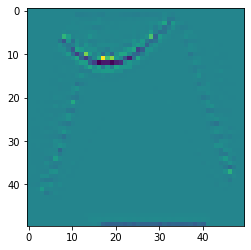

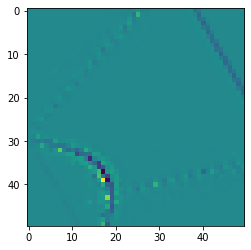

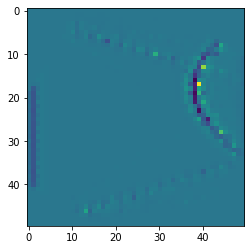

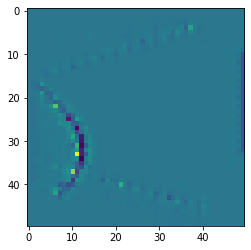

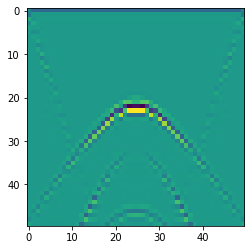

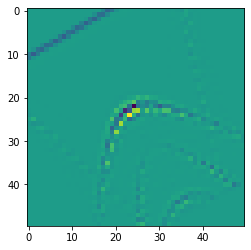

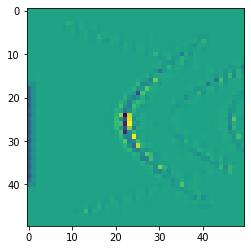

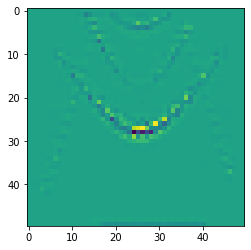

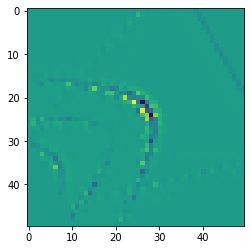

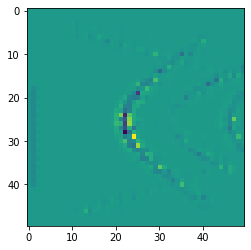

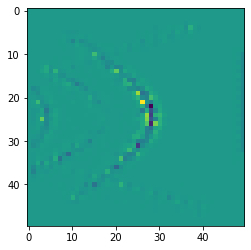

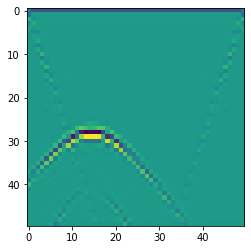

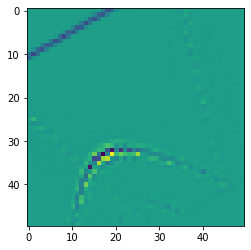

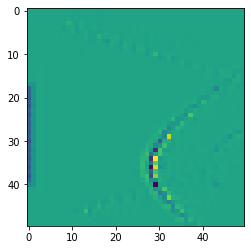

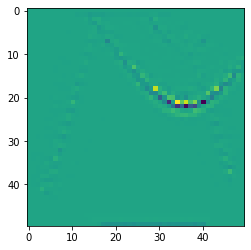

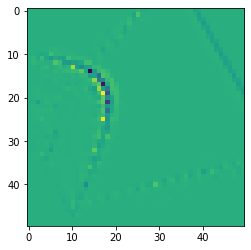

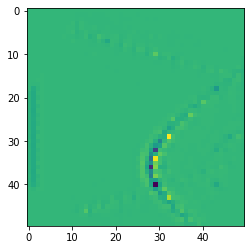

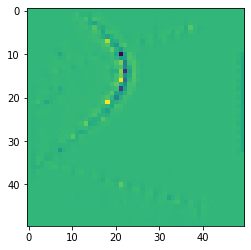

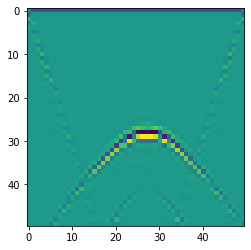

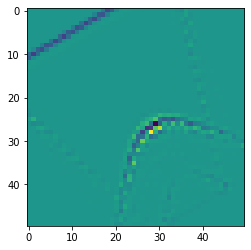

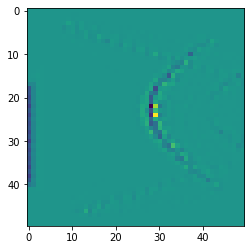

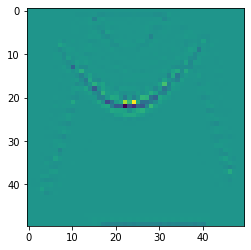

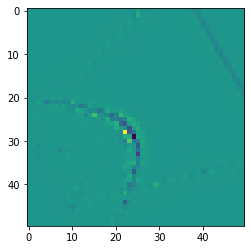

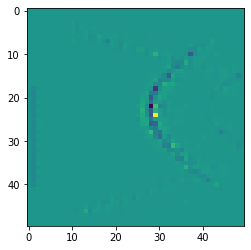

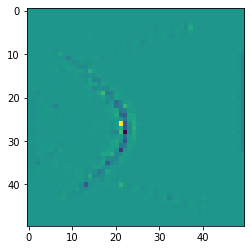

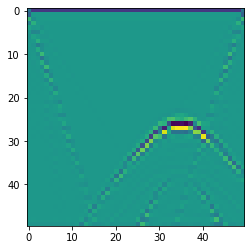

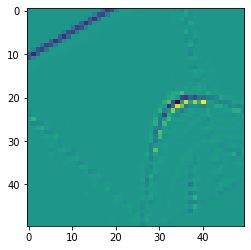

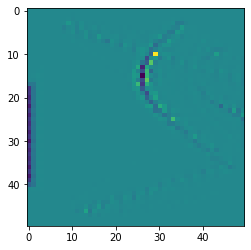

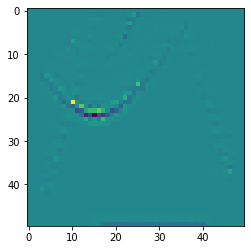

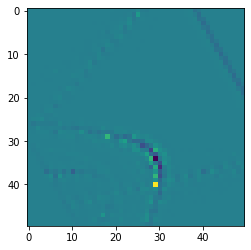

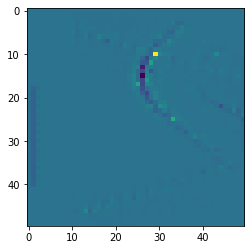

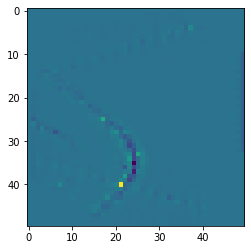

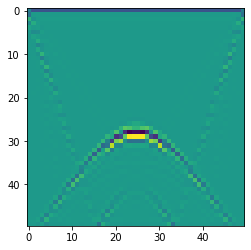

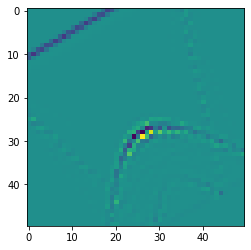

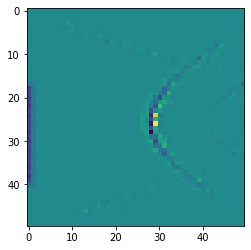

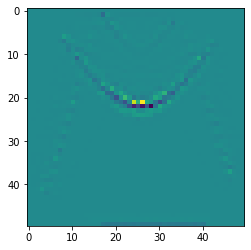

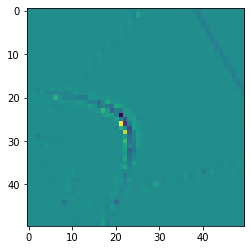

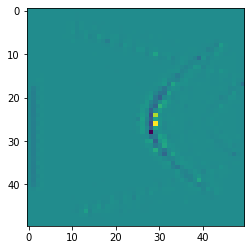

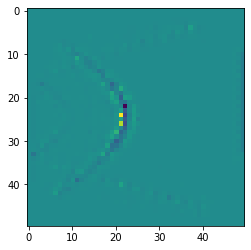

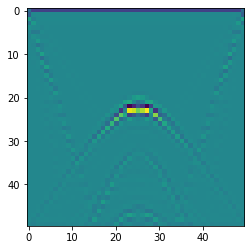

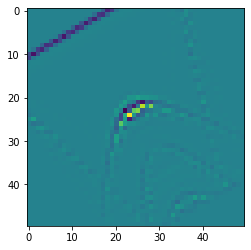

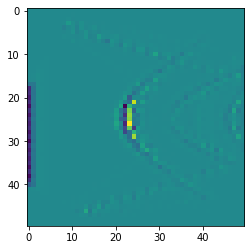

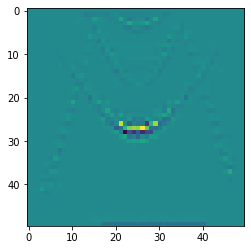

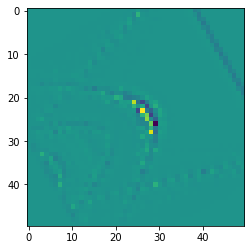

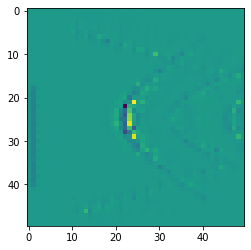

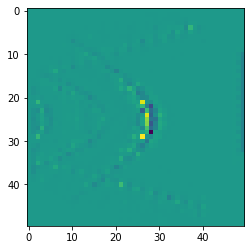

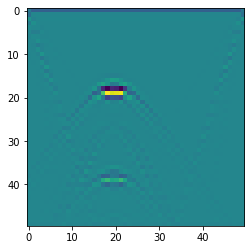

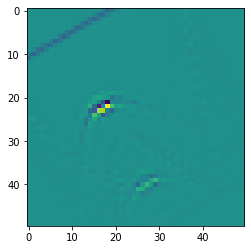

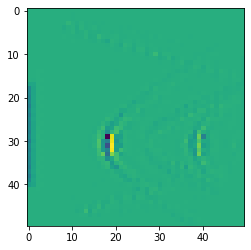

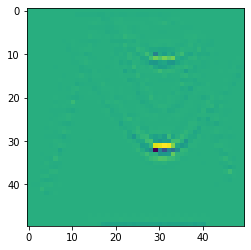

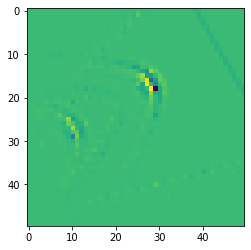

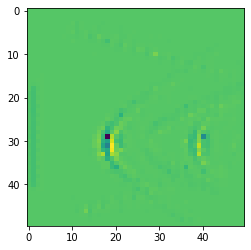

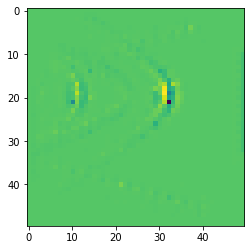

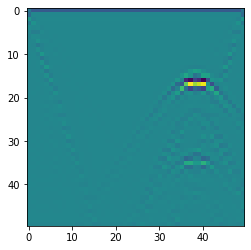

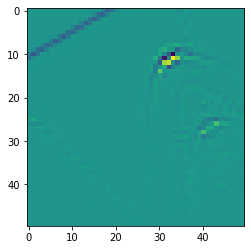

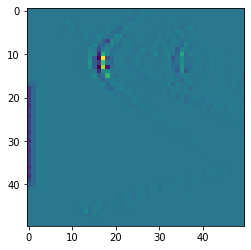

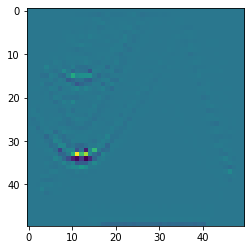

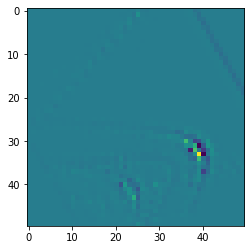

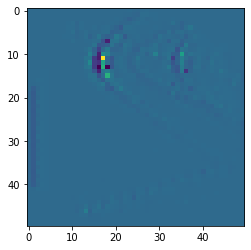

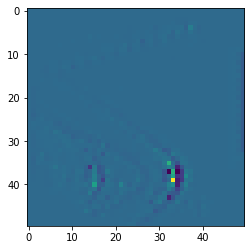

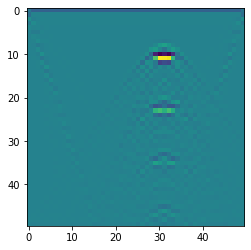

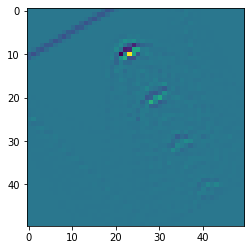

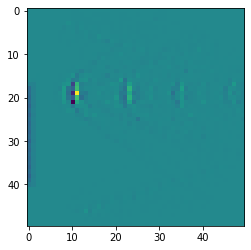

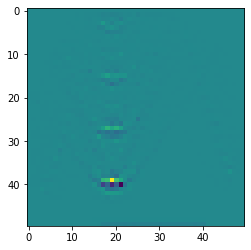

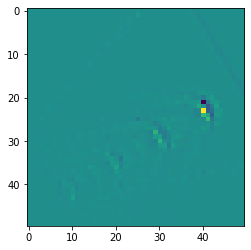

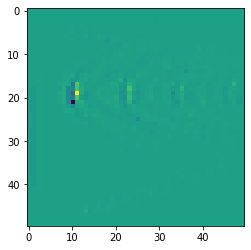

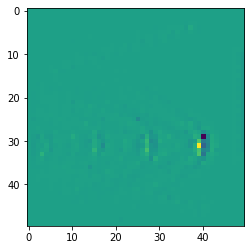

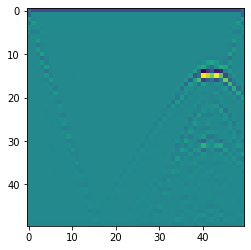

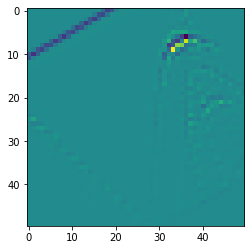

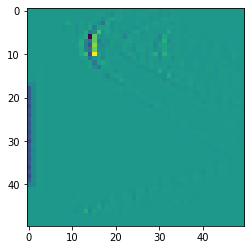

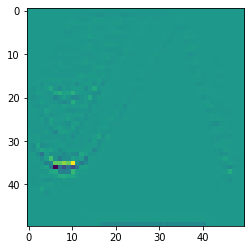

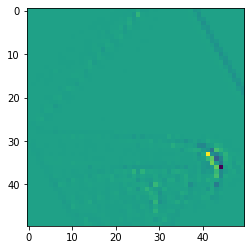

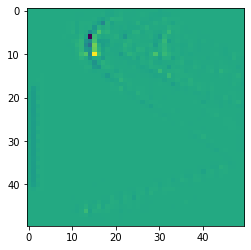

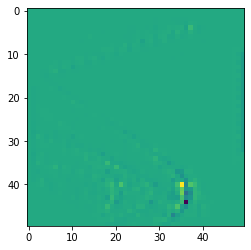

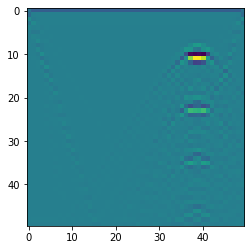

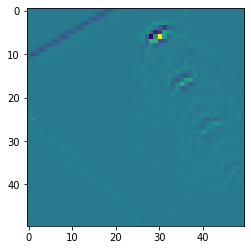

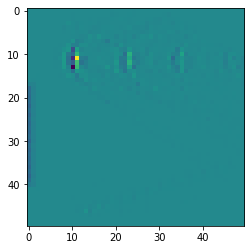

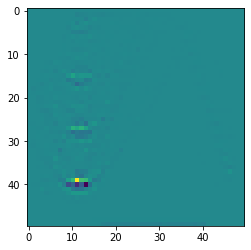

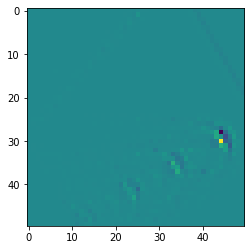

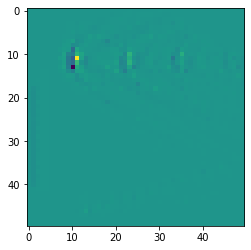

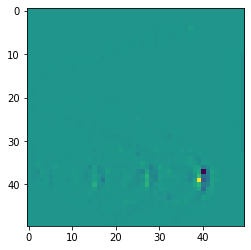

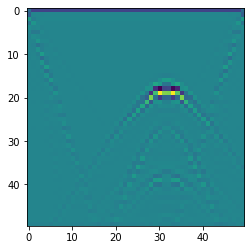

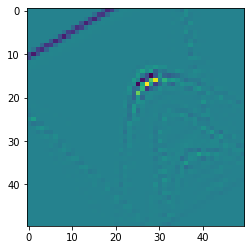

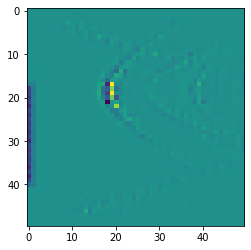

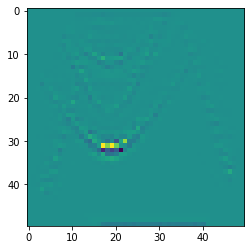

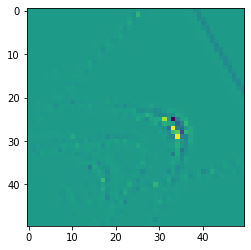

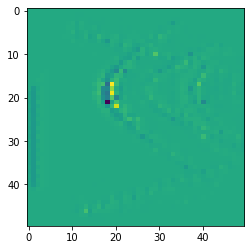

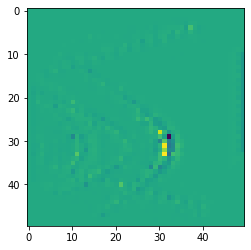

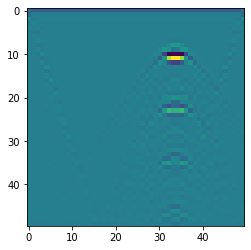

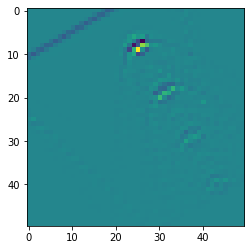

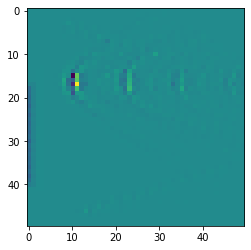

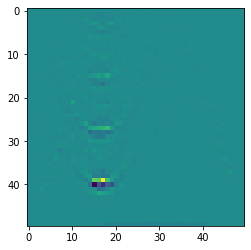

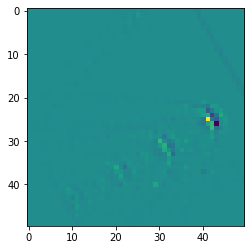

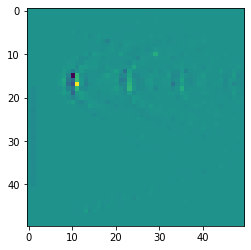

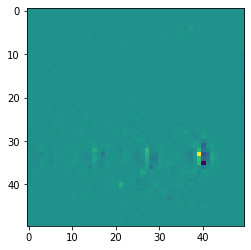

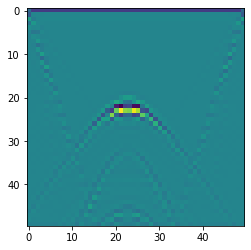

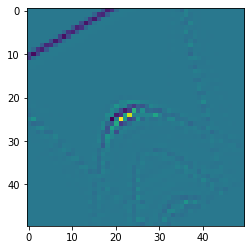

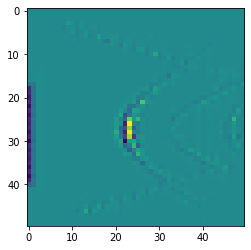

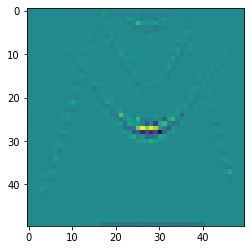

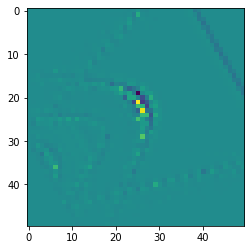

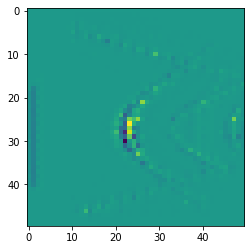

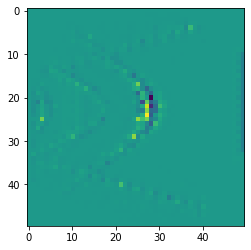

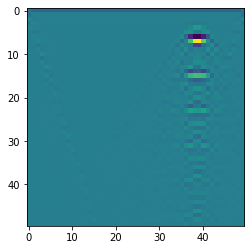

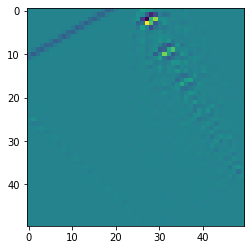

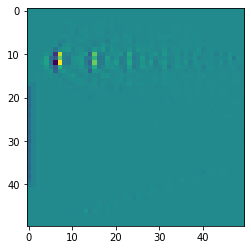

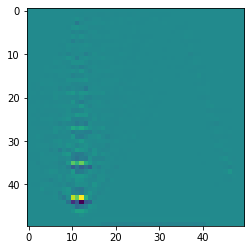

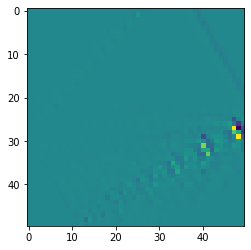

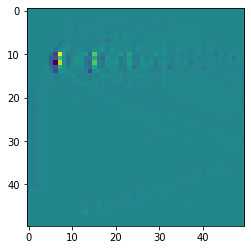

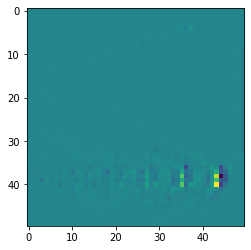

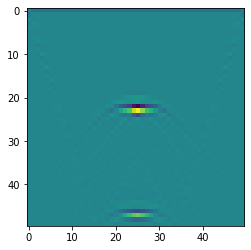

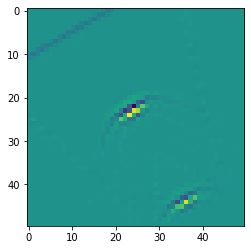

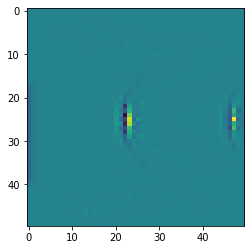

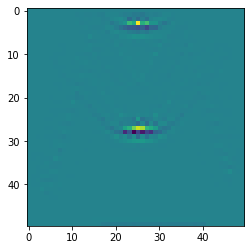

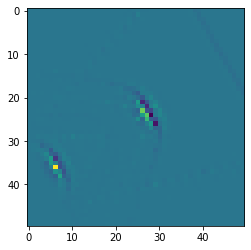

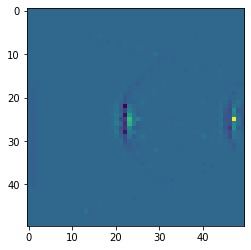

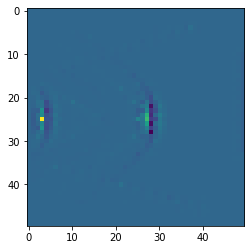

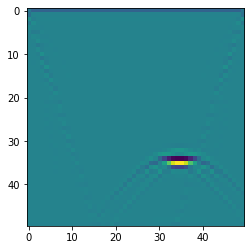

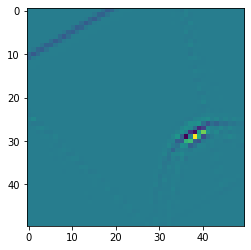

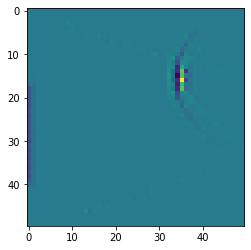

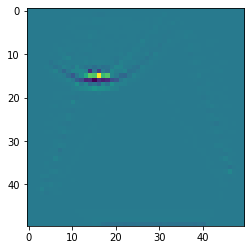

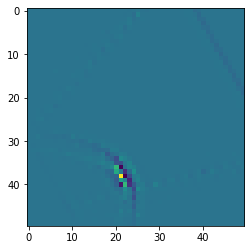

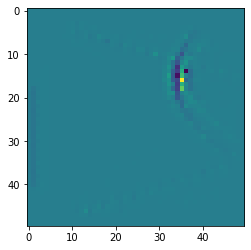

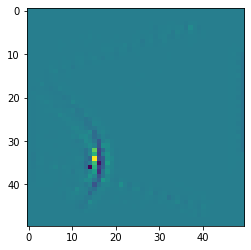

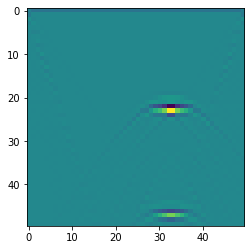

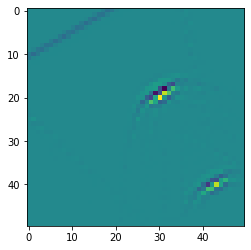

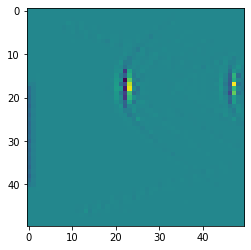

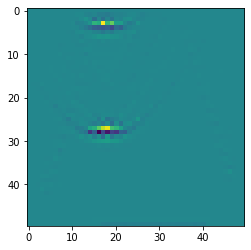

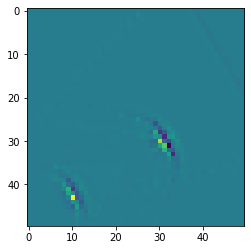

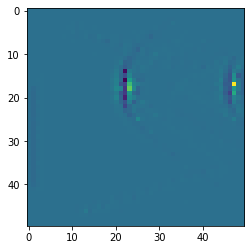

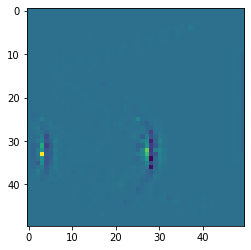

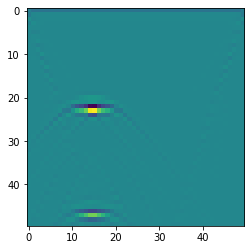

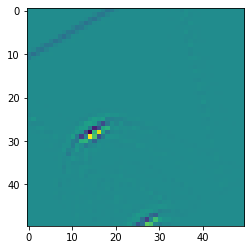

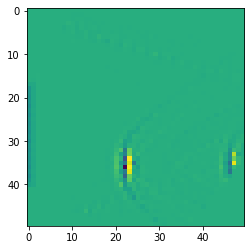

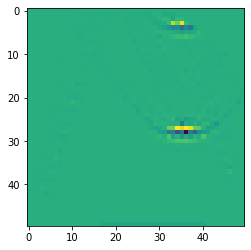

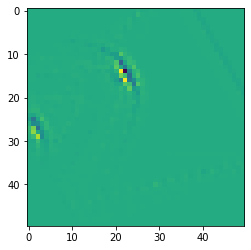

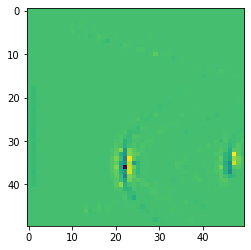

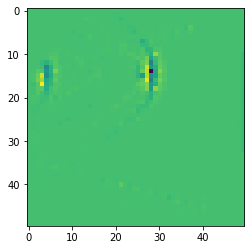

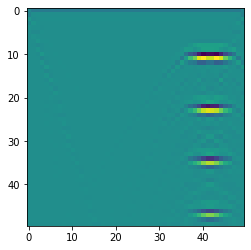

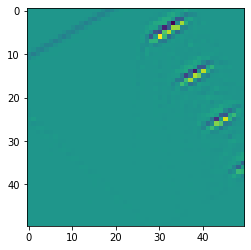

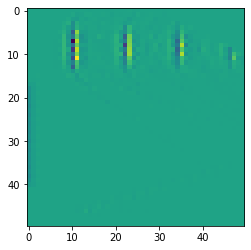

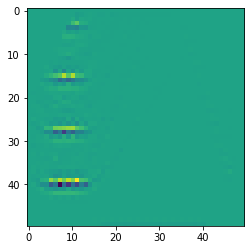

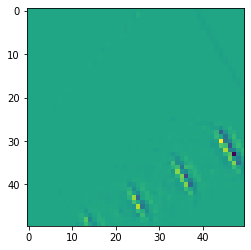

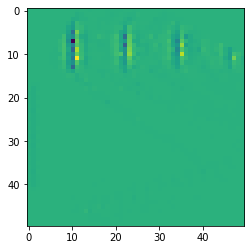

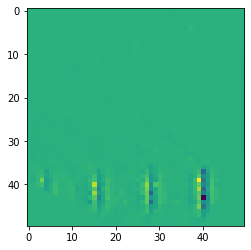

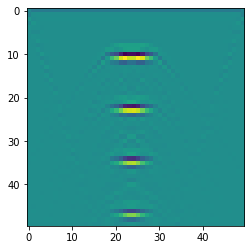

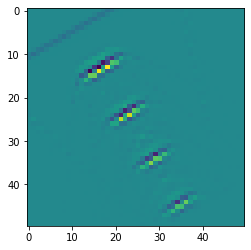

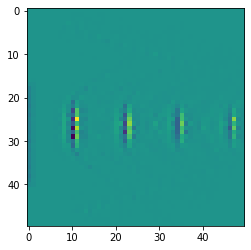

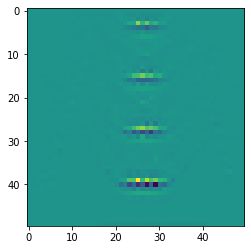

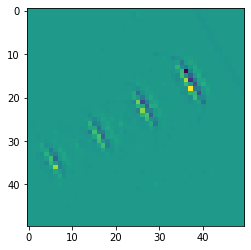

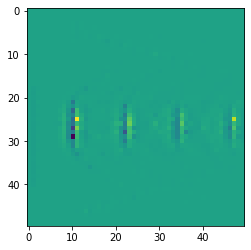

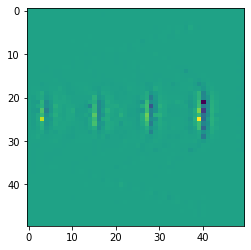

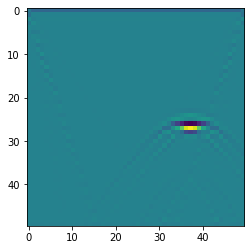

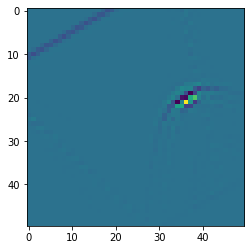

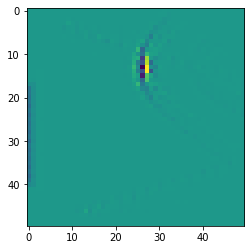

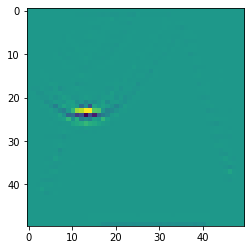

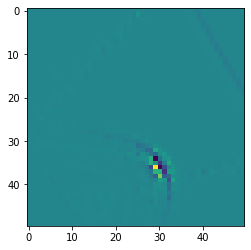

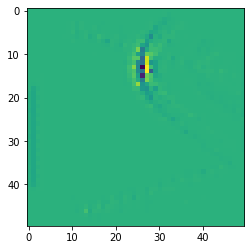

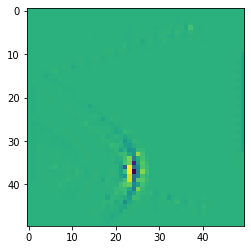

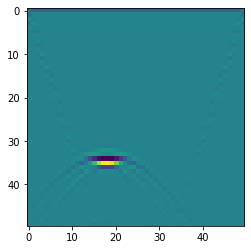

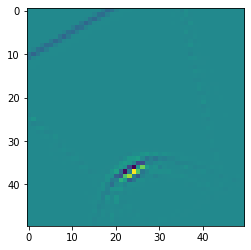

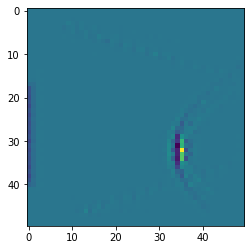

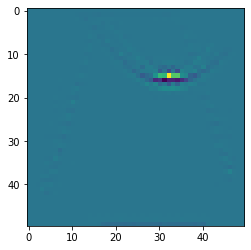

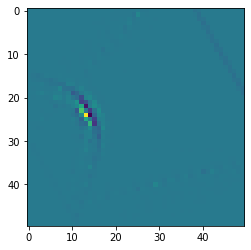

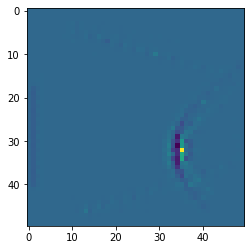

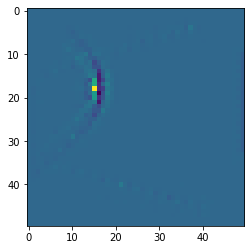

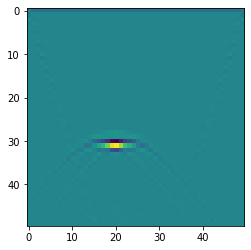

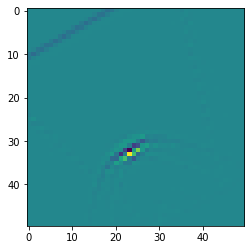

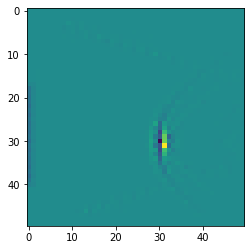

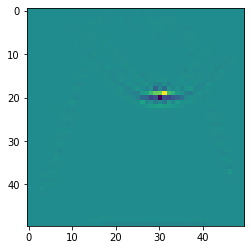

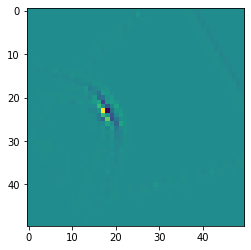

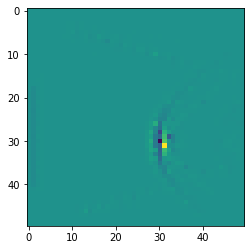

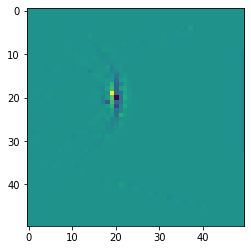

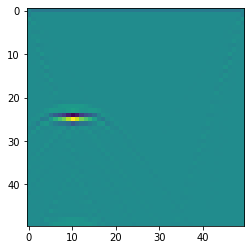

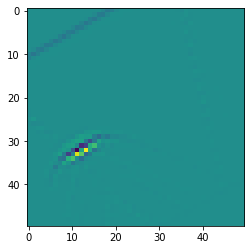

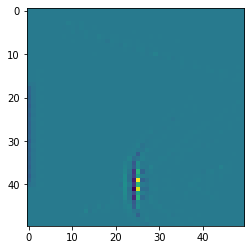

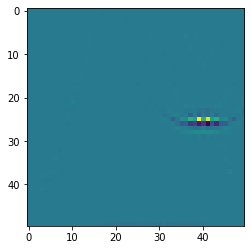

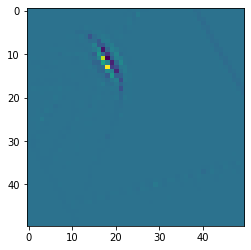

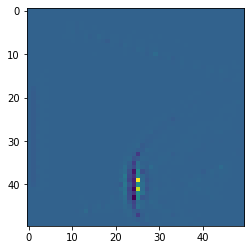

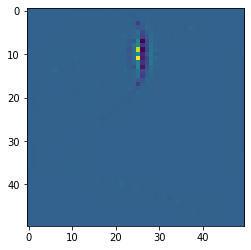

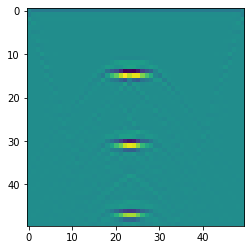

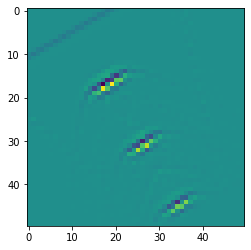

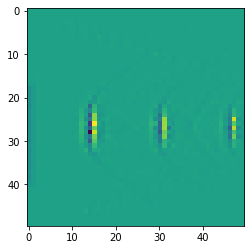

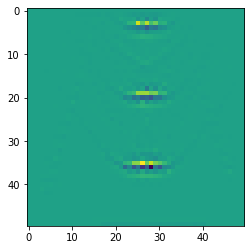

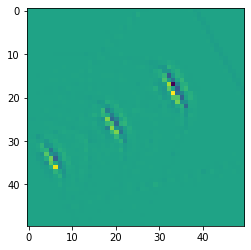

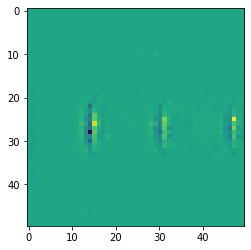

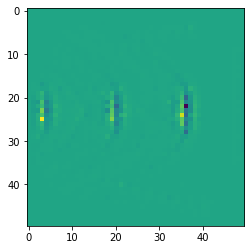

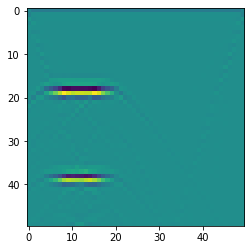

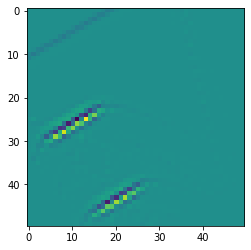

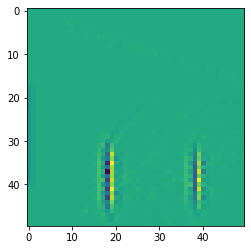

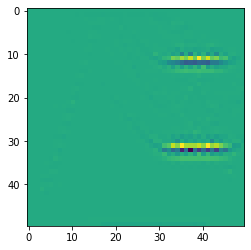

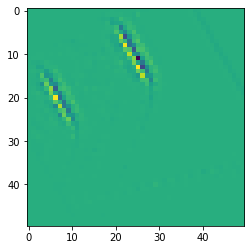

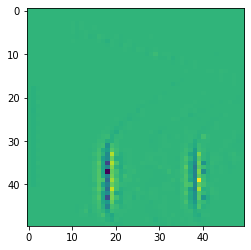

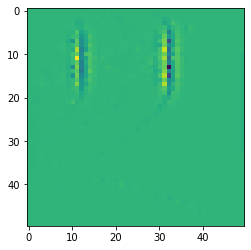

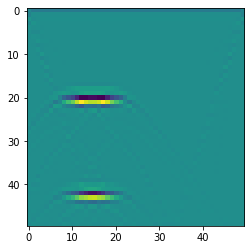

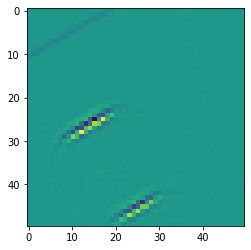

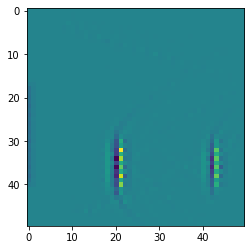

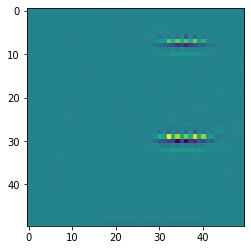

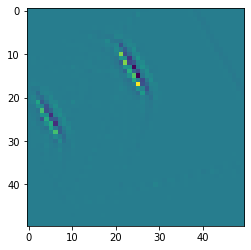

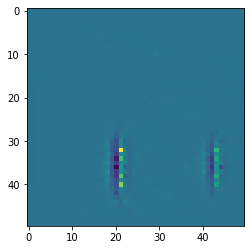

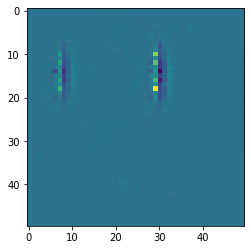

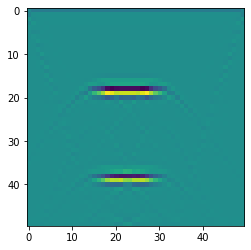

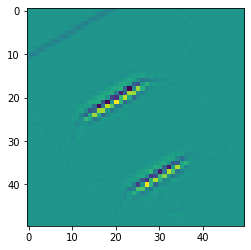

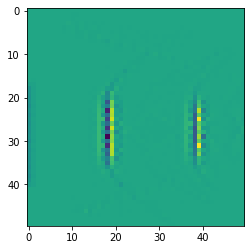

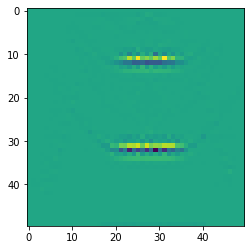

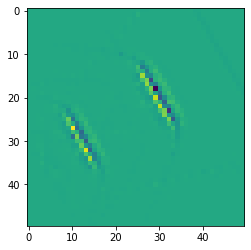

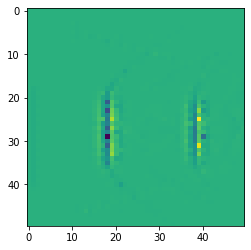

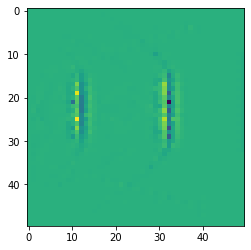

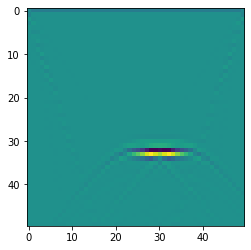

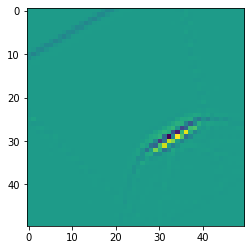

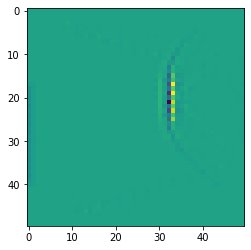

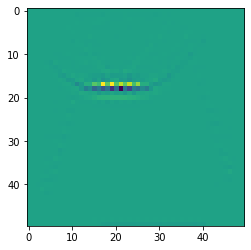

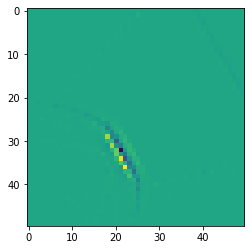

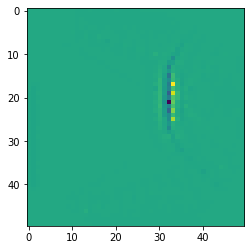

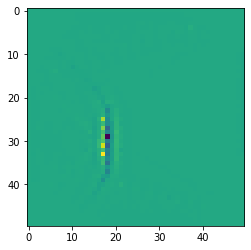

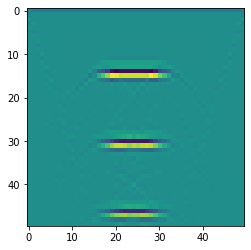

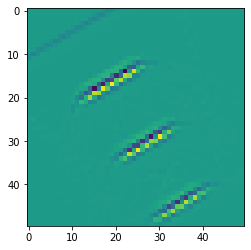

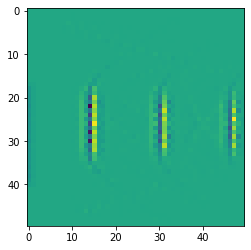

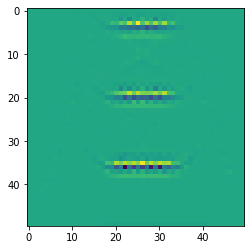

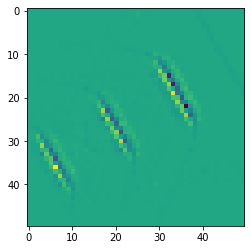

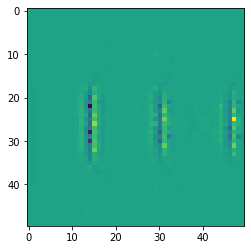

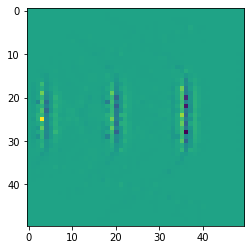

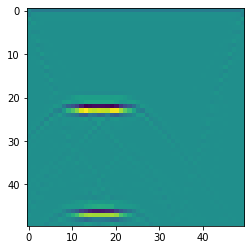

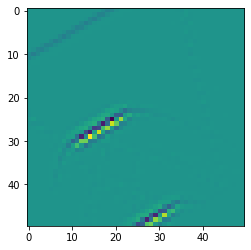

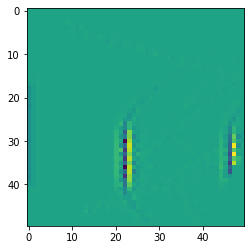

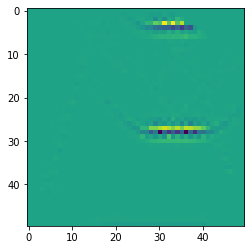

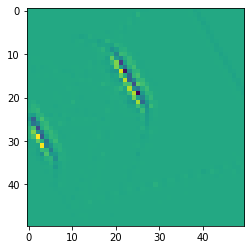

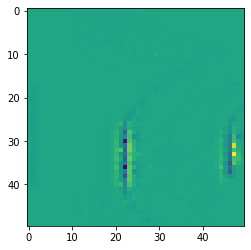

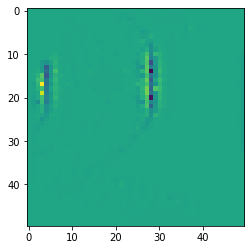

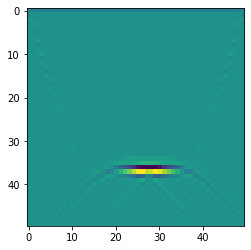

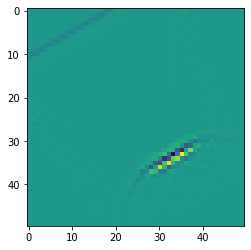

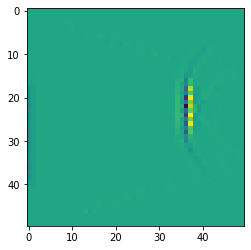

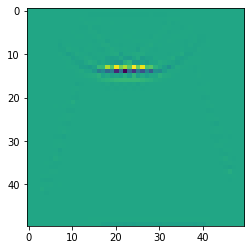

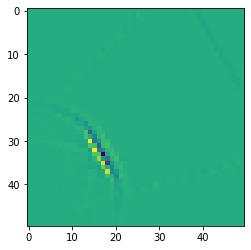

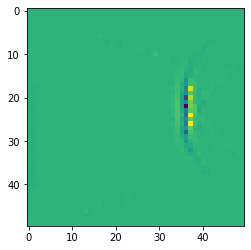

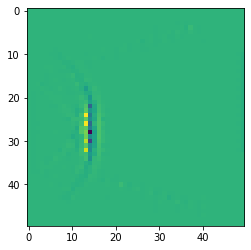

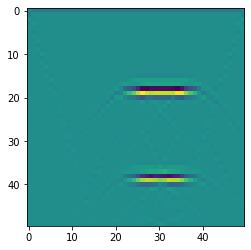

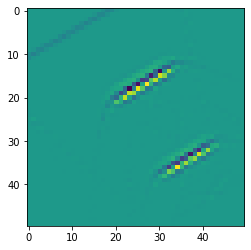

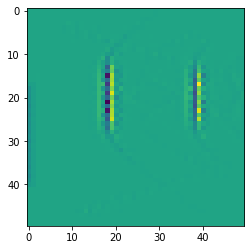

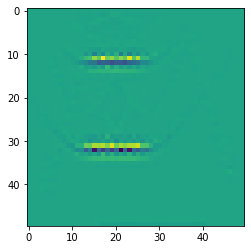

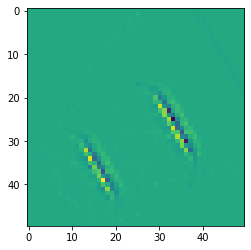

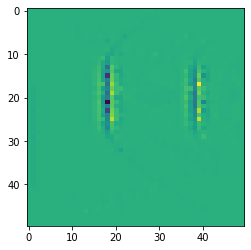

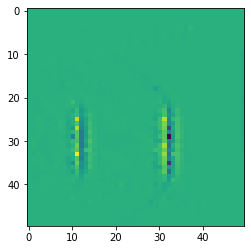

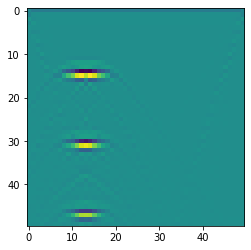

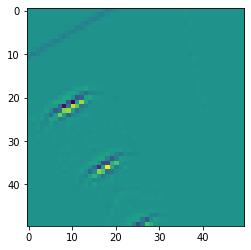

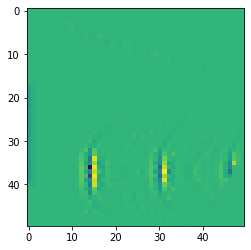

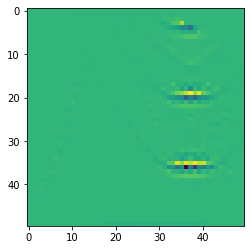

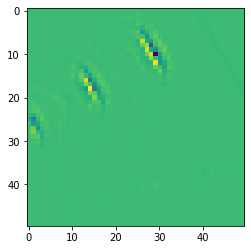

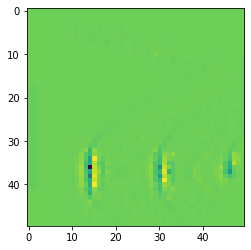

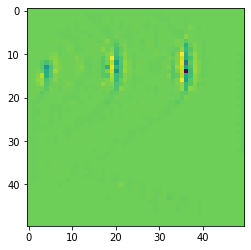

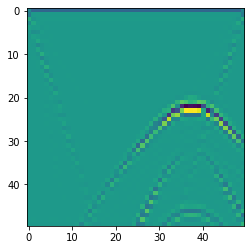

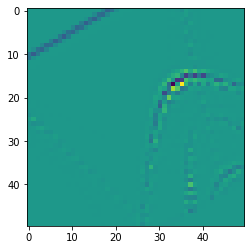

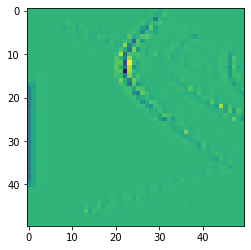

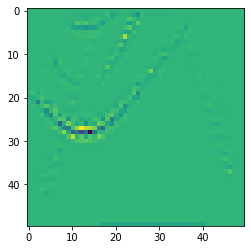

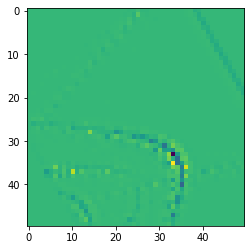

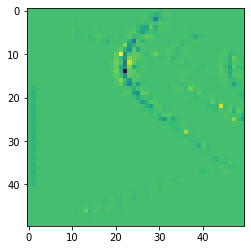

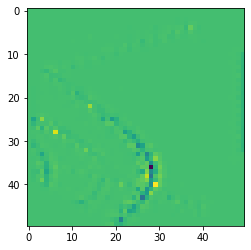

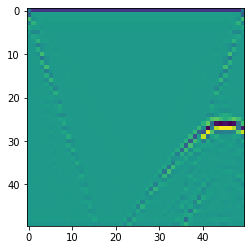

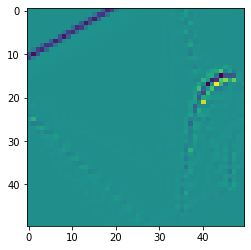

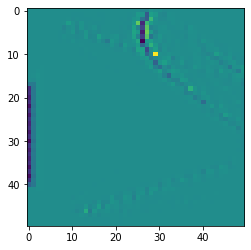

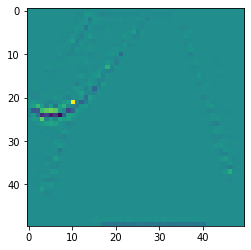

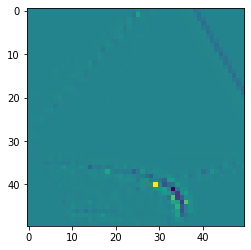

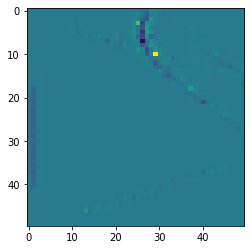

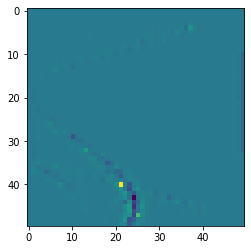

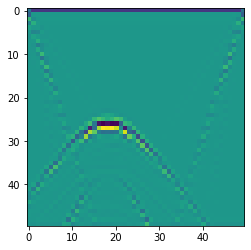

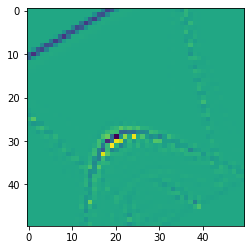

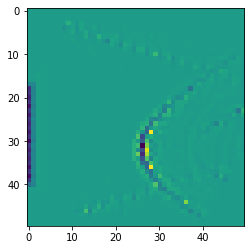

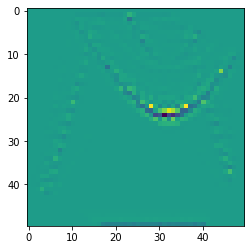

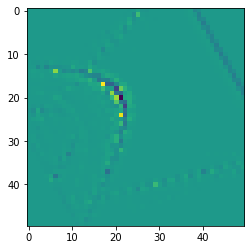

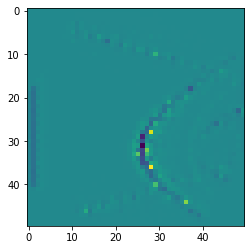

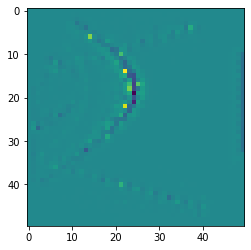

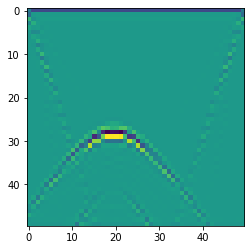

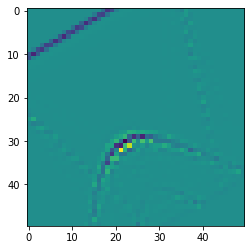

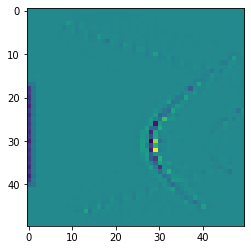

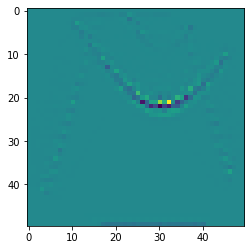

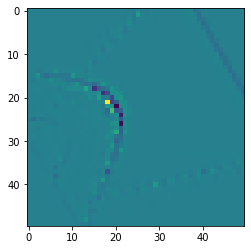

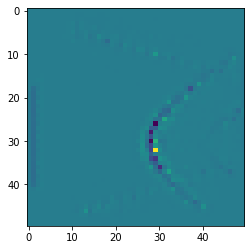

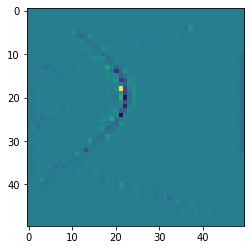

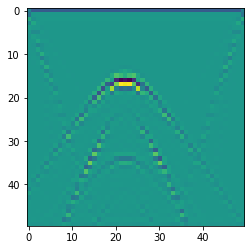

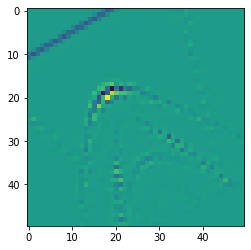

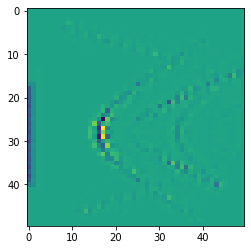

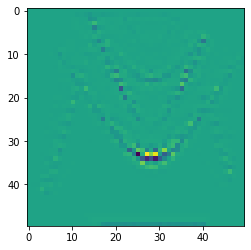

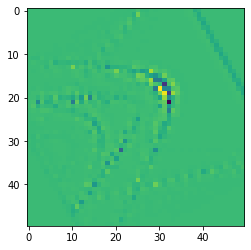

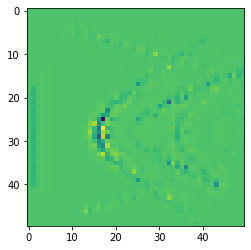

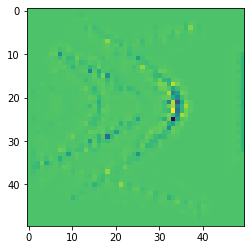

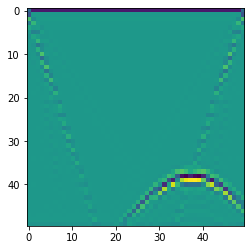

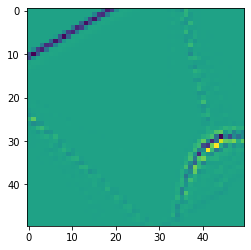

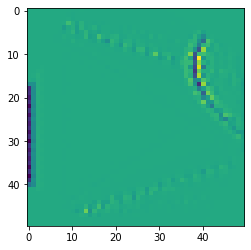

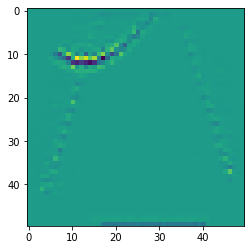

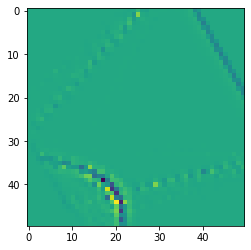

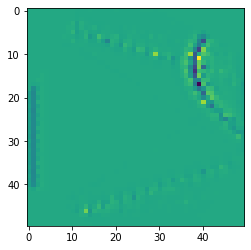

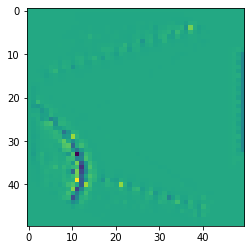

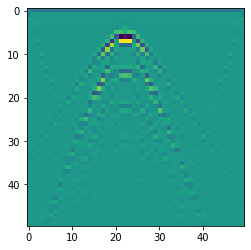

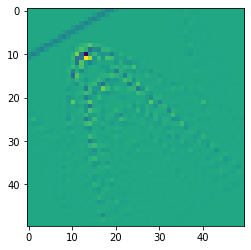

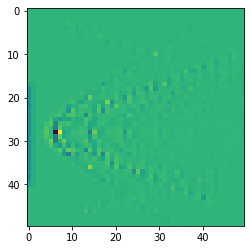

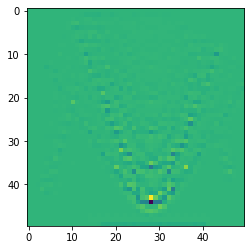

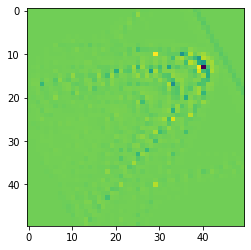

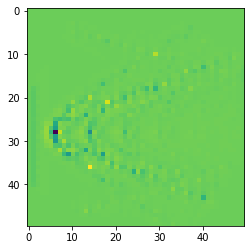

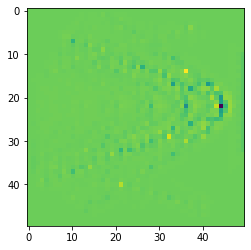

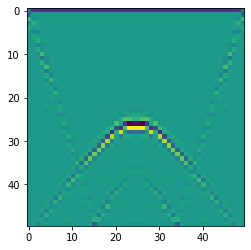

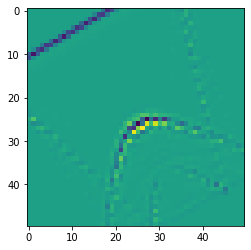

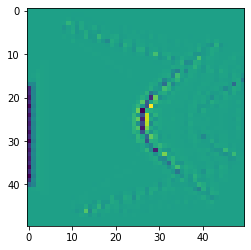

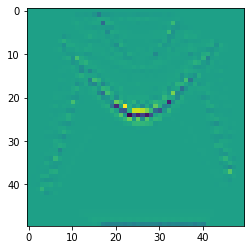

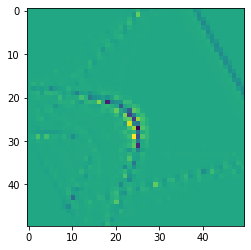

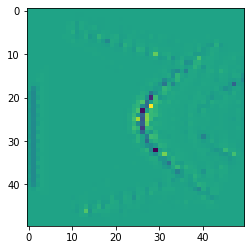

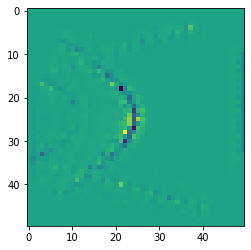

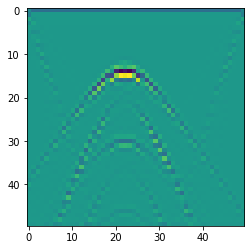

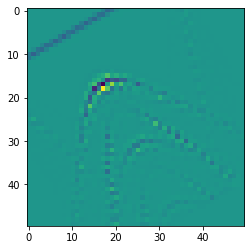

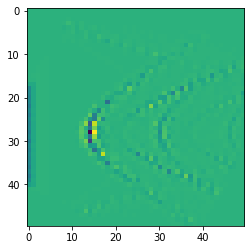

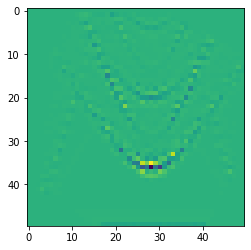

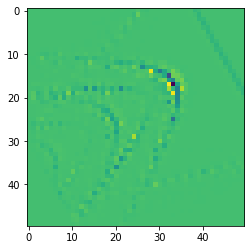

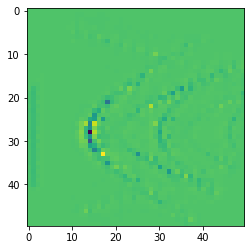

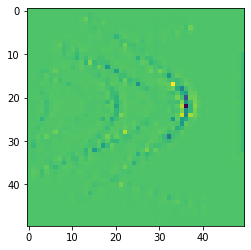

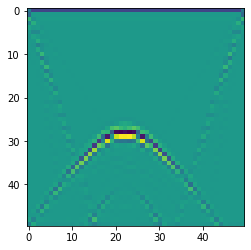

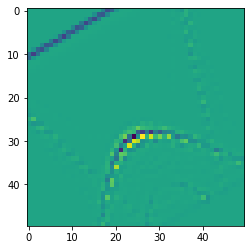

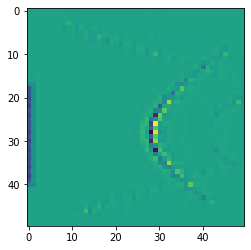

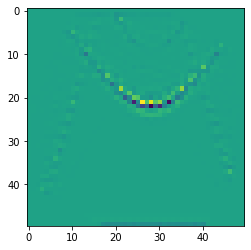

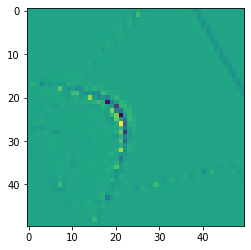

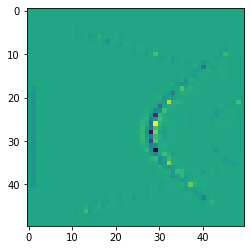

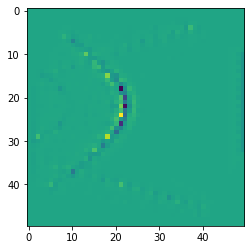

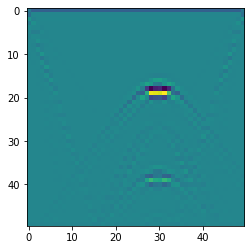

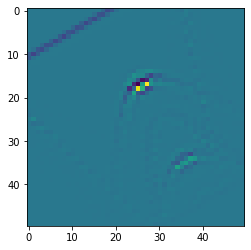

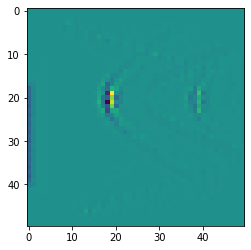

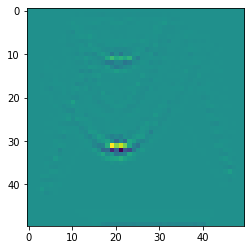

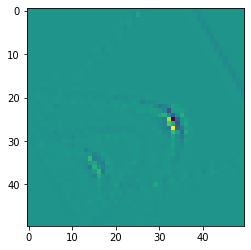

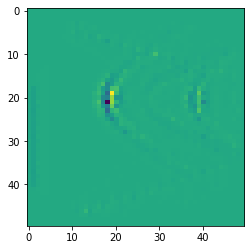

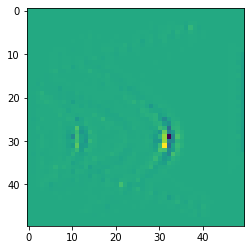

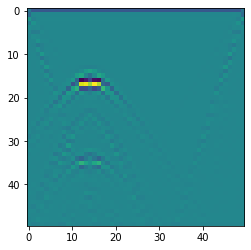

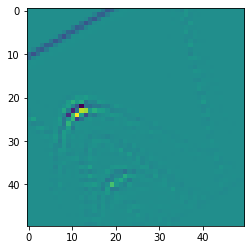

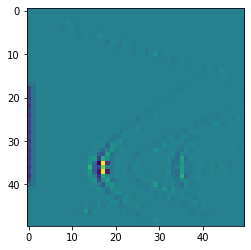

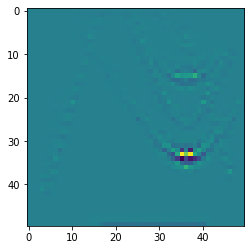

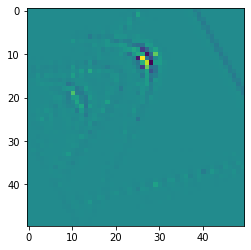

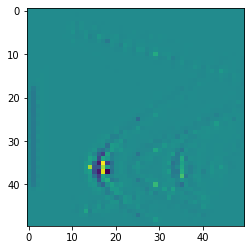

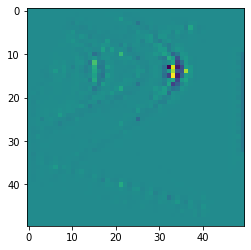

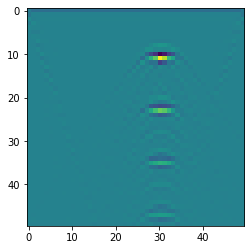

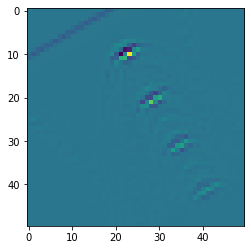

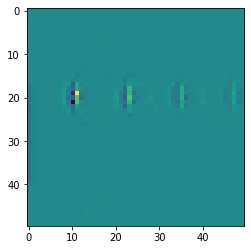

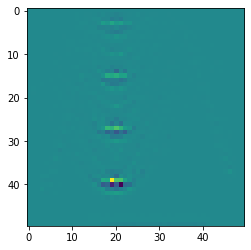

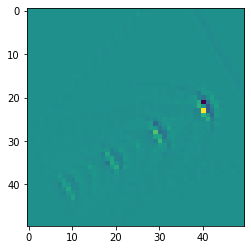

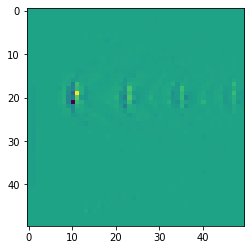

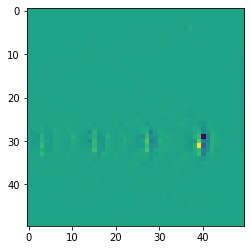

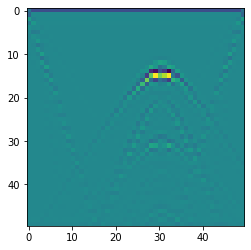

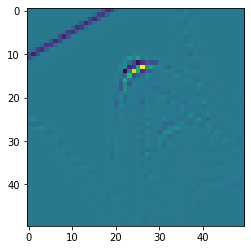

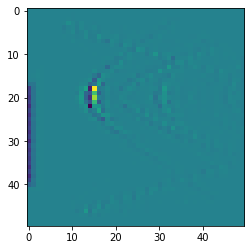

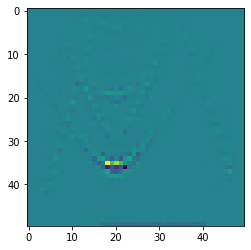

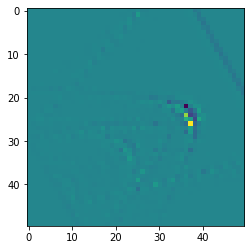

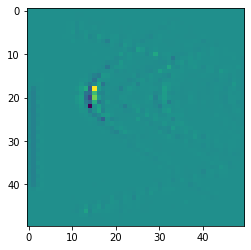

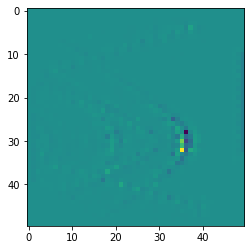

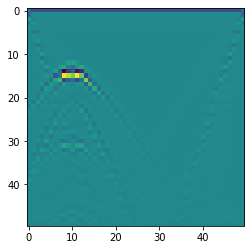

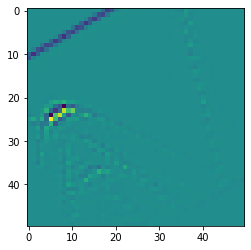

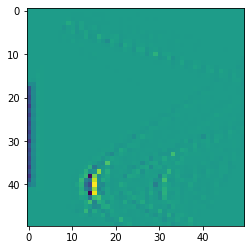

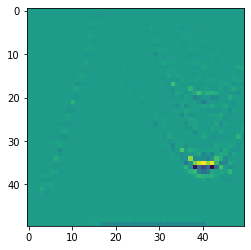

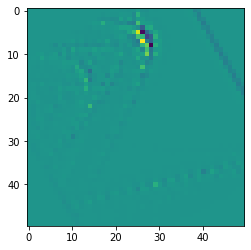

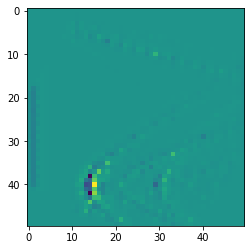

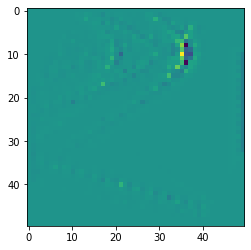

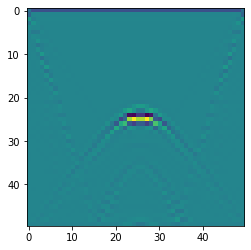

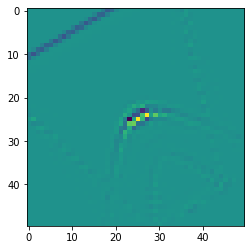

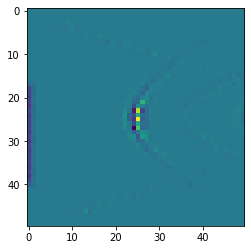

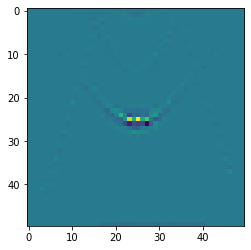

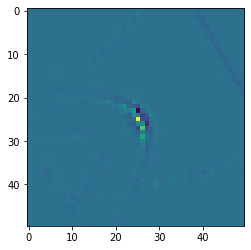

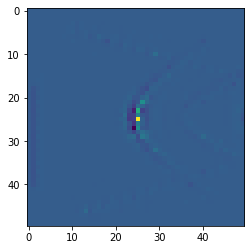

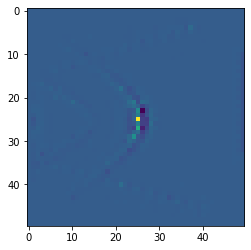

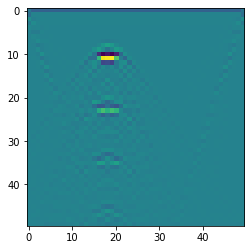

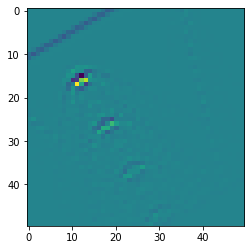

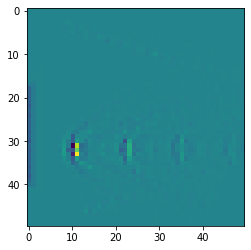

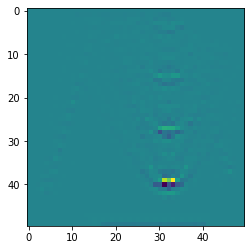

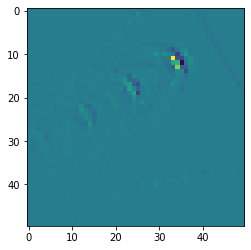

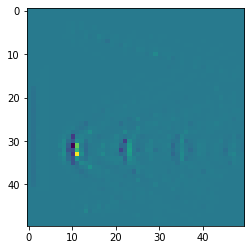

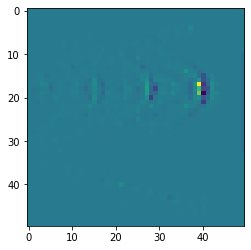

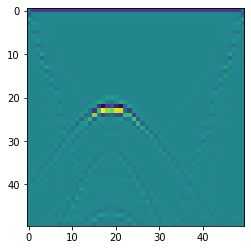

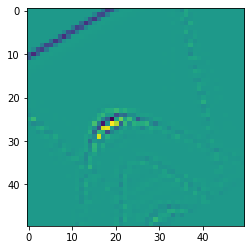

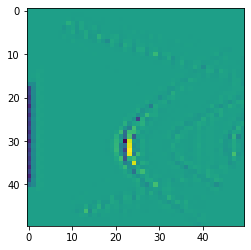

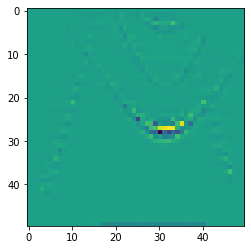

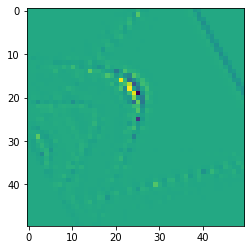

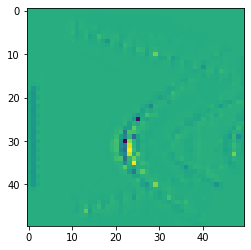

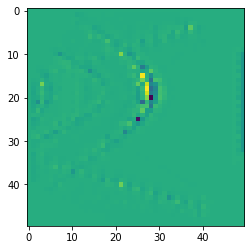

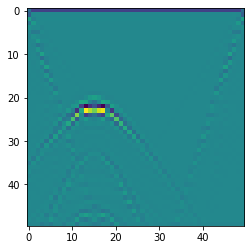

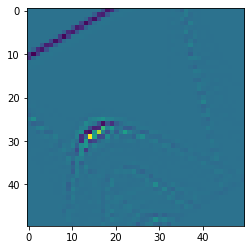

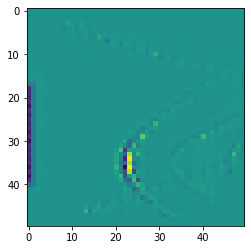

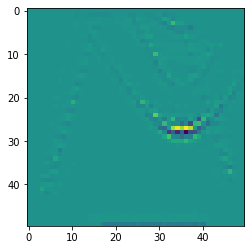

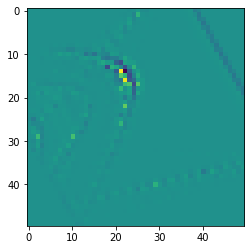

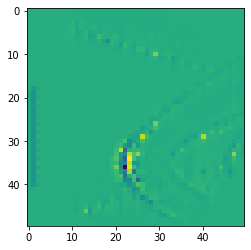

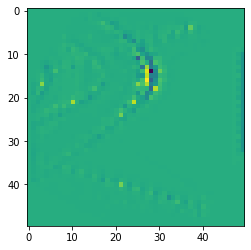

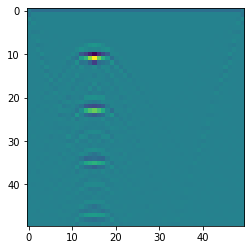

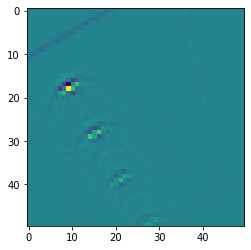

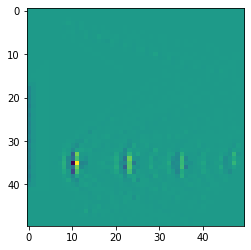

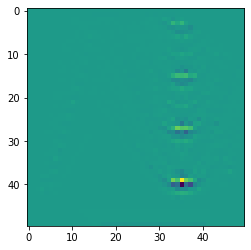

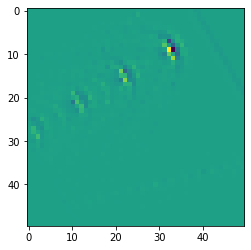

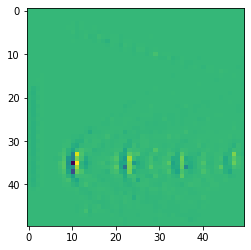

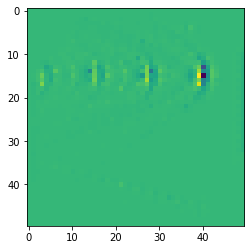

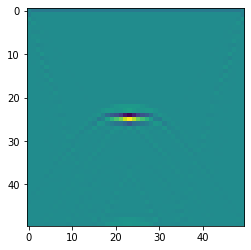

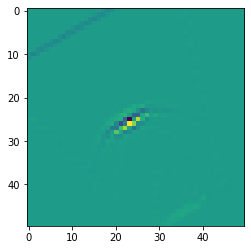

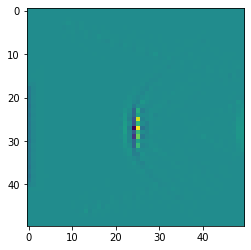

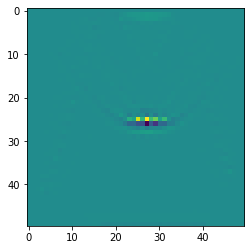

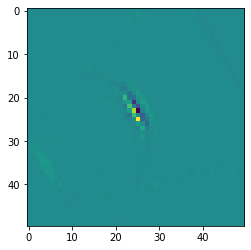

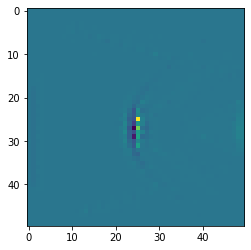

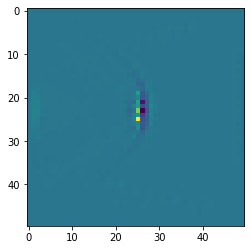

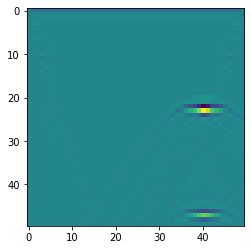

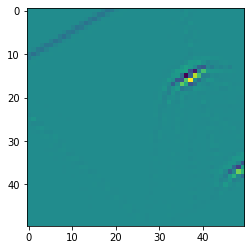

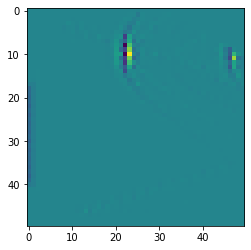

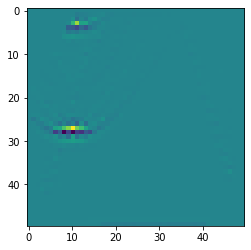

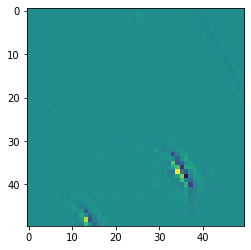

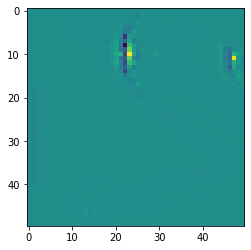

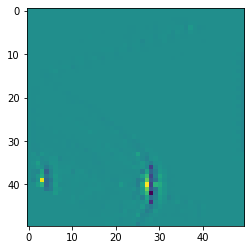

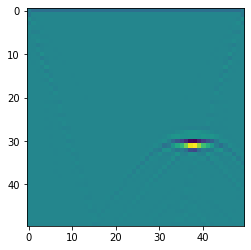

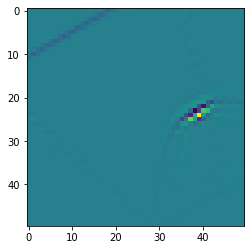

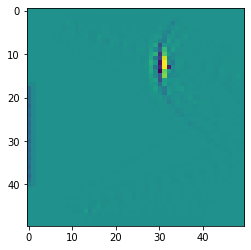

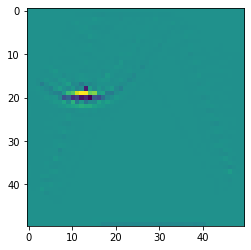

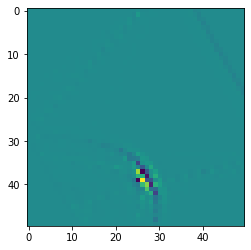

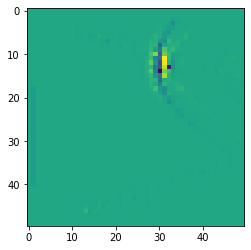

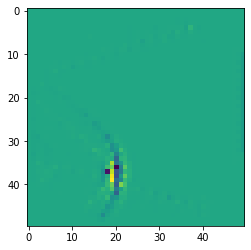

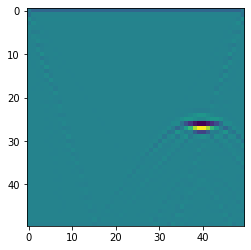

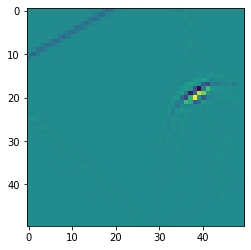

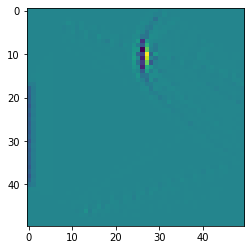

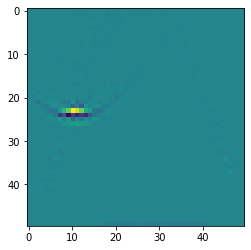

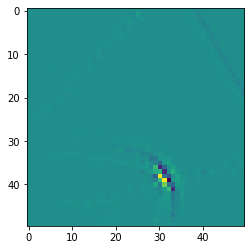

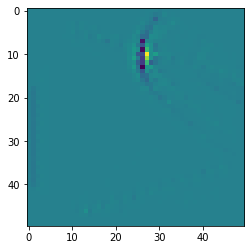

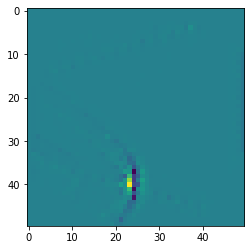

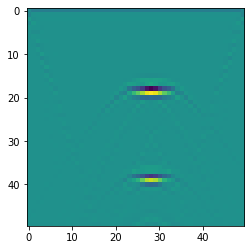

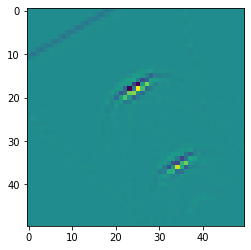

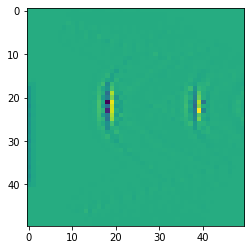

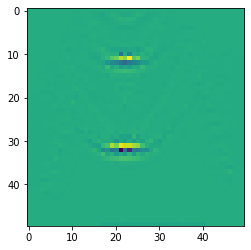

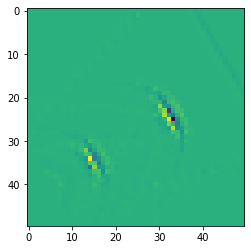

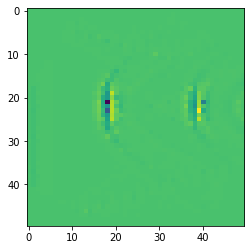

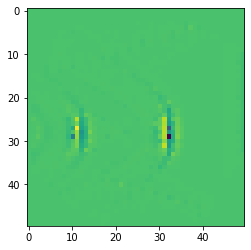

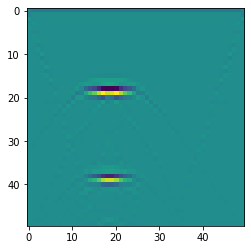

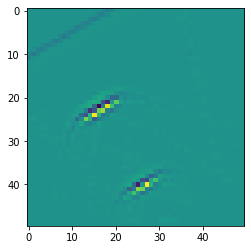

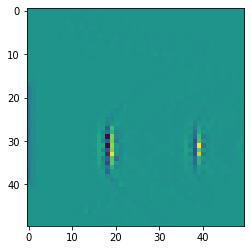

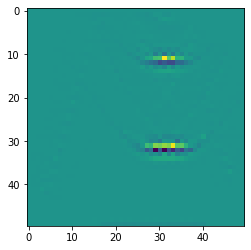

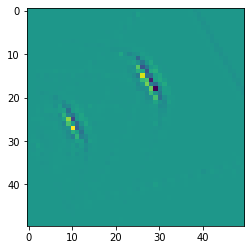

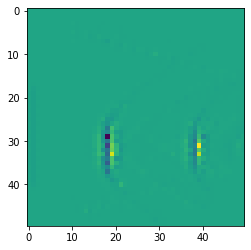

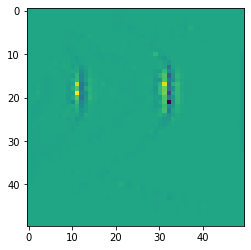

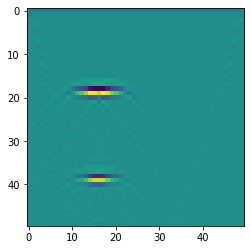

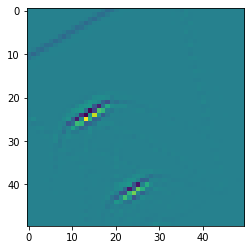

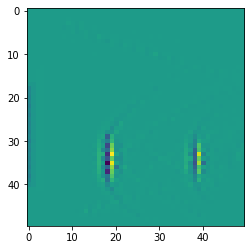

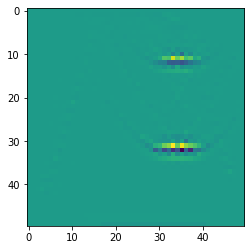

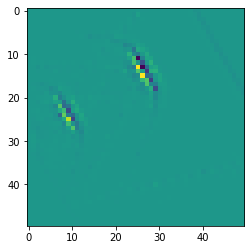

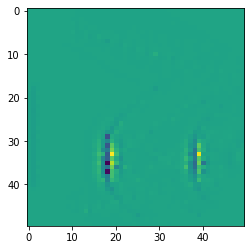

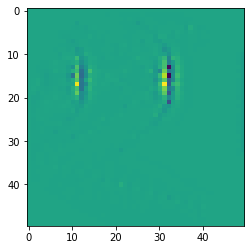

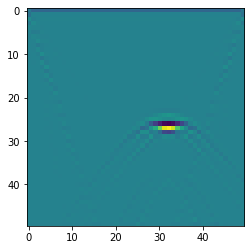

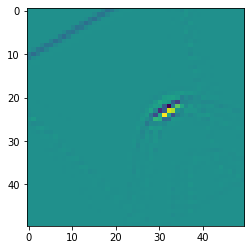

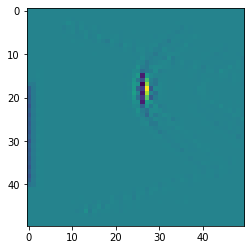

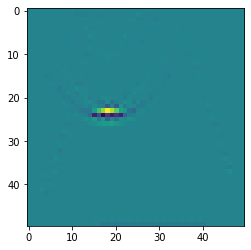

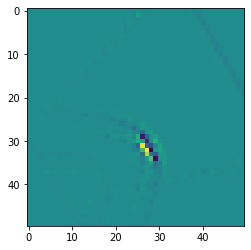

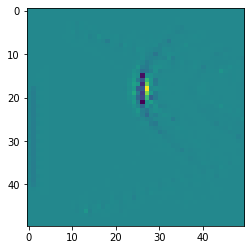

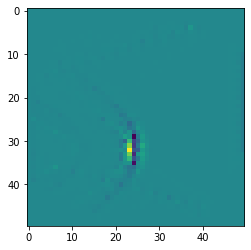

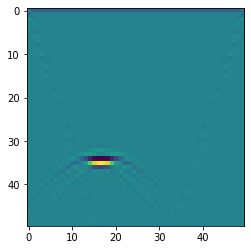

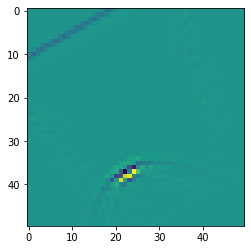

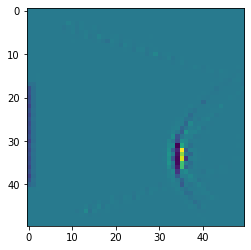

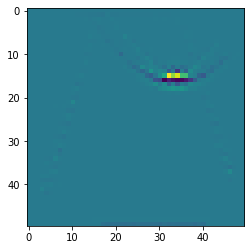

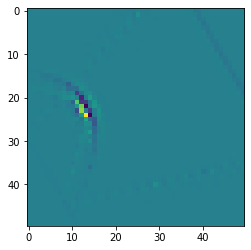

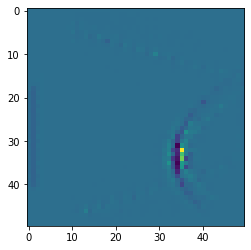

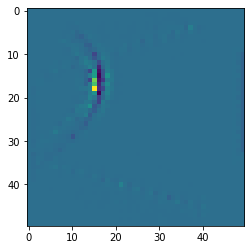

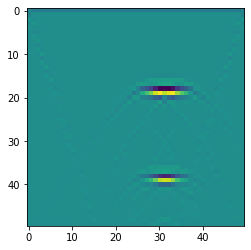

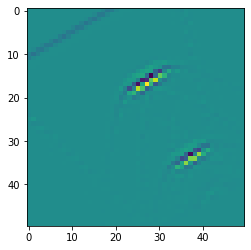

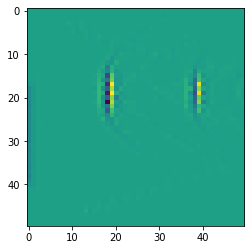

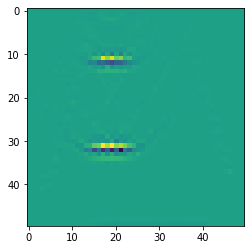

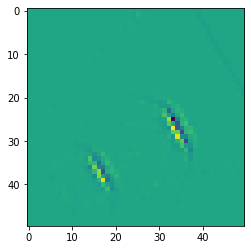

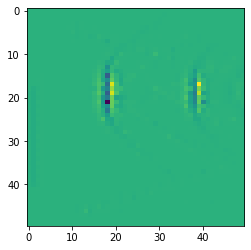

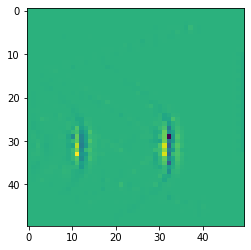

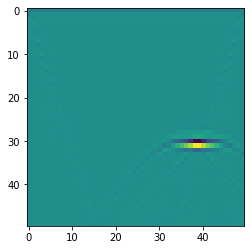

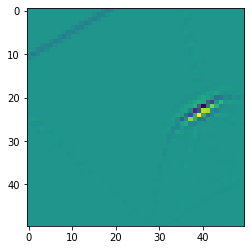

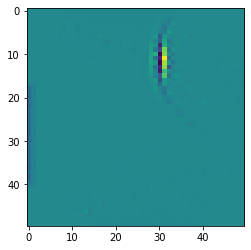

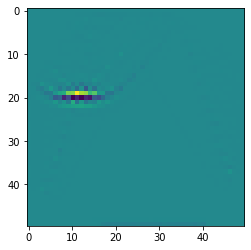

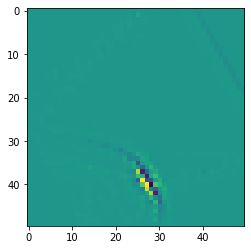

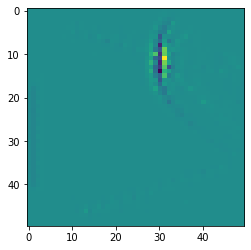

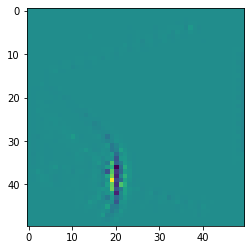

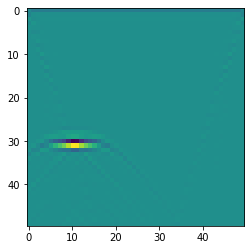

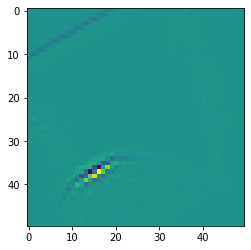

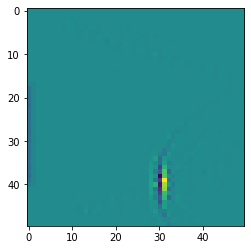

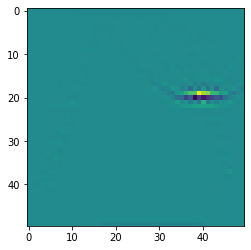

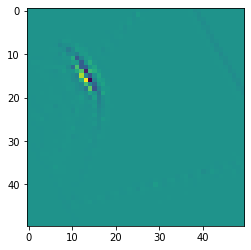

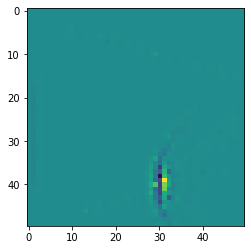

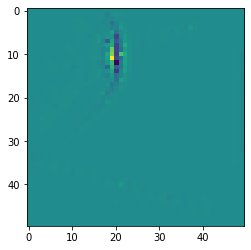

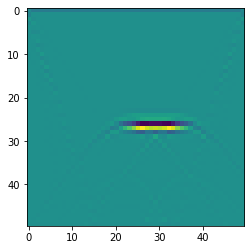

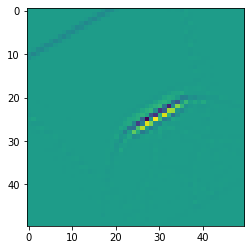

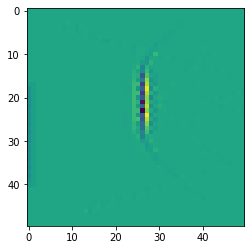

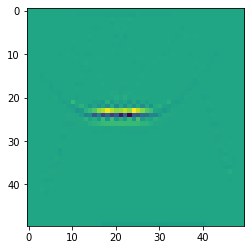

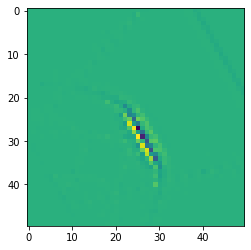

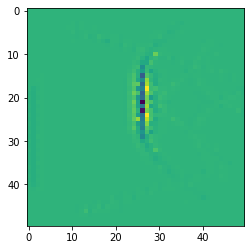

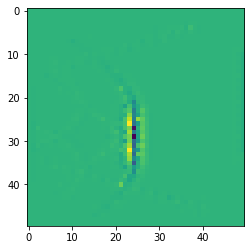

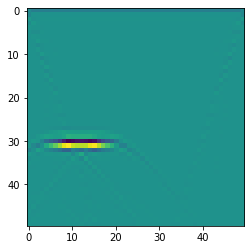

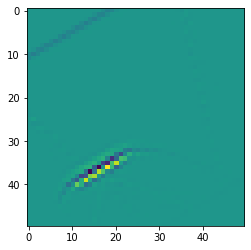

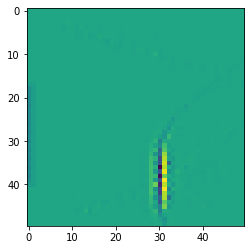

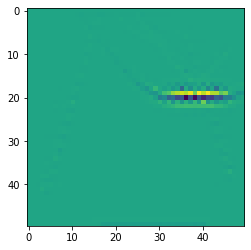

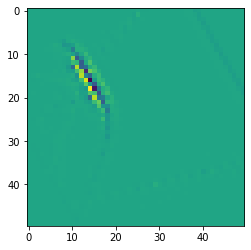

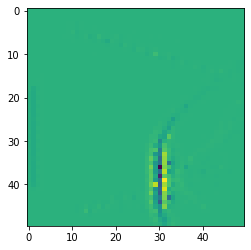

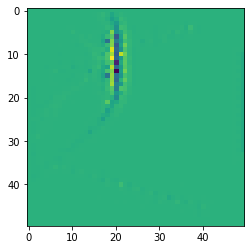

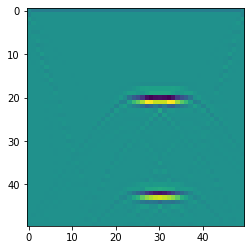

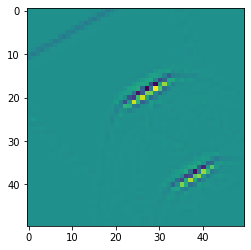

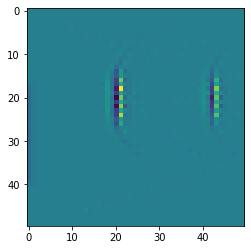

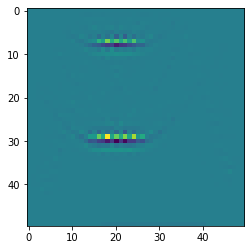

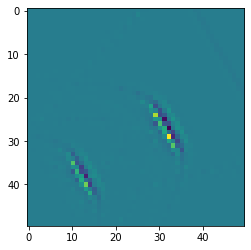

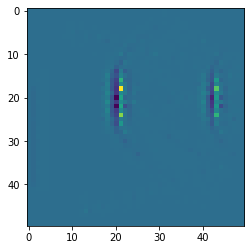

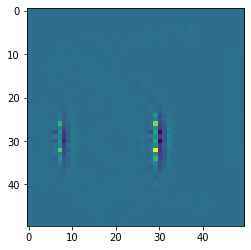

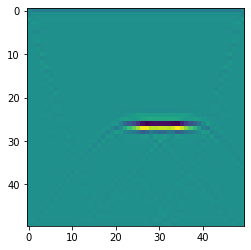

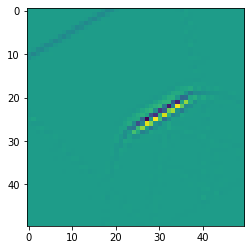

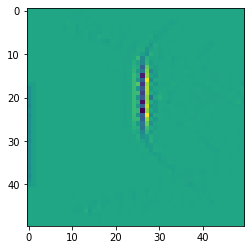

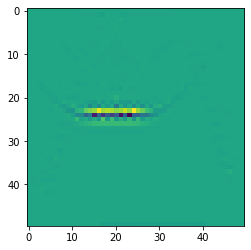

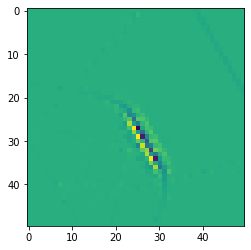

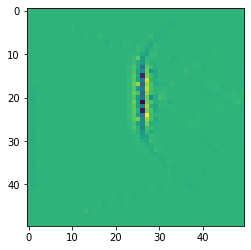

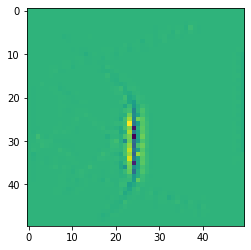

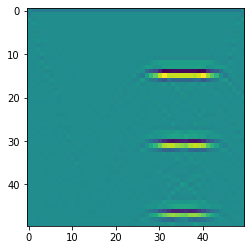

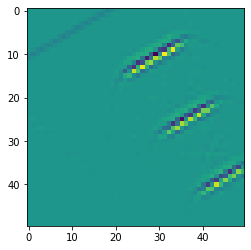

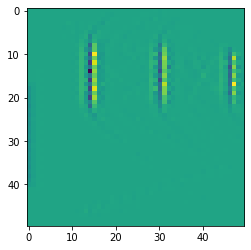

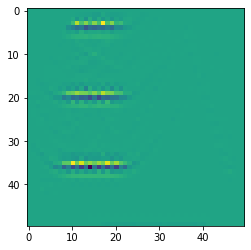

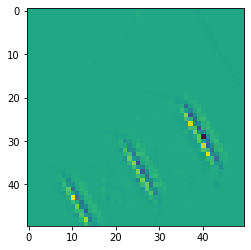

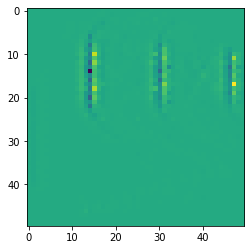

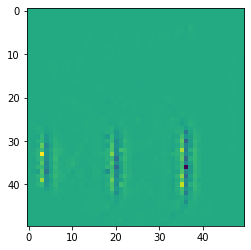

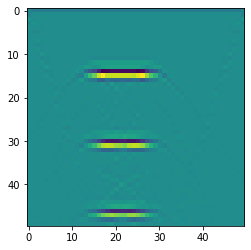

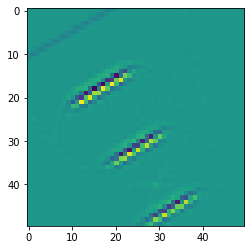

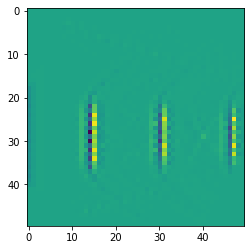

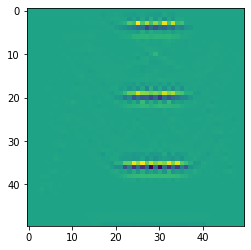

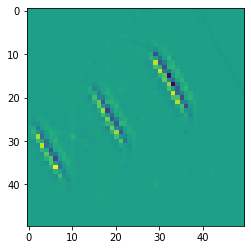

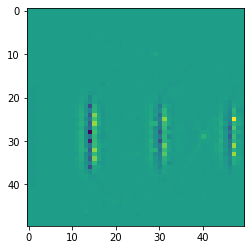

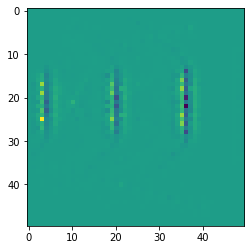

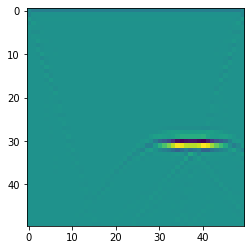

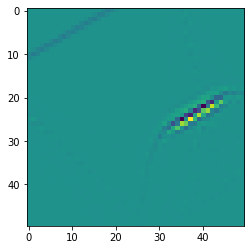

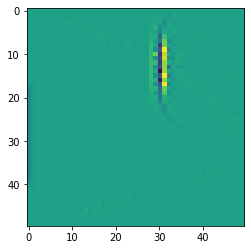

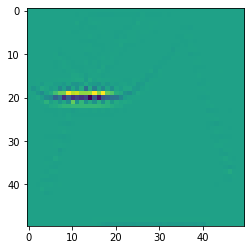

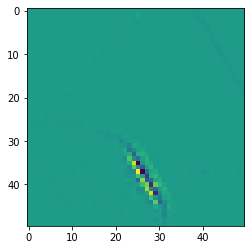

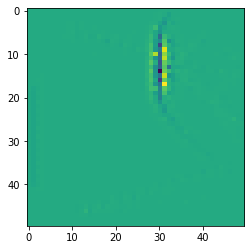

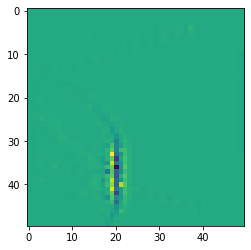

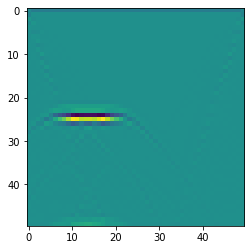

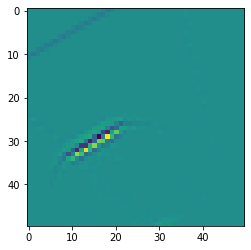

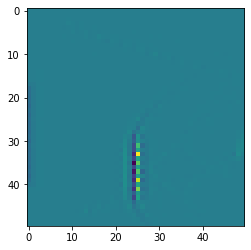

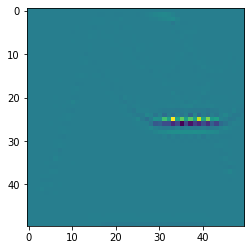

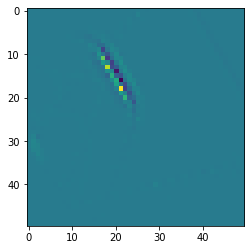

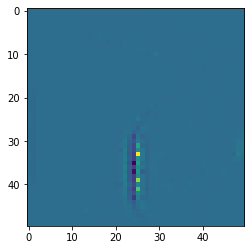

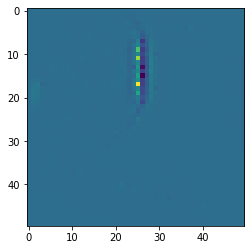

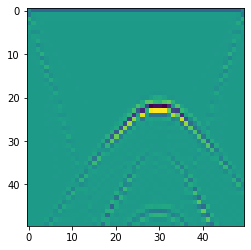

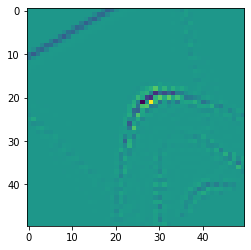

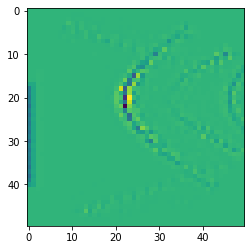

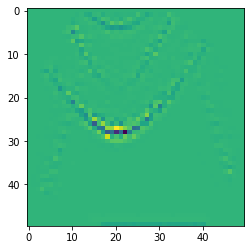

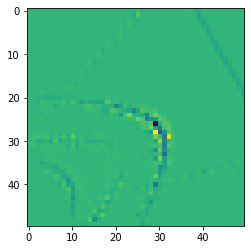

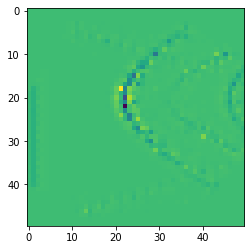

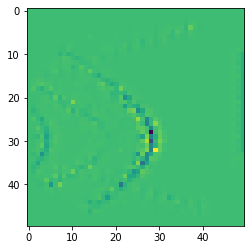

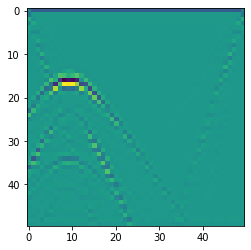

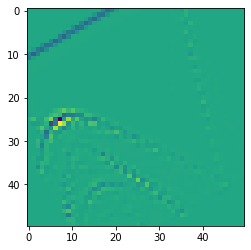

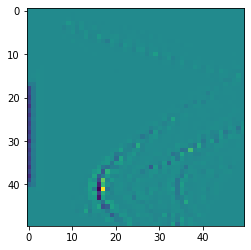

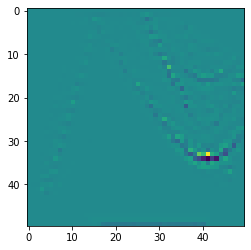

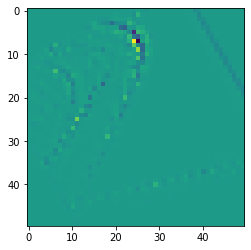

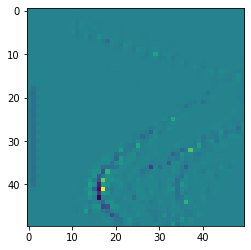

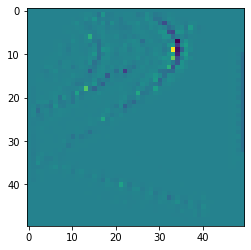

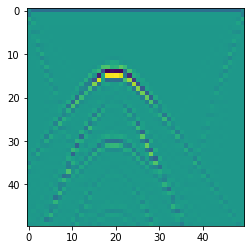

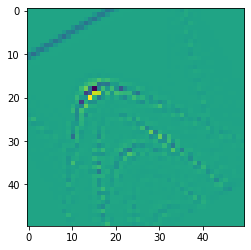

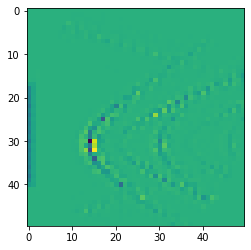

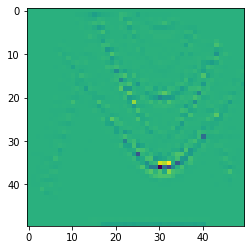

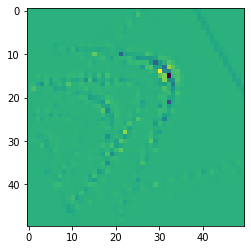

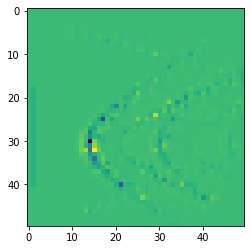

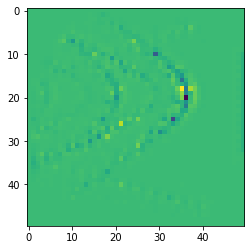

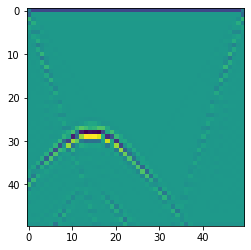

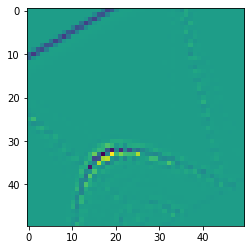

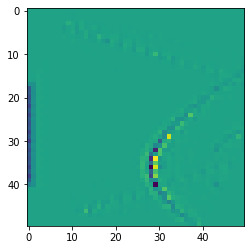

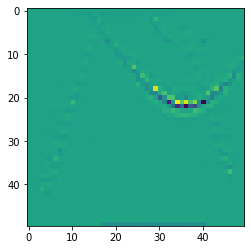

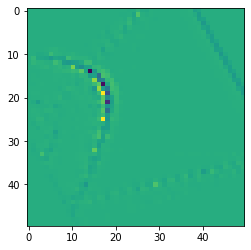

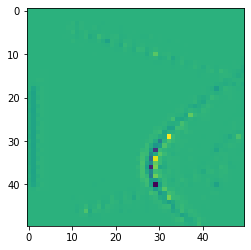

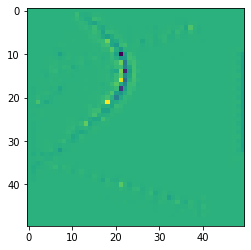

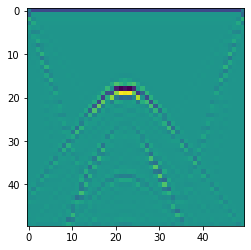

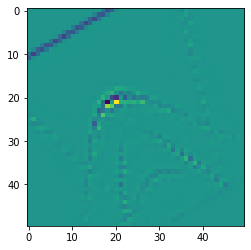

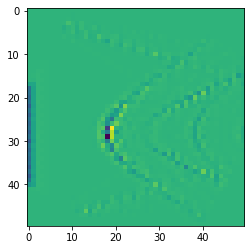

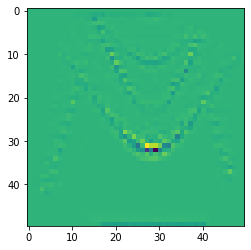

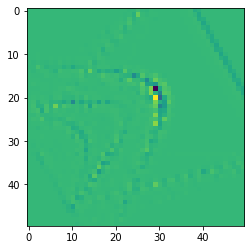

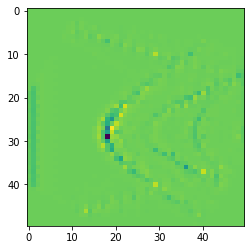

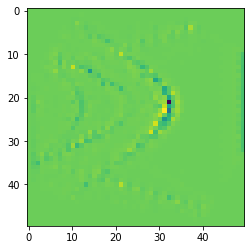

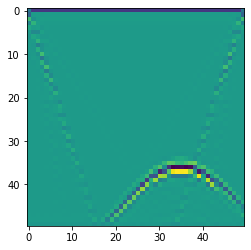

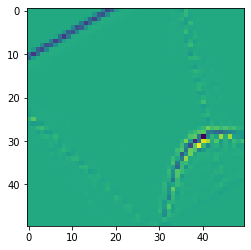

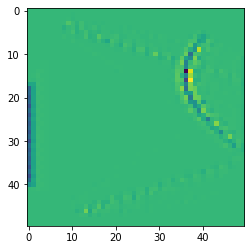

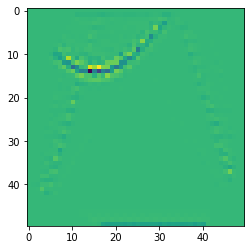

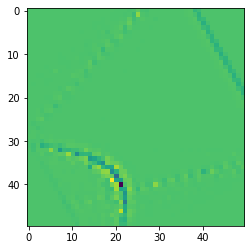

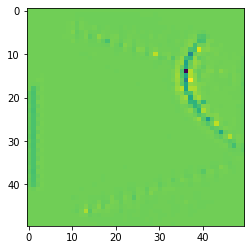

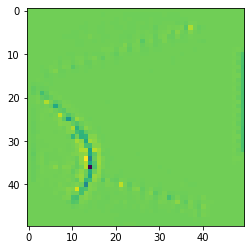

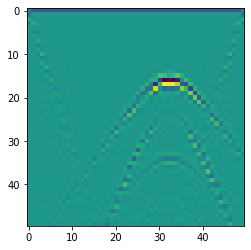

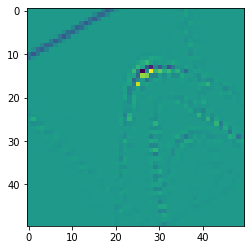

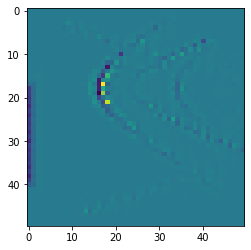

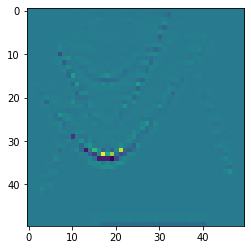

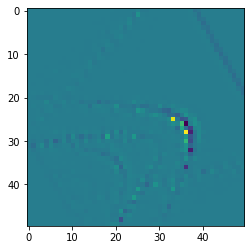

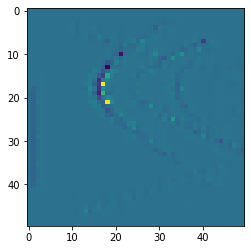

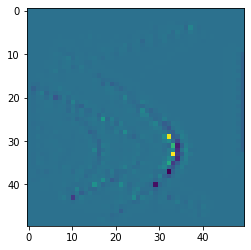

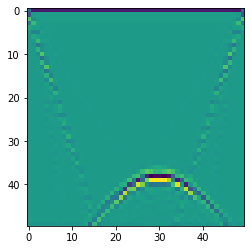

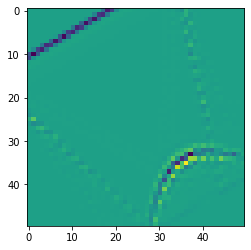

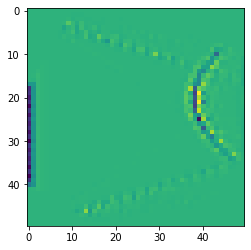

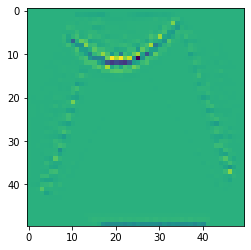

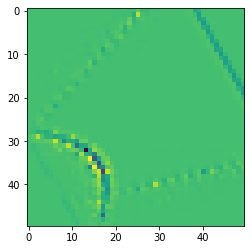

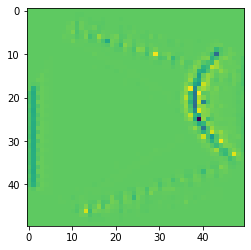

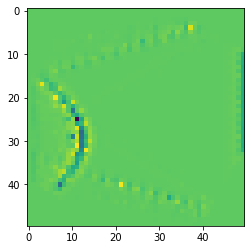

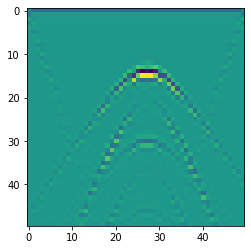

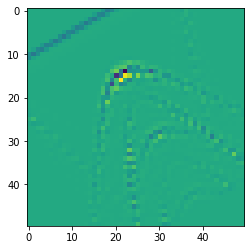

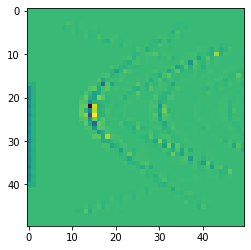

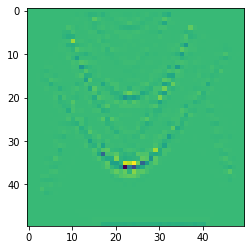

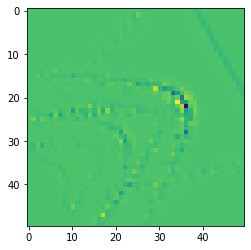

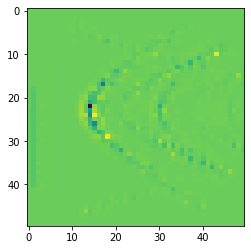

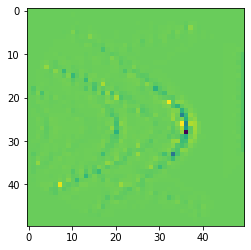

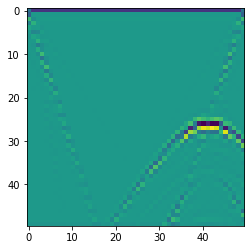

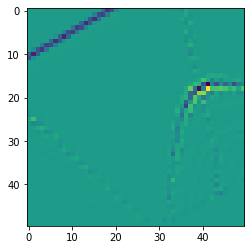

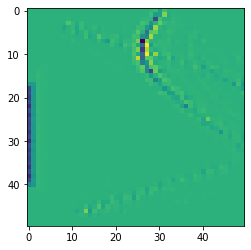

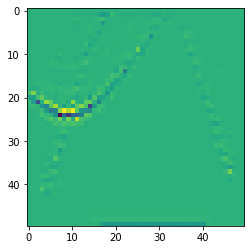

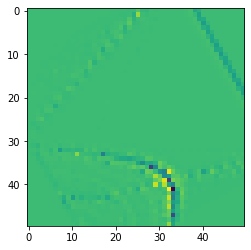

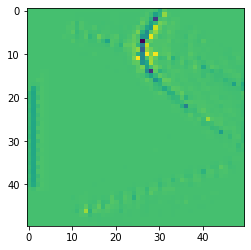

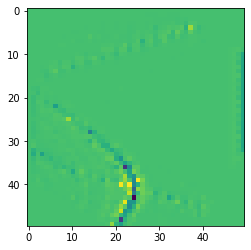

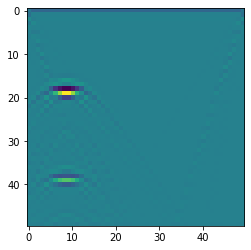

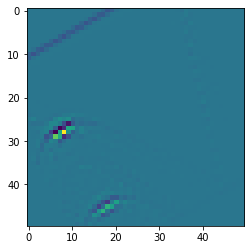

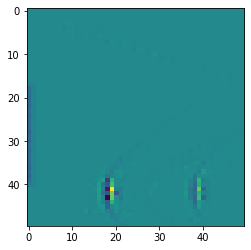

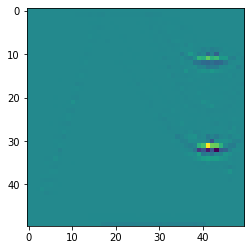

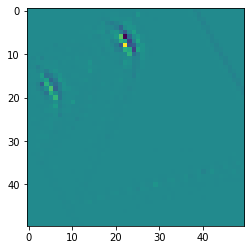

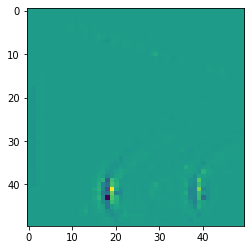

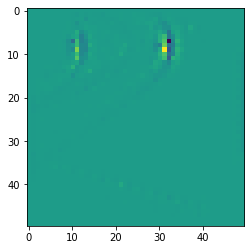

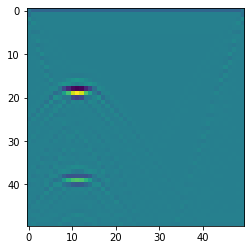

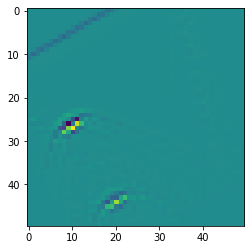

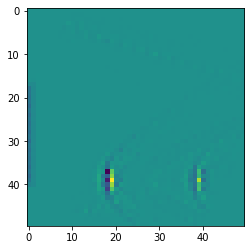

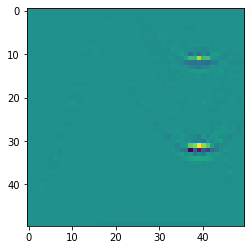

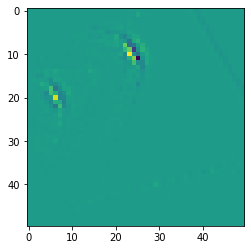

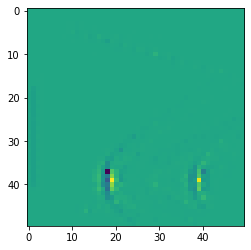

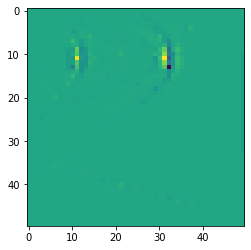

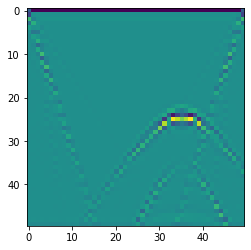

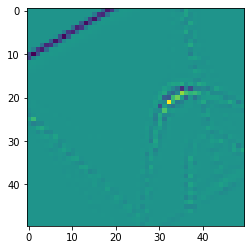

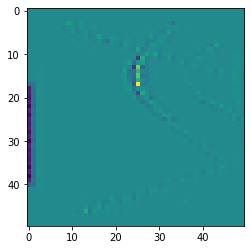

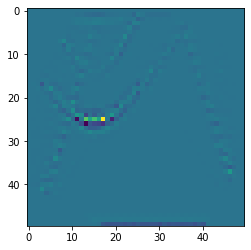

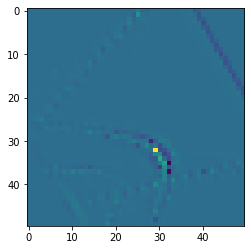

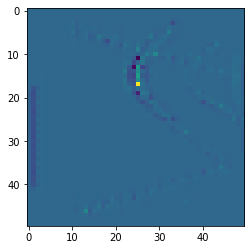

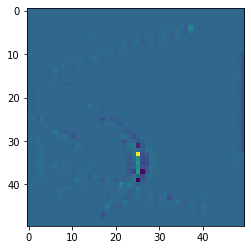

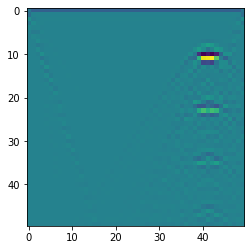

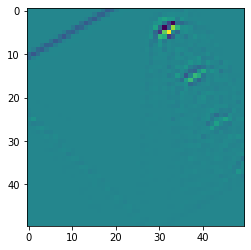

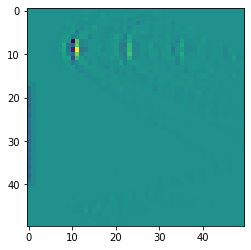

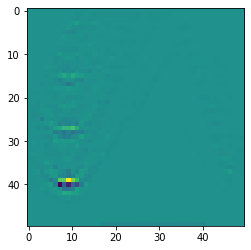

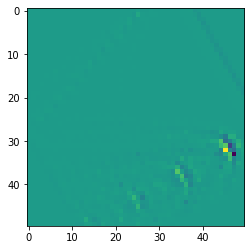

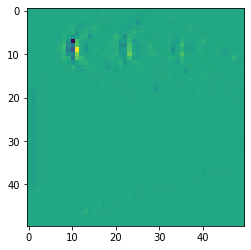

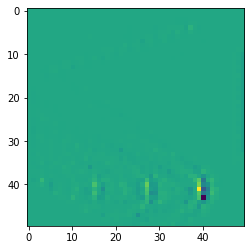

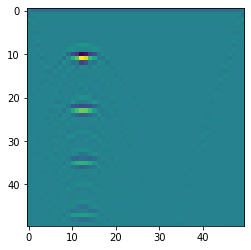

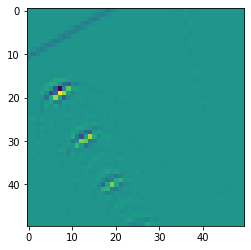

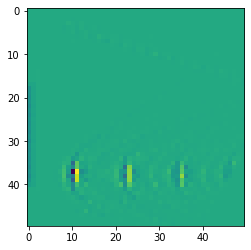

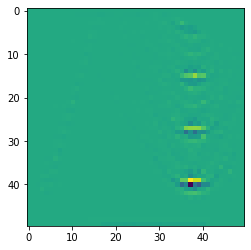

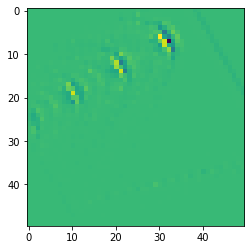

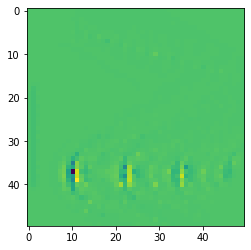

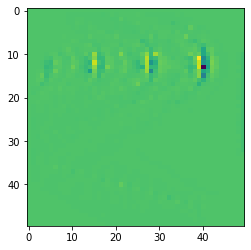

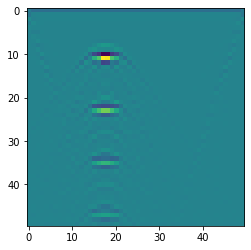

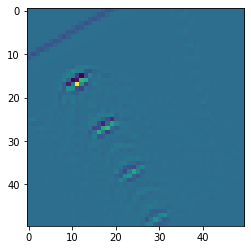

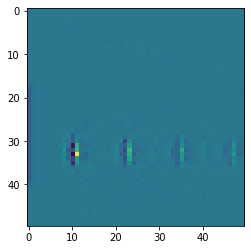

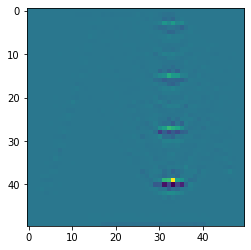

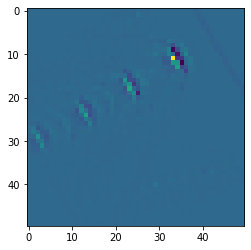

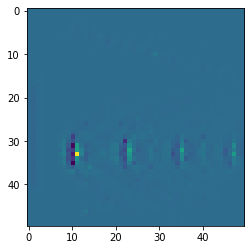

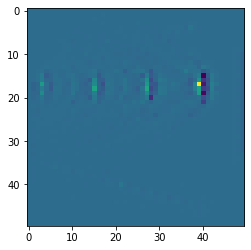

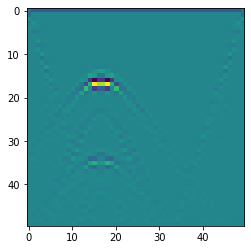

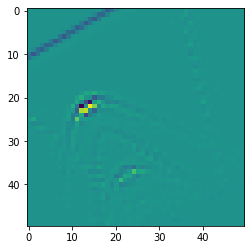

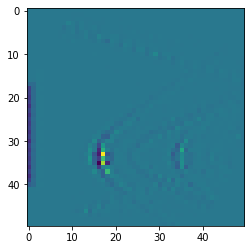

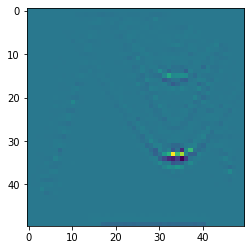

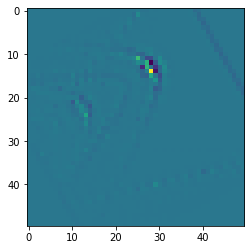

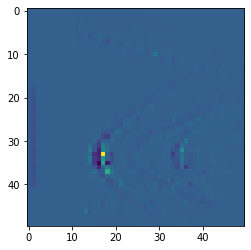

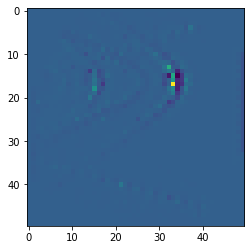

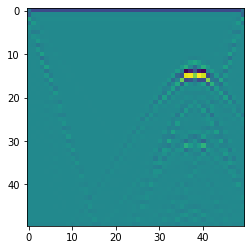

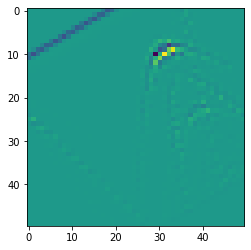

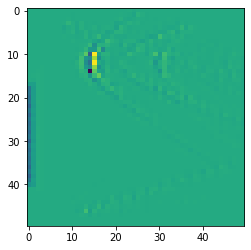

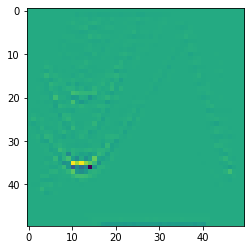

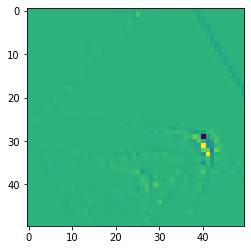

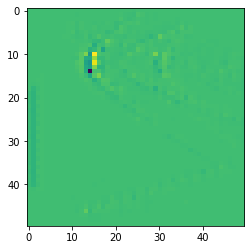

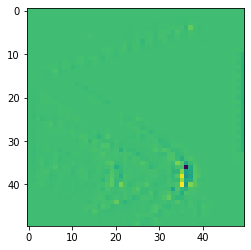

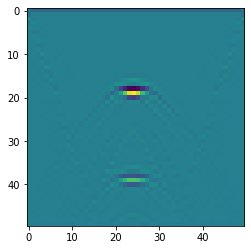

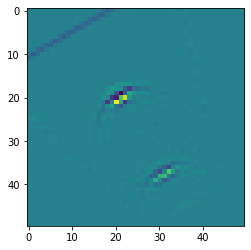

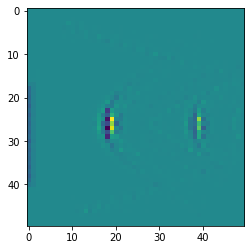

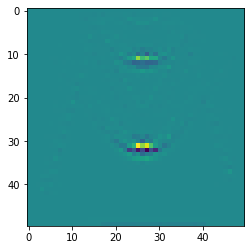

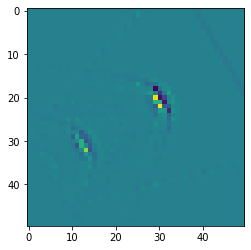

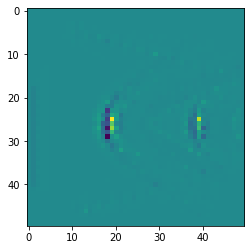

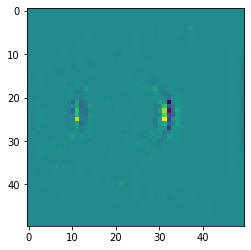

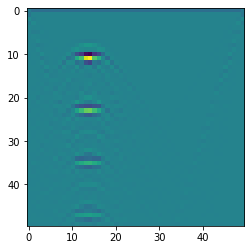

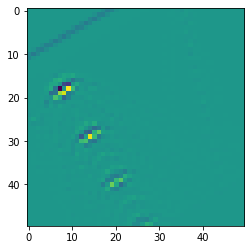

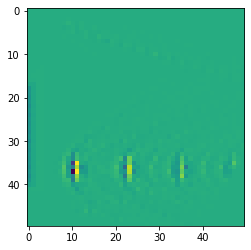

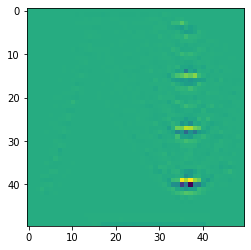

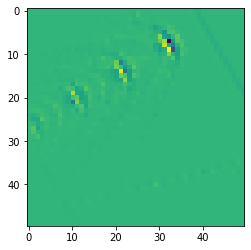

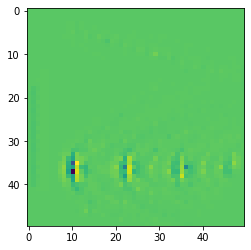

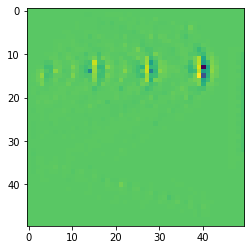

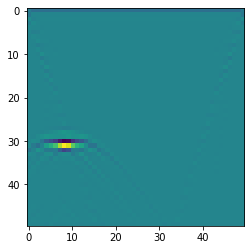

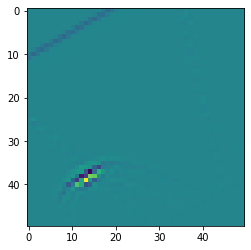

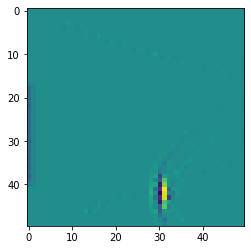

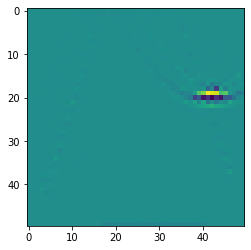

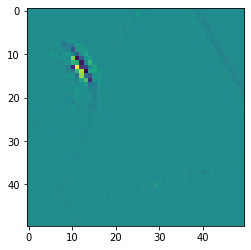

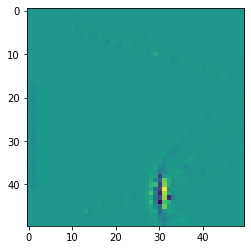

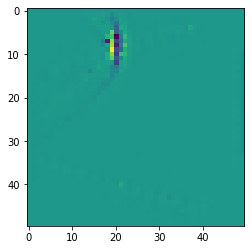

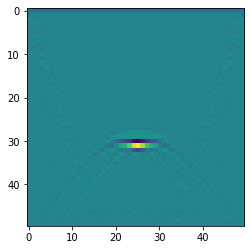

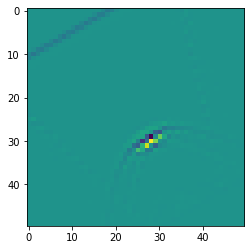

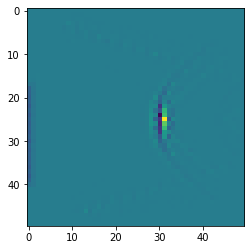

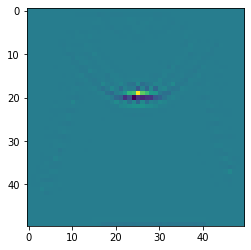

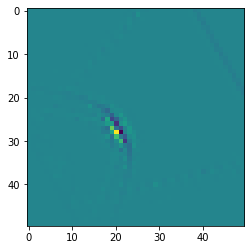

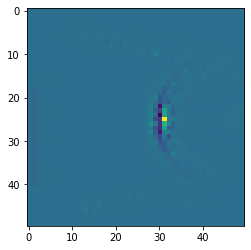

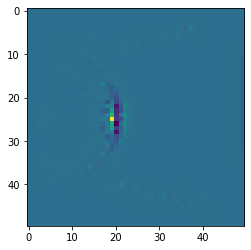

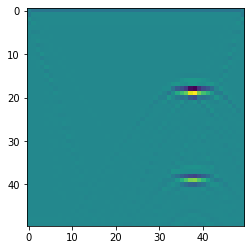

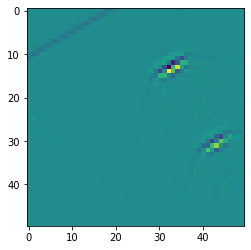

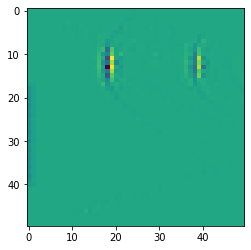

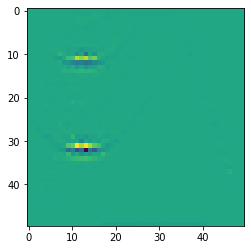

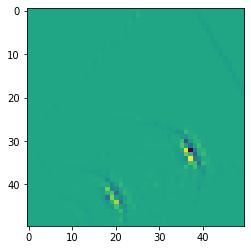

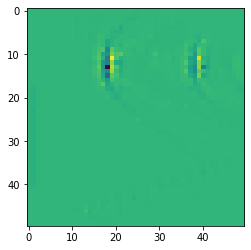

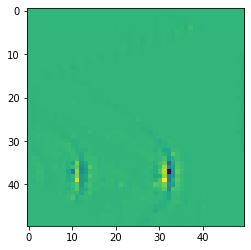

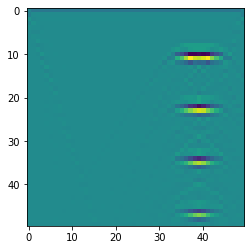

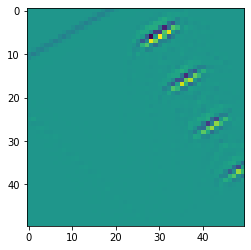

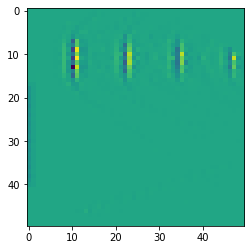

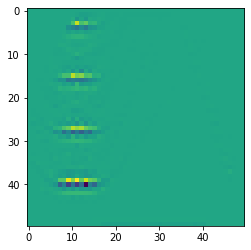

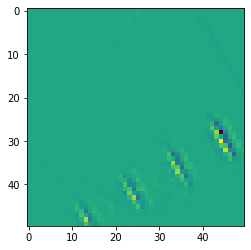

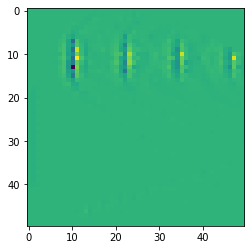

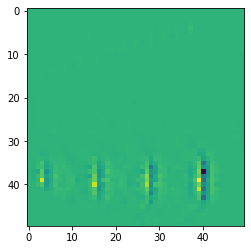

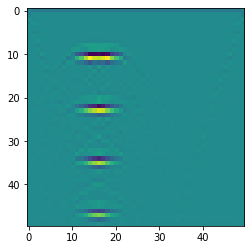

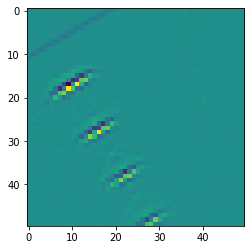

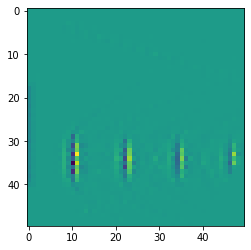

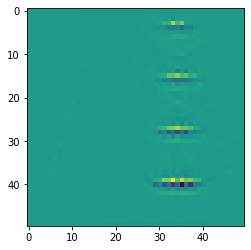

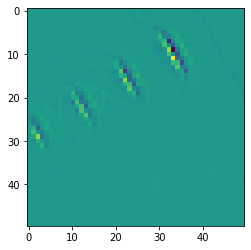

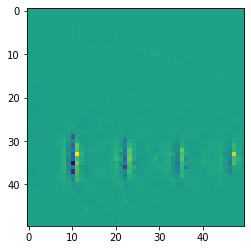

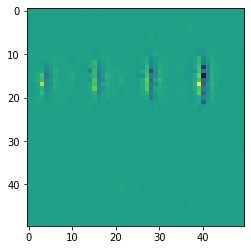

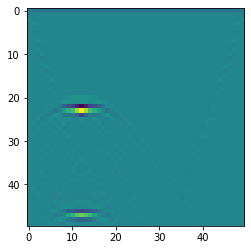

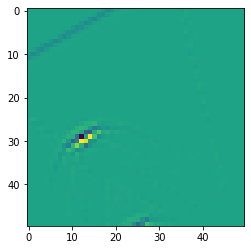

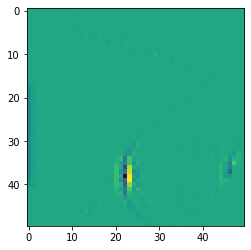

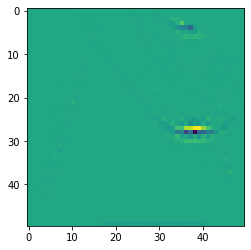

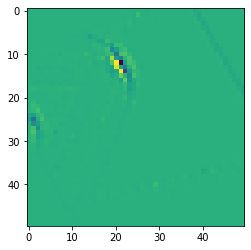

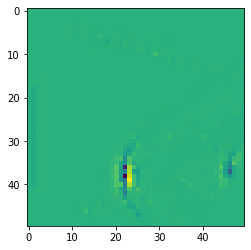

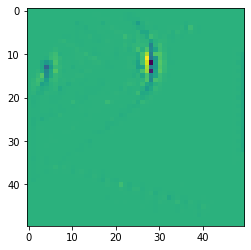

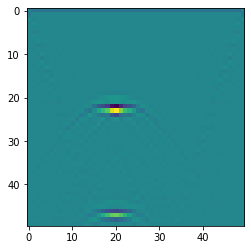

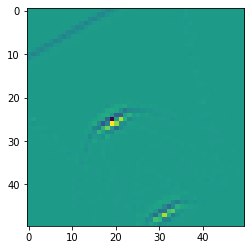

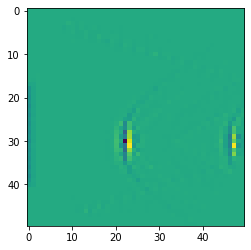

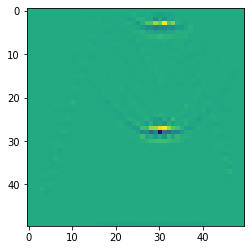

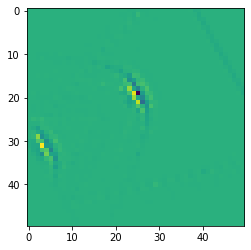

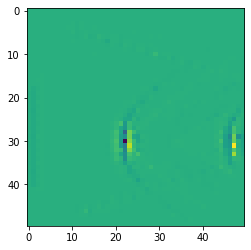

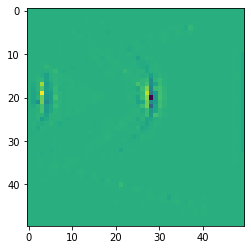

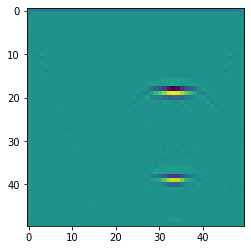

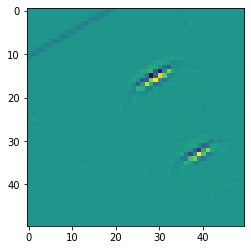

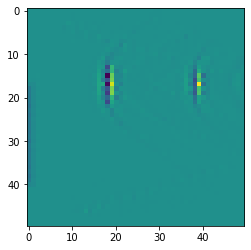

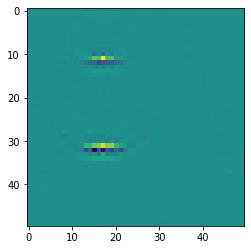

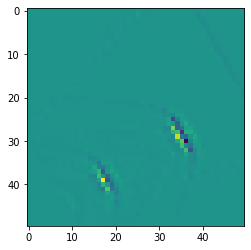

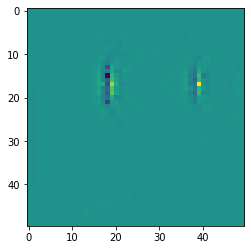

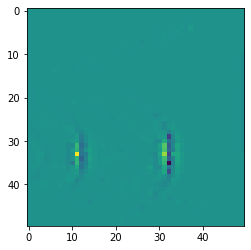

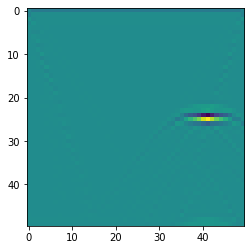

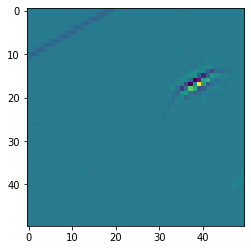

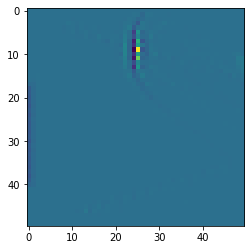

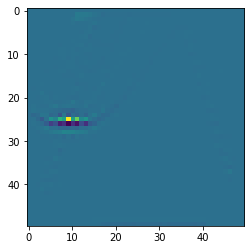

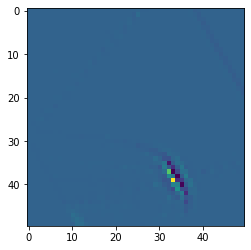

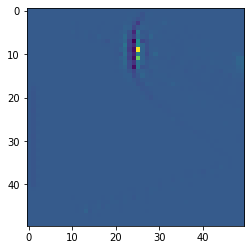

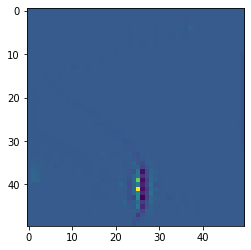

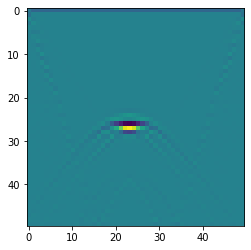

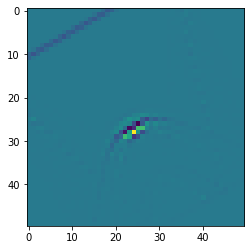

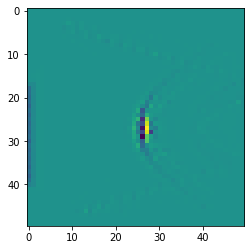

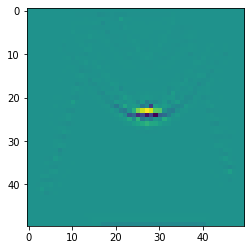

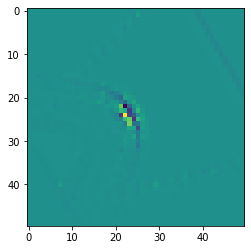

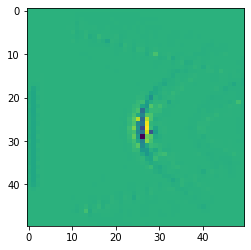

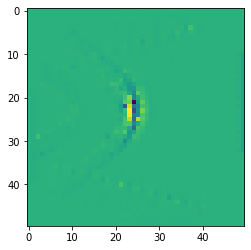

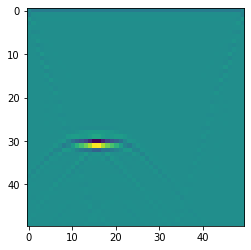

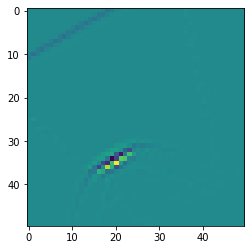

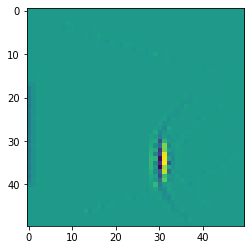

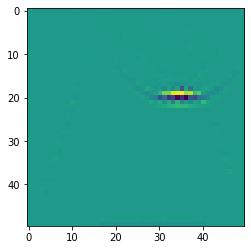

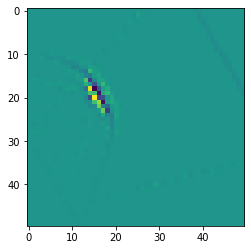

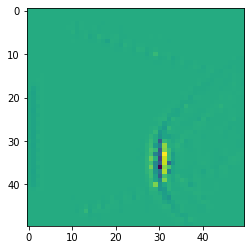

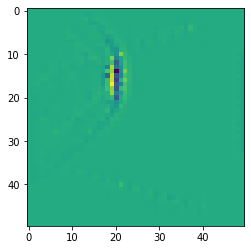

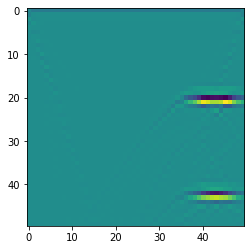

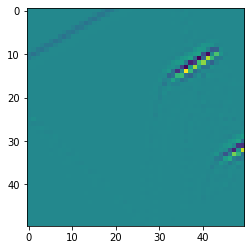

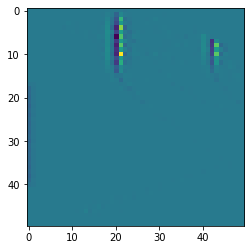

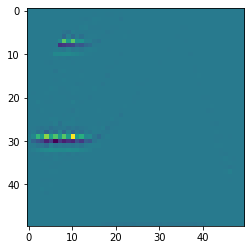

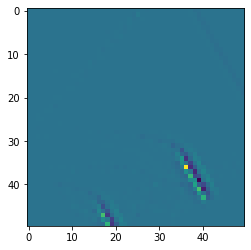

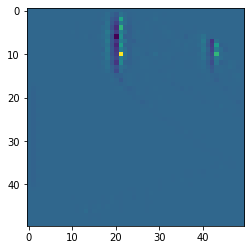

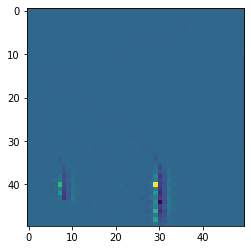

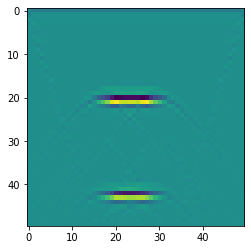

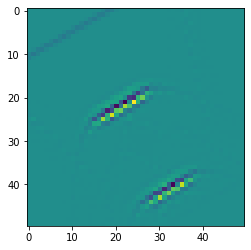

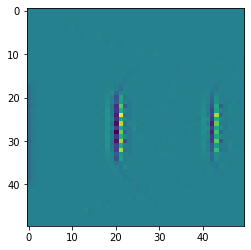

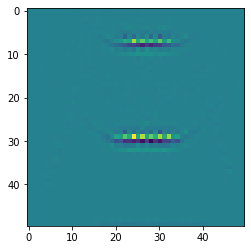

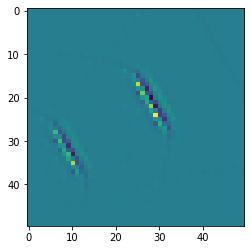

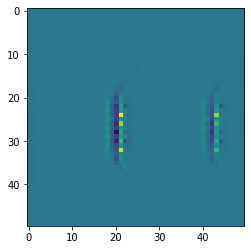

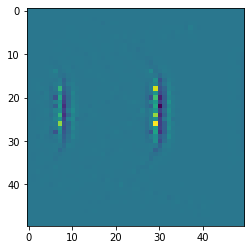

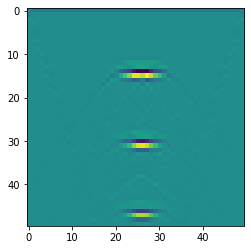

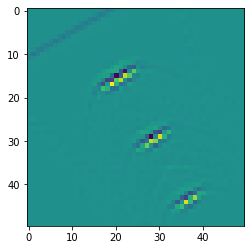

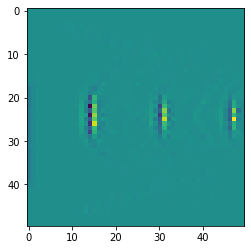

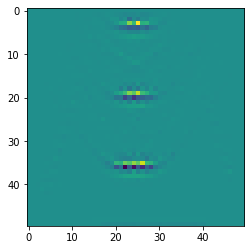

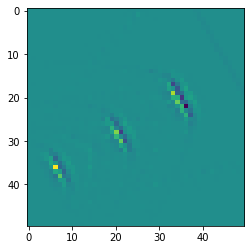

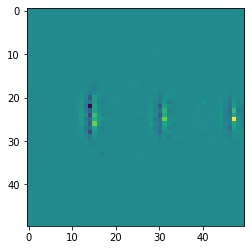

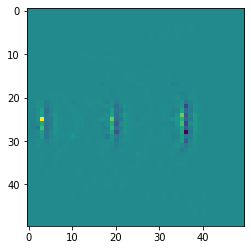

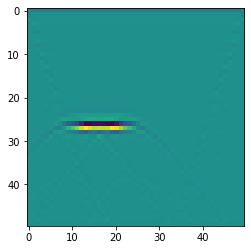

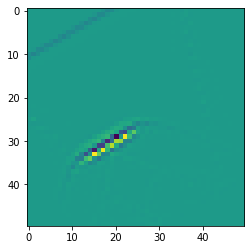

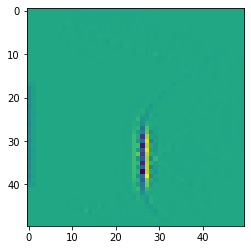

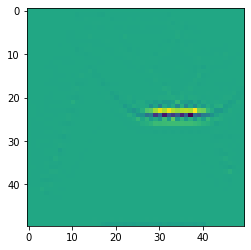

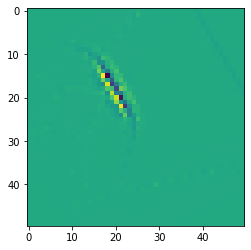

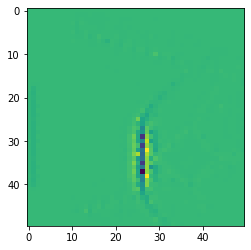

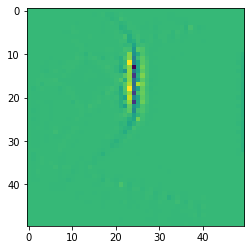

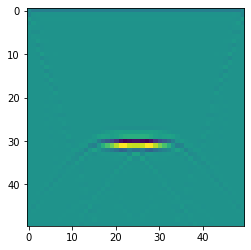

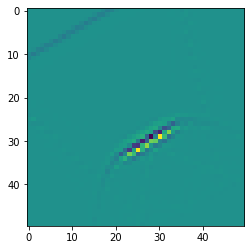

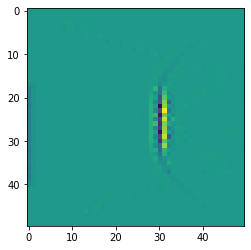

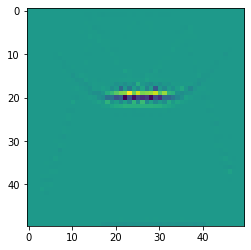

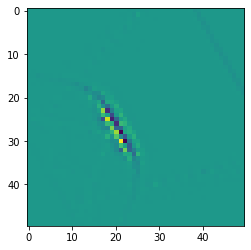

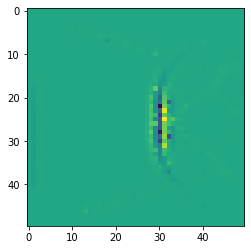

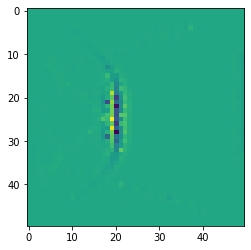

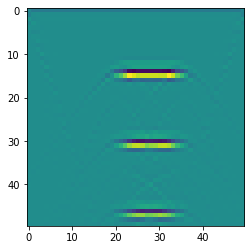

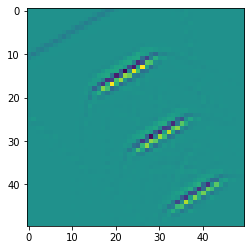

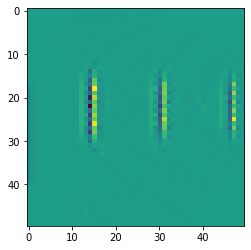

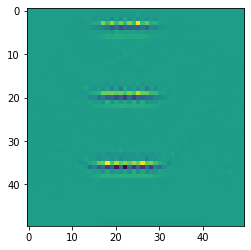

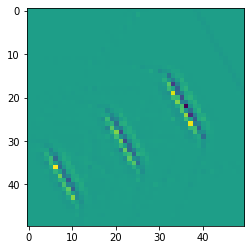

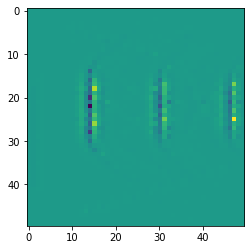

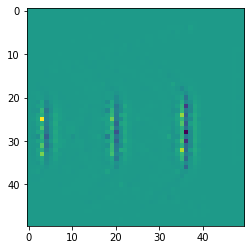

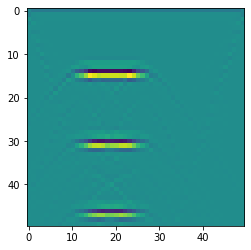

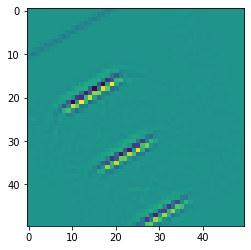

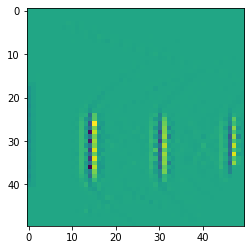

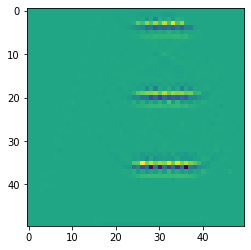

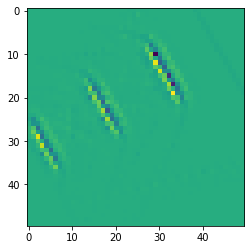

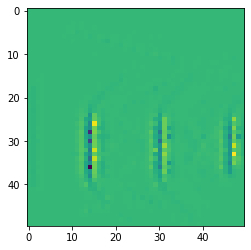

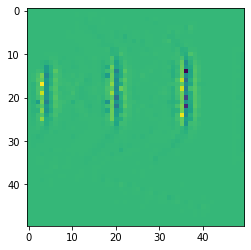

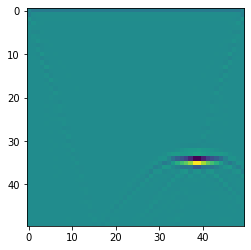

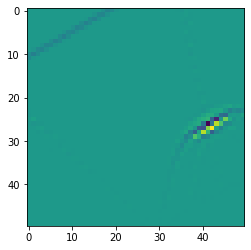

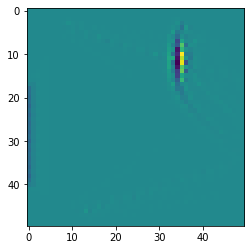

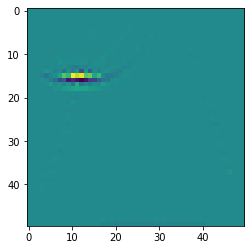

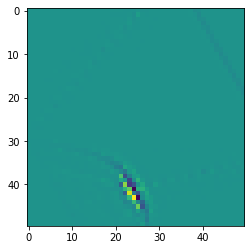

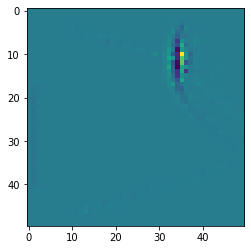

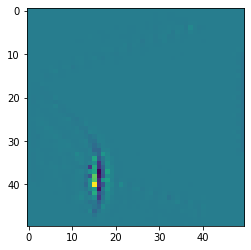

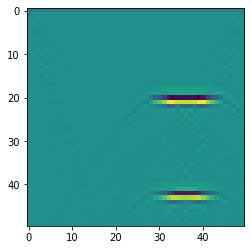

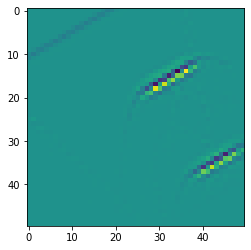

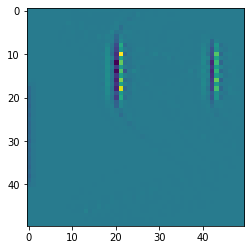

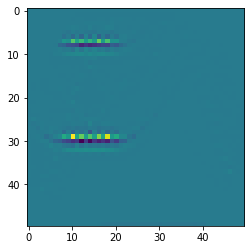

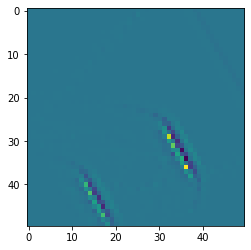

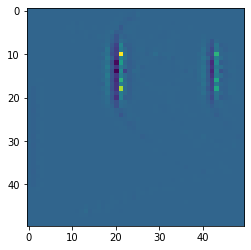

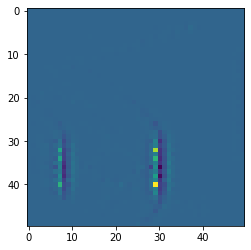

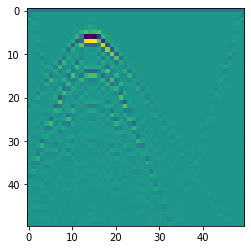

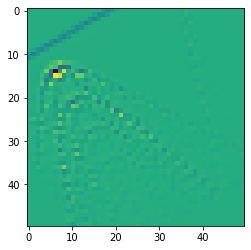

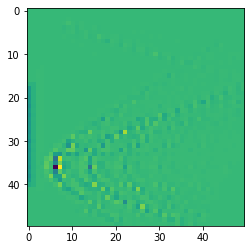

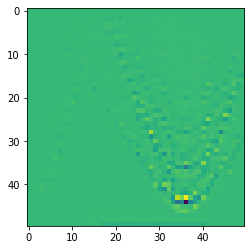

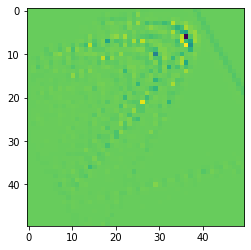

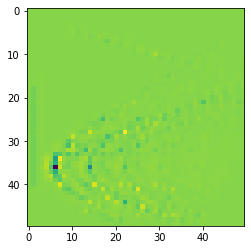

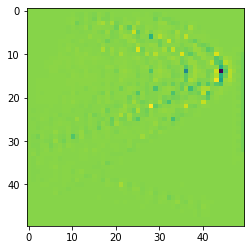

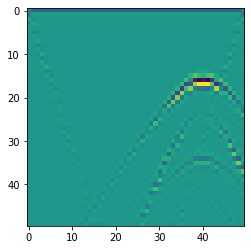

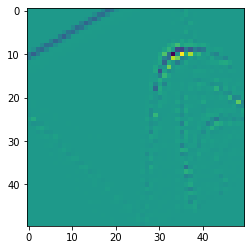

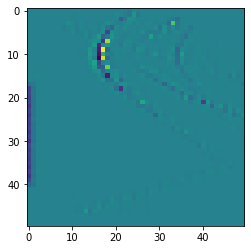

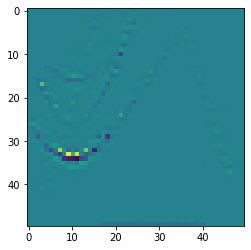

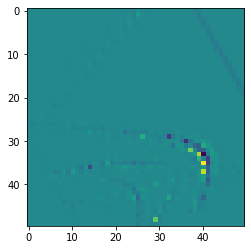

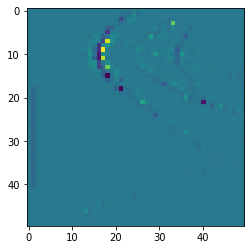

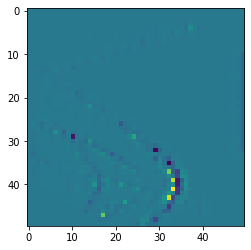

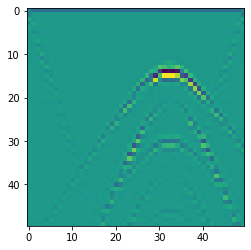

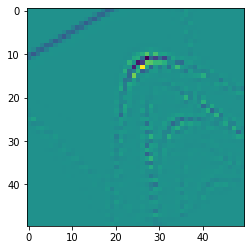

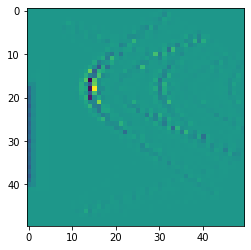

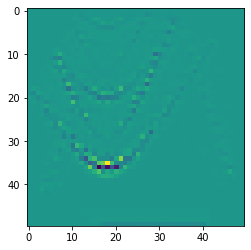

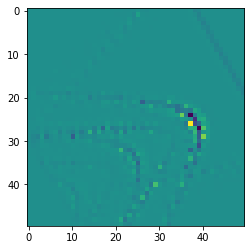

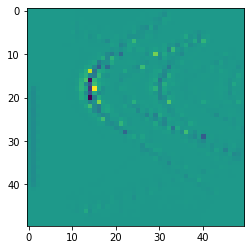

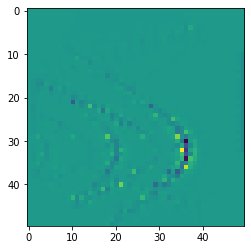

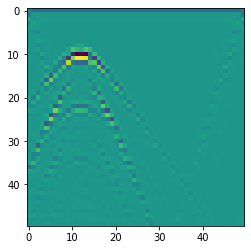

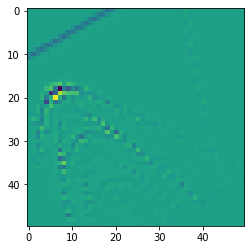

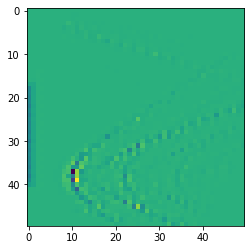

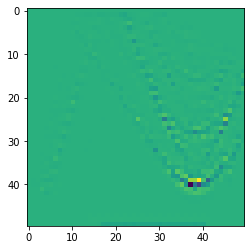

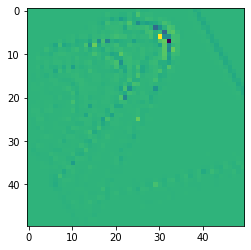

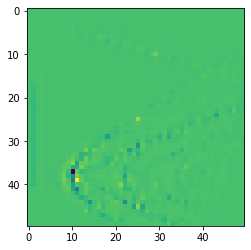

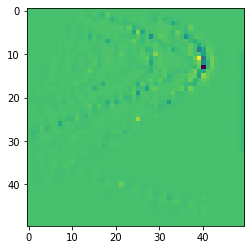

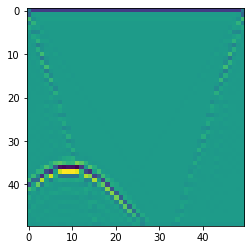

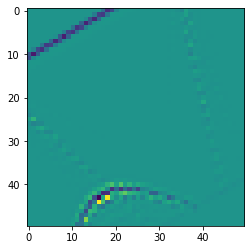

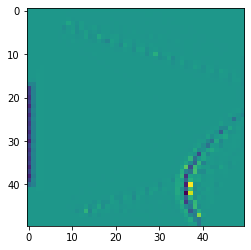

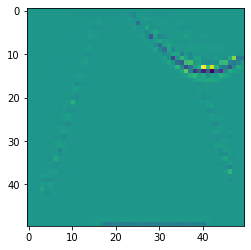

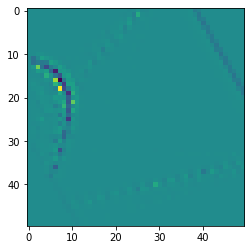

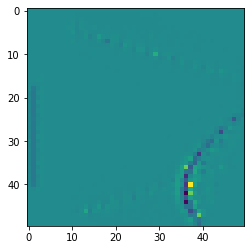

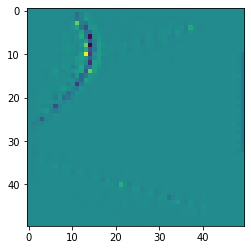

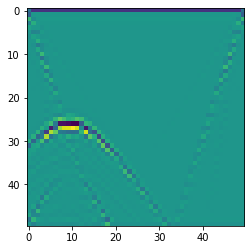

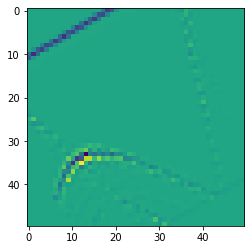

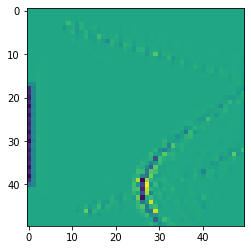

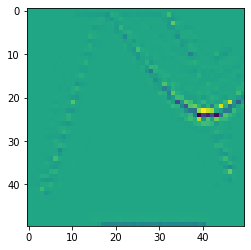

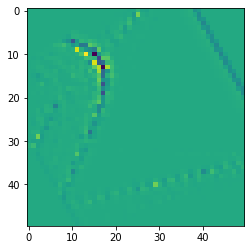

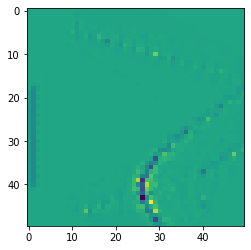

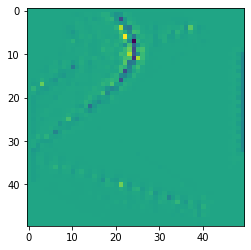

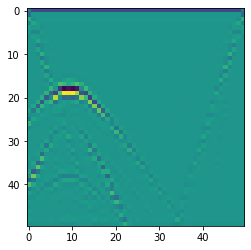

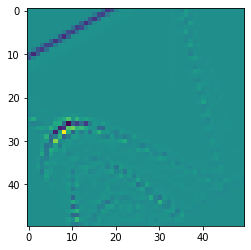

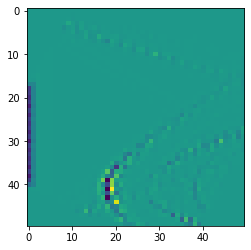

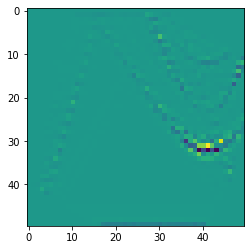

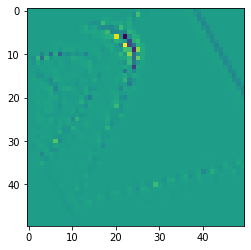

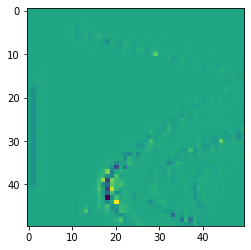

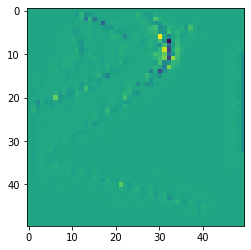

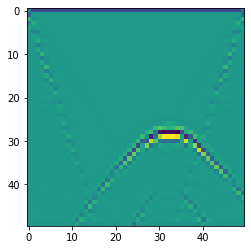

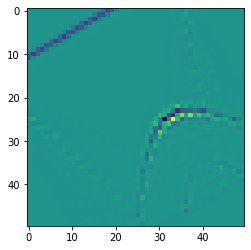

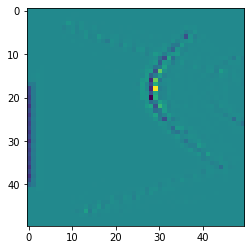

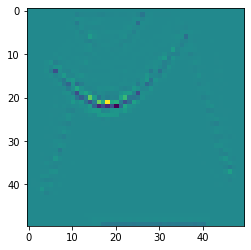

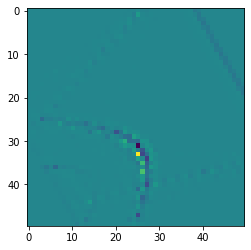

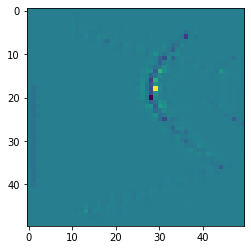

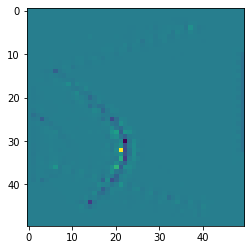

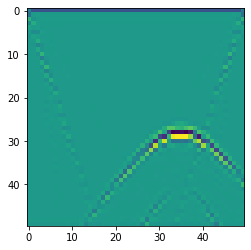

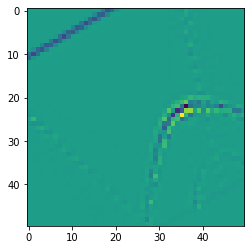

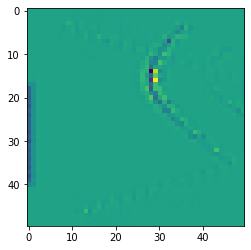

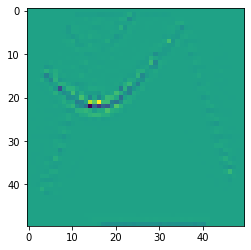

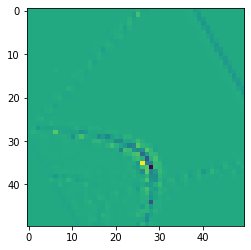

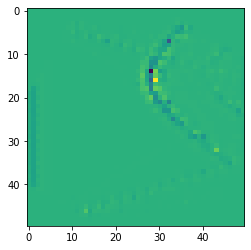

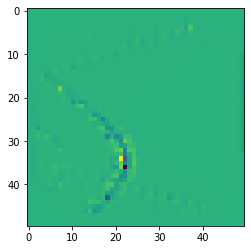

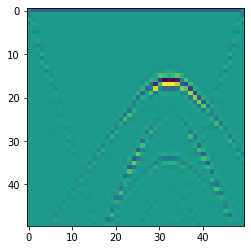

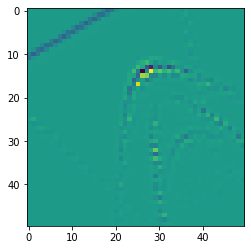

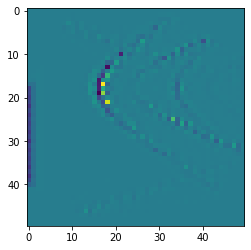

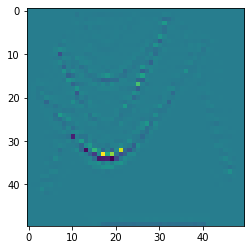

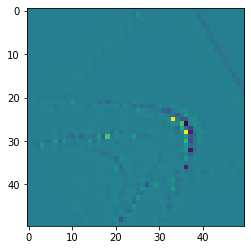

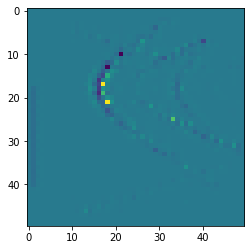

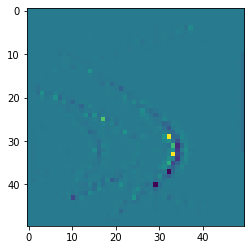

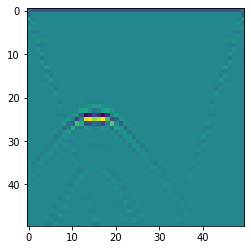

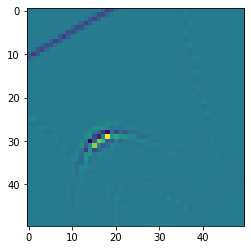

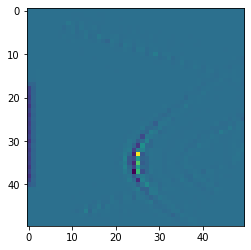

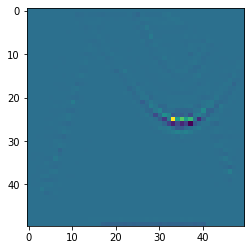

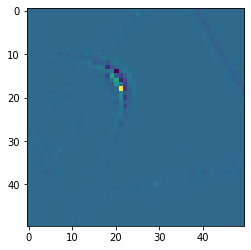

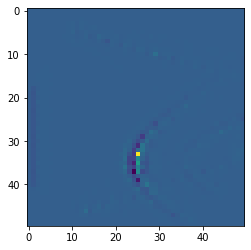

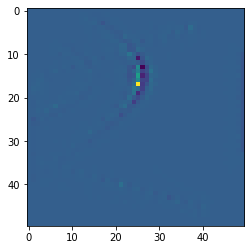

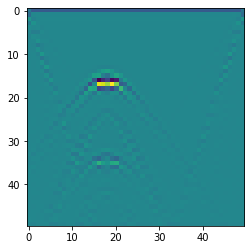

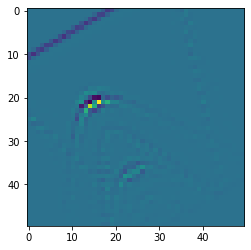

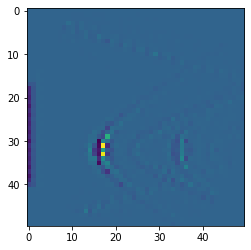

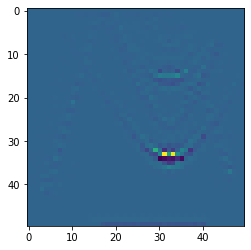

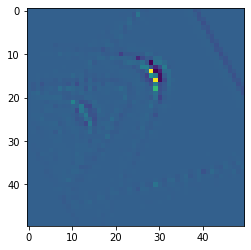

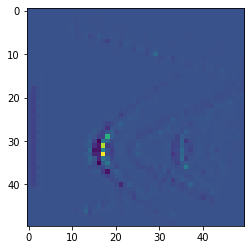

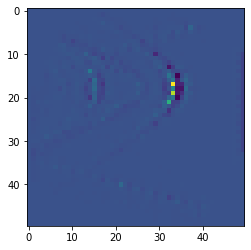

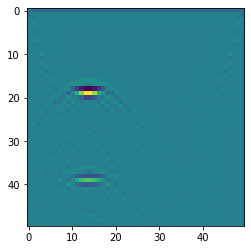

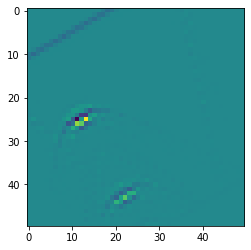

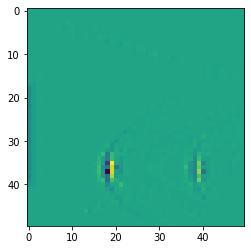

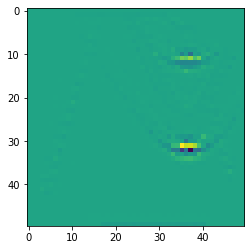

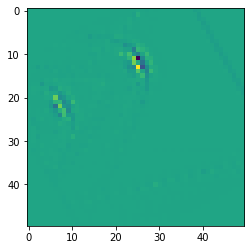

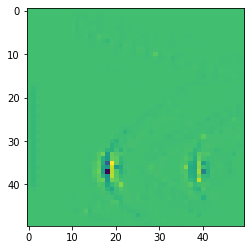

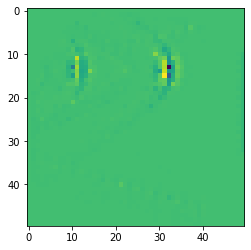

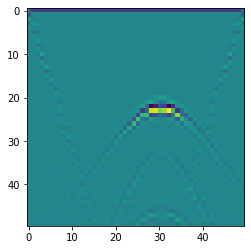

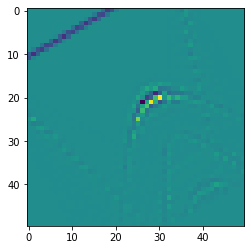

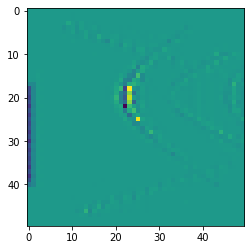

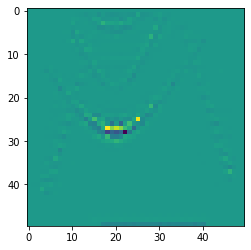

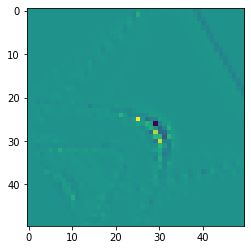

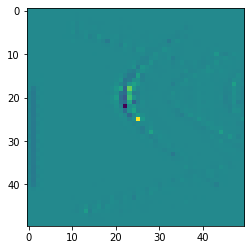

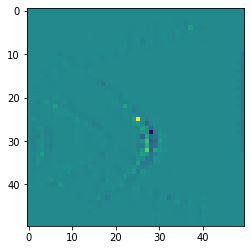

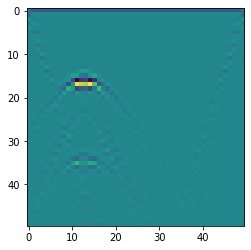

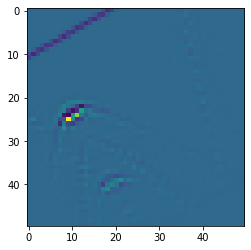

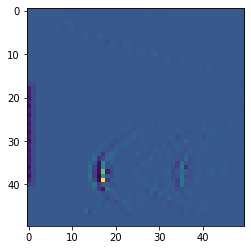

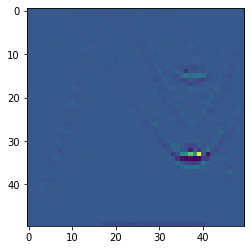

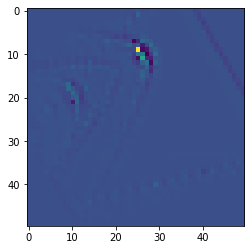

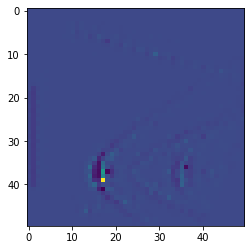

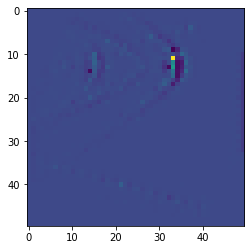

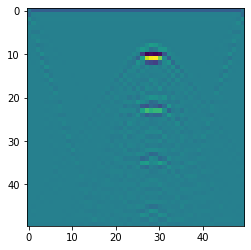

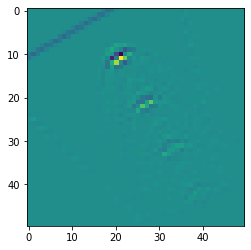

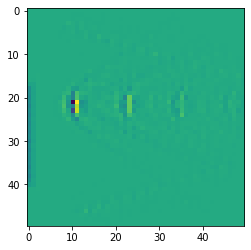

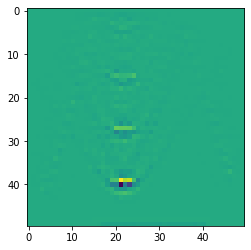

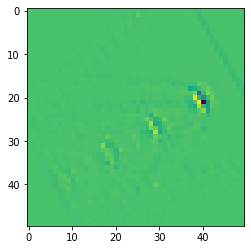

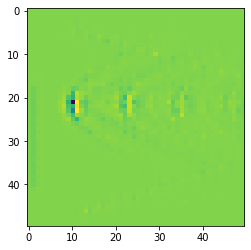

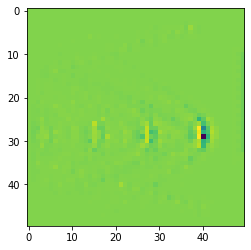

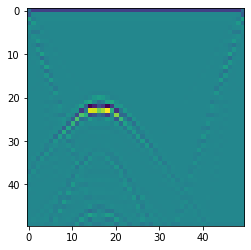

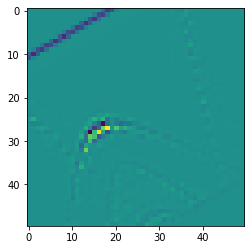

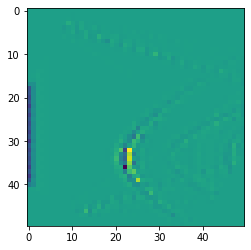

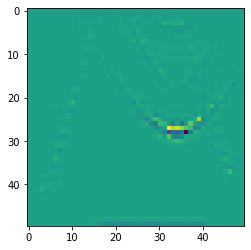

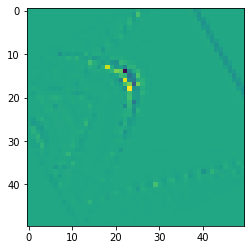

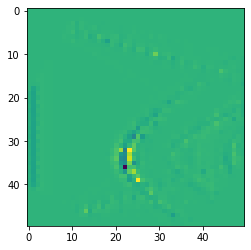

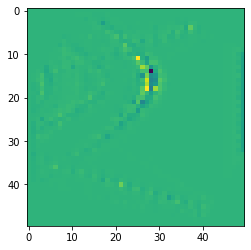

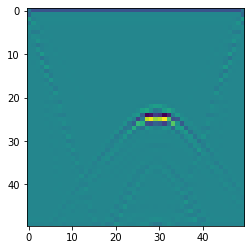

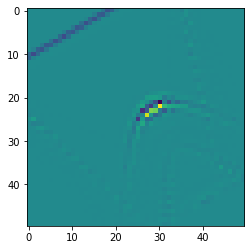

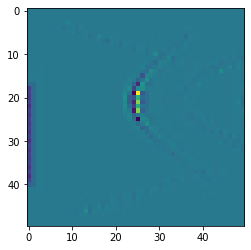

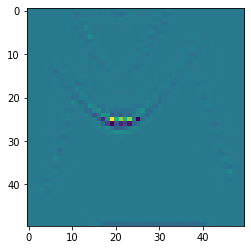

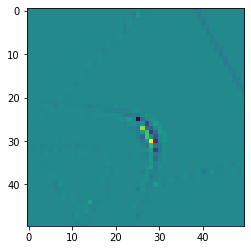

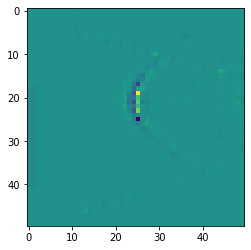

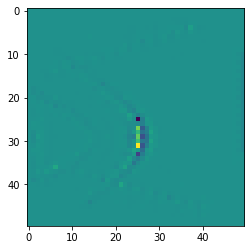

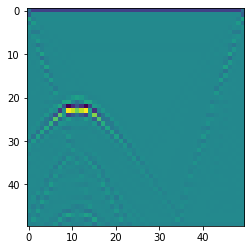

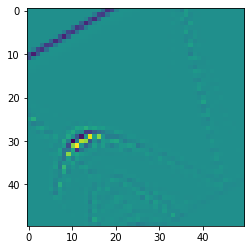

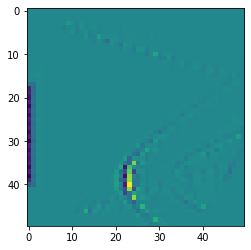

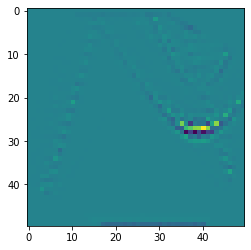

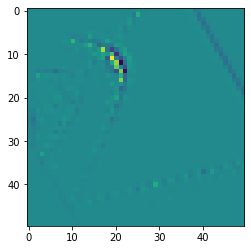

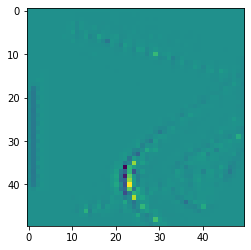

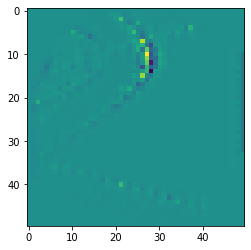

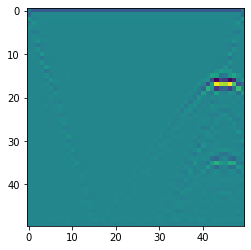

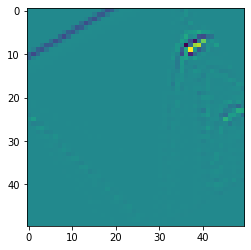

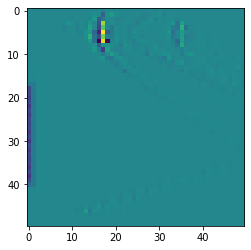

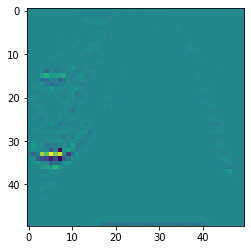

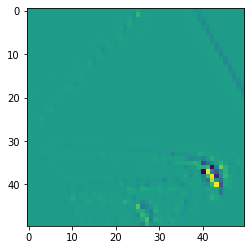

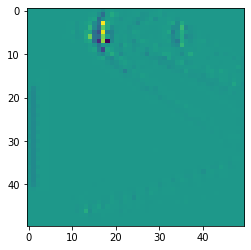

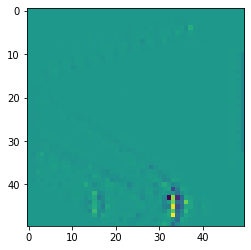

In [11]:
X_train=[]
for batch_train,labels in batch_generator(X_train_files,10):
  for batch_file,label in zip(batch_train,labels):
    data=pd.read_csv(batch_file).values[200:1200,:]
    data=cv2.resize(data, resolution)
    for i in range(7):
      data=imutils.rotate(data, i*30)
      plt.imshow(data)
      plt.show()
      data=data.reshape(Input_shape_cnn)
      X_train.append((data,label))
      
random.shuffle(X_train)

In [12]:
X_train_data=np.array([item[0] for item in X_train])
Y_train=np.array([item[1] for item in X_train])

In [13]:
print(X_train_data.shape)
print(Y_train.shape)

(1120, 50, 50, 1)
(1120, 4)


In [14]:
def bg(batch_size):
  no_of_iter=(len(X_train_data)//batch_size)+1
  
  for i in range(no_of_iter):
    if i!=no_of_iter-2:
      temp_bd=X_train_data[i*batch_size:(i+1)*batch_size,:,:,:]
      temp_lab=Y_train[i*batch_size:(i+1)*batch_size,:]
      
    if i==no_of_iter-2:
      temp_bd=X_train_data[i*batch_size:,:,:]
      temp_lab=Y_train[i*batch_size:,:]
    
    yield temp_bd,temp_lab

In [17]:
optimizer=Adam(0.005) #learning rate set to 0.001, beta1& beta2 of MA left to default
CNN_model.compile(loss="categorical_crossentropy",optimizer=optimizer)
for i in range(epochs):
    if i % 10== 0 and i>=10:
        print('Epoch Number:%d'%i)
    temp_val_acc=0
    for inputs,labl in bg(100):
      #CNN_model.fit(x=inputs, y=labels, batch_size=1, epochs=1,verbose=0)
        loss=CNN_model.train_on_batch(inputs,labl)
        temp_val_acc+=validation(CNN_model,X_valid,Y_valid)
    av_over=(len(X_train_data)//100)+1
    validation_accracy.append(temp_val_acc/av_over)
    if i % eval_interval == 0 and i>=eval_interval:
        print("Validation Accuracy: %f"%validation_accracy[i])


Validation Accuracy: 45.892857
Validation Accuracy: 35.505952
Validation Accuracy: 33.869048
Validation Accuracy: 41.755952
Validation Accuracy: 50.357143
Validation Accuracy: 55.565476
Validation Accuracy: 71.636905
Validation Accuracy: 74.434524
Validation Accuracy: 76.488095
Epoch Number:10
Validation Accuracy: 82.440476
Validation Accuracy: 85.476190
Validation Accuracy: 84.077381
Validation Accuracy: 84.910714
Validation Accuracy: 76.250000
Validation Accuracy: 82.619048
Validation Accuracy: 82.023810
Validation Accuracy: 76.964286
Validation Accuracy: 49.583333
Validation Accuracy: 64.375000
Epoch Number:20
Validation Accuracy: 64.553571
Validation Accuracy: 75.446429
Validation Accuracy: 69.672619
Validation Accuracy: 71.101190
Validation Accuracy: 87.172619
Validation Accuracy: 87.113095
Validation Accuracy: 81.250000
Validation Accuracy: 86.250000
Validation Accuracy: 81.488095
Validation Accuracy: 75.892857
Epoch Number:30
Validation Accuracy: 86.488095
Validation Accuracy: 9

TypeError: run() missing 1 required positional argument: 'fetches'